In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/New_Fixed_Classify_Labeled_Data

/content/drive/MyDrive/New_Fixed_Classify_Labeled_Data


In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.9 MB/s eta 0:00:00


In [4]:
import torch
import torchvision.transforms as transforms
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from glob import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import torchvision

In [9]:
normal = glob("normal/*")
abnormal = glob("abnormal/*")
normal_2x = glob("normal_2x/*")
abnormal_2x = glob("abnormal_2x/*")

In [10]:
X = normal + abnormal + normal_2x + abnormal_2x
y = [0]*len(normal) + [1]*len(abnormal) + [2]*len(normal_2x) + [3]*len(abnormal_2x)

In [ ]:
len(X)
len(y)

3460

In [11]:
seed = 19
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = val_size,
    shuffle = is_shuffle,
    random_state = seed
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size = test_size,
    shuffle = is_shuffle,
    random_state = seed
)

In [5]:
def new_resize_image(image, target_size, value=0):
    """
    Resize the input image to target x target x3. If the image is smaller, pad it. If it is larger, crop it.

    Parameters:
    image (array): The input image in BGR format.

    Returns:
    array: The resized image of size target x target x3.
    """
    height, width, _ = image.shape

    if height < target_size or width < target_size:
        # Calculate padding
        pad_height = max(0, target_size - height)
        pad_width = max(0, target_size - width)
        # Pad the image
        padded_image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=value)
        # Crop to ensure the final size is exactly target_size x target_size
        resized_image = padded_image[:target_size, :target_size, :]
    else:
        # Crop the image
        start_x = (width - target_size) // 2
        start_y = (height - target_size) // 2
        resized_image = image[start_y:start_y + target_size, start_x:start_x + target_size, :]

    return resized_image

In [6]:
data_transform = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.ColorJitter(
            brightness = 0.2,
        ),
        transforms.RandomRotation(180),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [7]:
class MyDataset(Dataset):
    def __init__(self,X,y, transform = None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = self.labels[index]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [12]:
train_dataset = MyDataset(
    X_train,
    y_train,
    transform = data_transform['train']
)

val_dataset = MyDataset(
    X_val,
    y_val,
    transform = data_transform['val']
)

test_dataset = MyDataset(
    X_test,
    y_test,
    transform = data_transform['val']
)

In [13]:
print(f"Train dataset: {len(train_dataset)}")
print(f"Val dataset: {len(val_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 2422
Val dataset: 692
Test dataset: 346


In [14]:
batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

In [15]:
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

tensor([1, 3, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0,
        0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 3, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 0, 0, 3, 0, 1, 1, 3,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 3, 1, 0, 1, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 0, 1,
        1, 1, 1, 3, 1, 1, 1, 0])


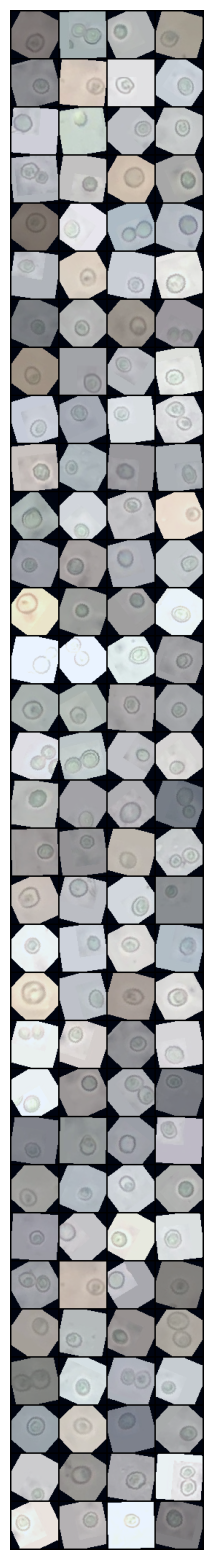

In [16]:
train_features, train_labels = next(iter(train_loader))

def show_batch(imgs,labels):
    print(labels)
    grid = torchvision.utils.make_grid(imgs, nrow = 4, normalize = True)
    plt.figure(figsize = (5,20))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis('off')
    plt.show()

show_batch(train_features, train_labels)

In [17]:
import torch
import torch.nn as nn
import timm

class CustomCNN(nn.Module):
    def __init__(self, num_classes, unfreeze_layers=3, dropout=0.2):
        super(CustomCNN, self).__init__()
        # Sử dụng ResNet101 làm backbone
        backbone = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            in_chans=3,
        )

        # Lấy các lớp từ backbone trừ 2 lớp cuối cùng
        modules = list(backbone.children())[:-2]
        self.backbone = nn.Sequential(*modules)

        # Unfreeze các lớp cuối cùng của backbone
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        # Thay đổi in_channels của conv1 thành 1280
        self.conv1 = nn.Conv2d(in_channels=1280, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer cuối cùng để dự đoán nhãn
        self.fc = nn.Linear(64*2*2, num_classes)

    def forward(self, x):
        # Truyền dữ liệu qua backbone
        # print(x.shape)
        x = self.backbone(x)
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        # print(x.shape)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        # print(x.shape)
        x = nn.ReLU()(x)

        x = x.view(x.size(0), -1) # Flatten the tensor
        # print(x.shape)
        x = self.dropout(x)

        # Fully connected layer cuối cùng
        x = self.fc(x)

        return x

In [ ]:
unfreeze_layers = 3
num_classes = 4
model = CustomCNN(num_classes, unfreeze_layers)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_vector = torch.rand((128,3,64,64)).to(device)
model.to(device)
with torch.no_grad():
    dummy_output = model(dummy_vector)
print(dummy_output.shape)

torch.Size([128, 4])


#**Training**

In [18]:
def evaluate(model, dataloader,criterion,device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
    loss = np.mean(losses)
    return loss

In [19]:
def fit(model, dataloader, criterion, optimizer, device, num_epochs, sheduler):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        sheduler.step(val_loss)
    return train_losses, val_losses



In [ ]:
epochs = 100
lr = 0.001
weight_decay = 1e-5
scheduler_step_size = epochs * 0.4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size = scheduler_step_size,
    gamma = 0.1
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    criterion,
    optimizer,
    device,
    epochs,
    scheduler
)

Epoch 1/100, Train Loss: 0.8434, Val Loss: 1.2948


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/100, Train Loss: 0.4221, Val Loss: 0.2814
Epoch 3/100, Train Loss: 0.2684, Val Loss: 0.2678
Epoch 4/100, Train Loss: 0.2230, Val Loss: 0.1653
Epoch 5/100, Train Loss: 0.1956, Val Loss: 0.1412
Epoch 6/100, Train Loss: 0.1574, Val Loss: 0.1239
Epoch 7/100, Train Loss: 0.1232, Val Loss: 0.0862
Epoch 8/100, Train Loss: 0.1346, Val Loss: 0.1600
Epoch 9/100, Train Loss: 0.1336, Val Loss: 0.2626
Epoch 10/100, Train Loss: 0.1249, Val Loss: 0.1116
Epoch 11/100, Train Loss: 0.0687, Val Loss: 0.0671
Epoch 12/100, Train Loss: 0.0813, Val Loss: 0.0728
Epoch 13/100, Train Loss: 0.0706, Val Loss: 0.0538
Epoch 14/100, Train Loss: 0.0692, Val Loss: 0.1780
Epoch 15/100, Train Loss: 0.0801, Val Loss: 0.1209
Epoch 16/100, Train Loss: 0.0712, Val Loss: 0.0519
Epoch 17/100, Train Loss: 0.0705, Val Loss: 0.0381
Epoch 18/100, Train Loss: 0.0707, Val Loss: 0.0540
Epoch 19/100, Train Loss: 0.0529, Val Loss: 0.0507
Epoch 20/100, Train Loss: 0.0510, Val Loss: 0.0325
Epoch 21/100, Train Loss: 0.0521, Val L

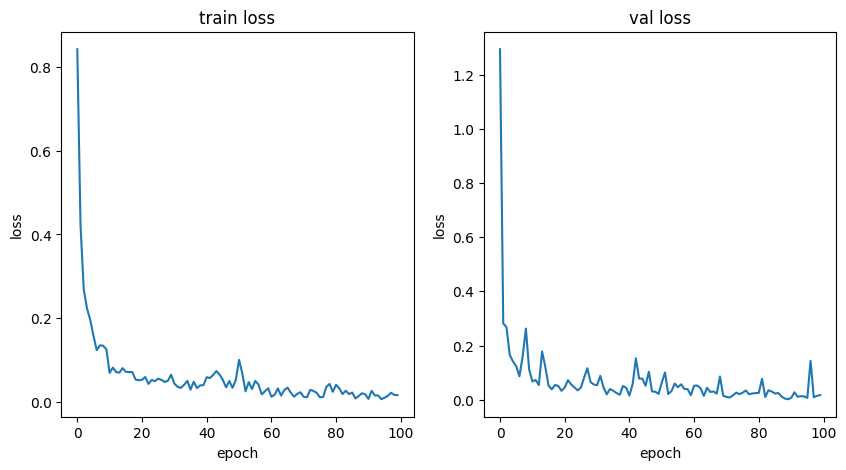

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label = 'train')
plt.subplot(1,2,2)
plt.title('val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(val_losses, label = 'val')
plt.show()

In [ ]:
train_loss = evaluate(
    model,
    train_loader,
    criterion,
    device
)
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

In [ ]:
print(train_loss)
print(val_loss)
print(test_loss)

0.01981785485373908
0.016840357139396172
0.03932139681031307


In [ ]:
save_path = "64x64cnn_base_best.pt"
torch.save(
    model.state_dict(),
    save_path
)

#**End-to-end Pipeline**

In [23]:
num_classes = 4
unfreeze_layers = 3
save_path = "64x64cnn_base_best.pt"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
model = CustomCNN(num_classes, unfreeze_layers)
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()

<ipython-input-24-e54dcf8732e5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


CustomCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (2): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kerne

In [25]:
def predict(img_path, model, device):
    img = Image.open(img_path).convert("RGB")
    img = data_transform['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    return pred.item()


In [26]:
img_path = test_dataset.img_paths[0]
print(predict(img_path, model, device))

0


0


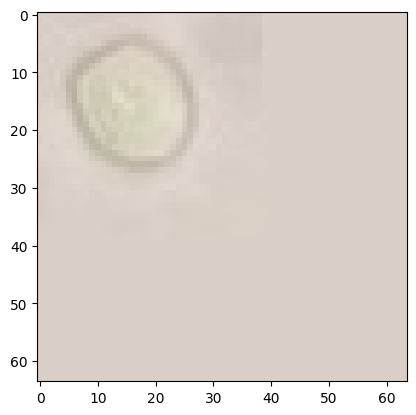

1


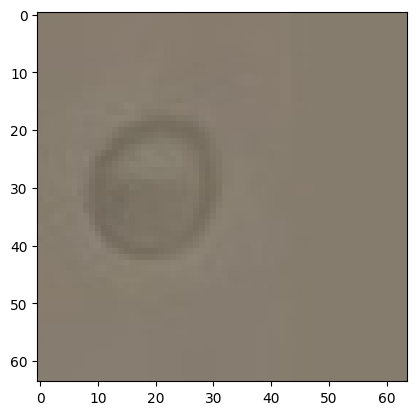

1


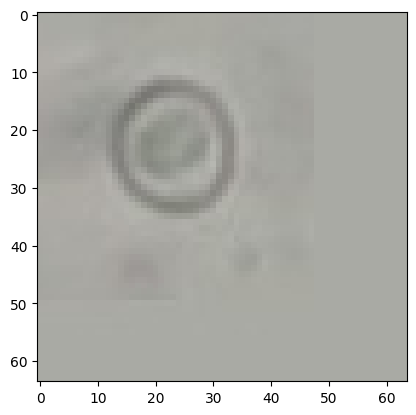

0


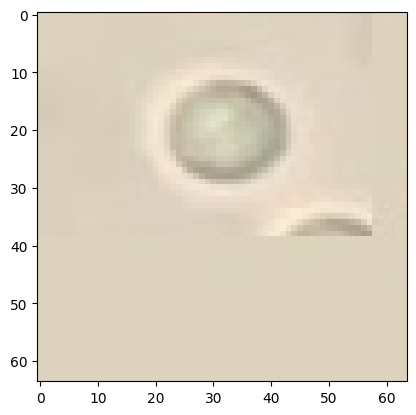

1


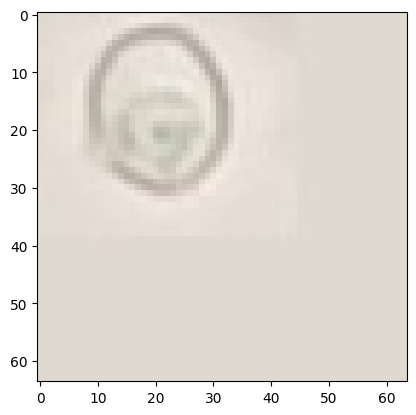

2


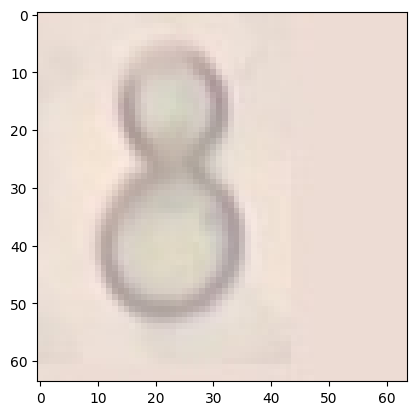

0


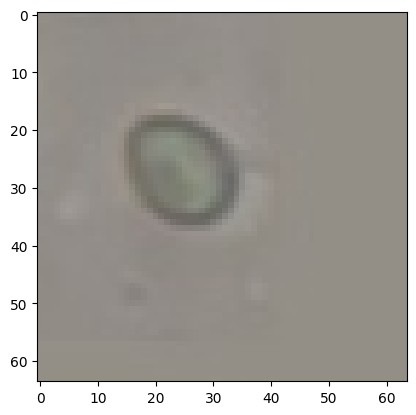

1


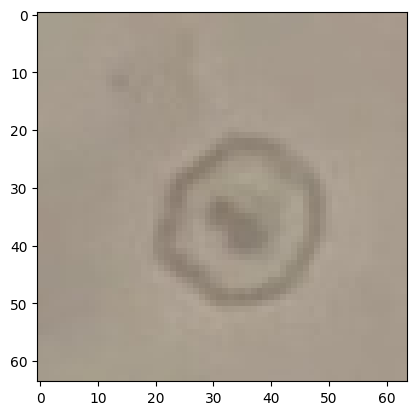

0


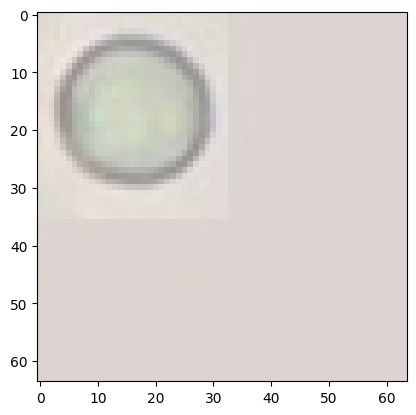

1


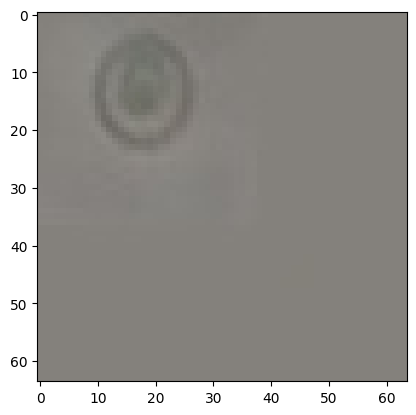

1


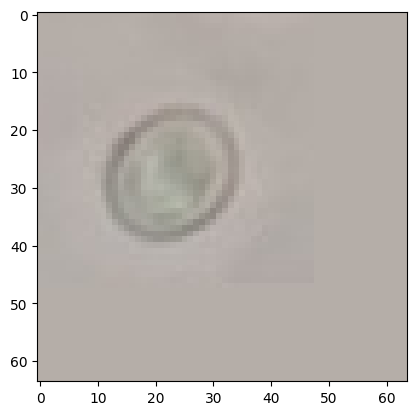

1


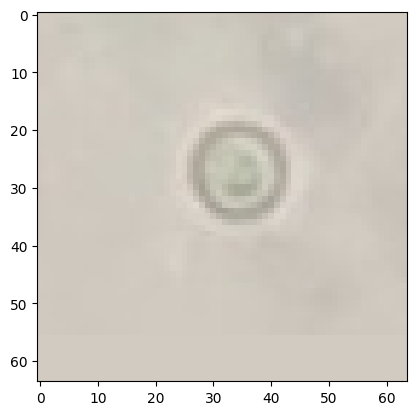

3


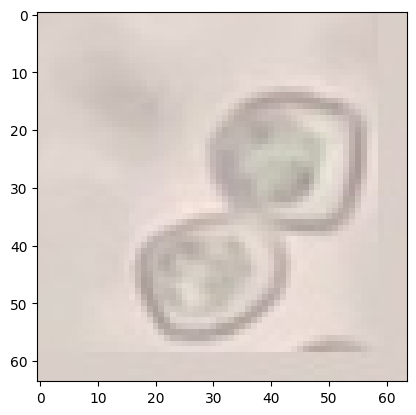

0


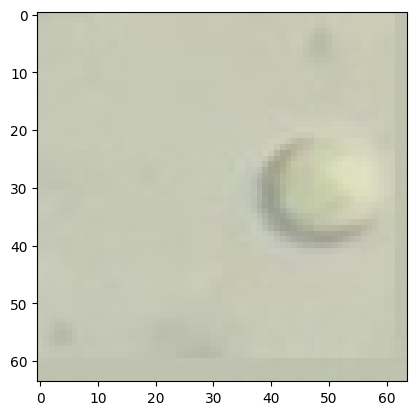

1


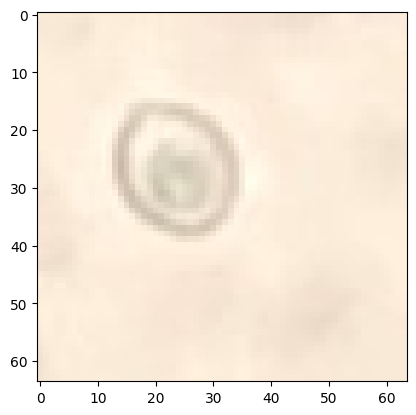

1


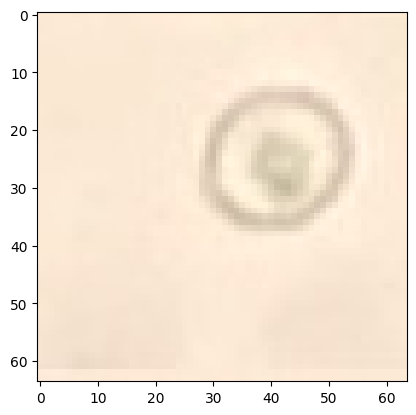

3


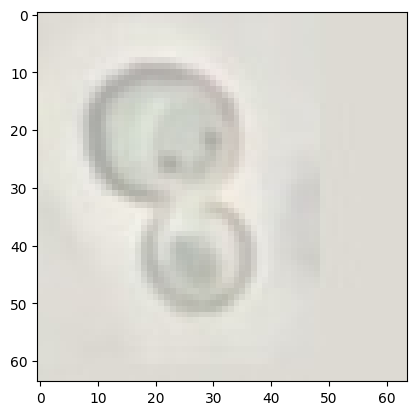

1


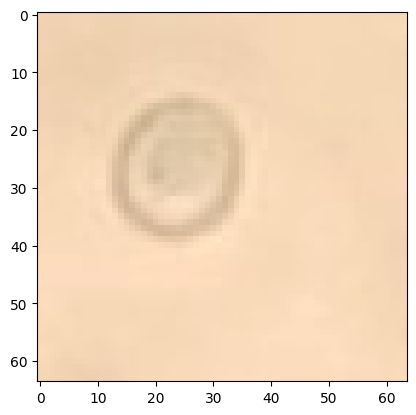

1


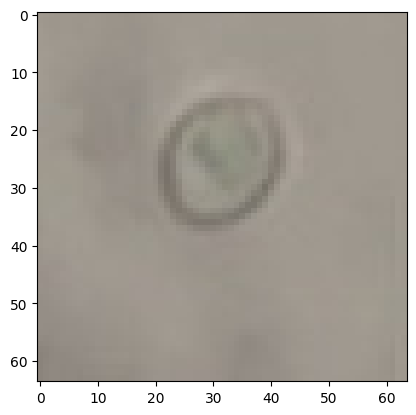

1


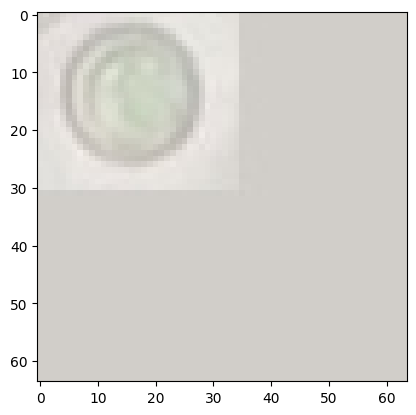

3


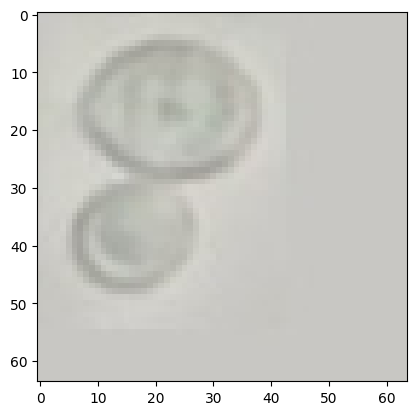

1


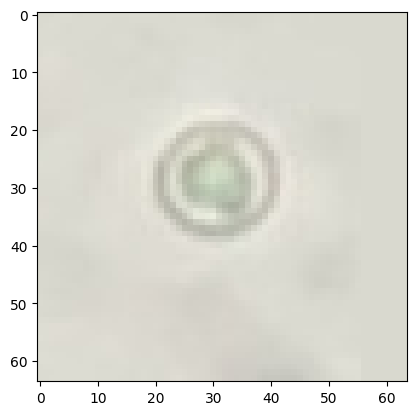

1


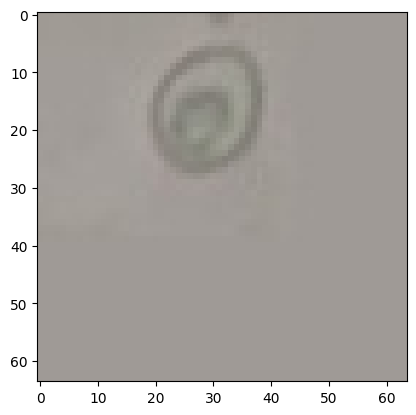

1


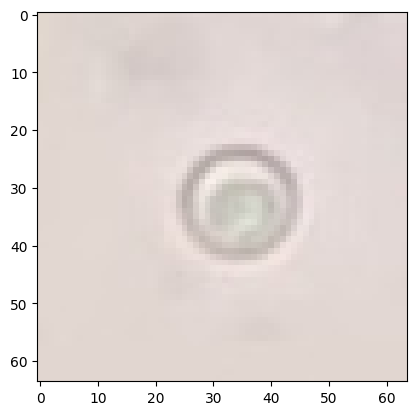

1


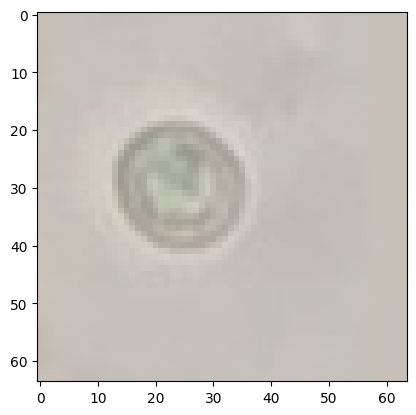

0


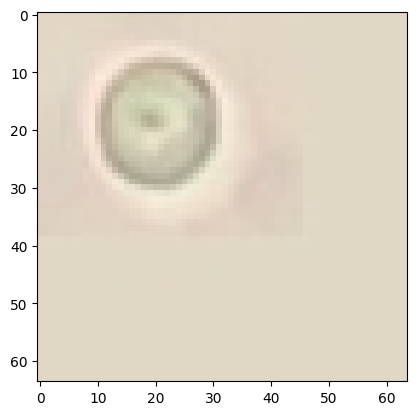

1


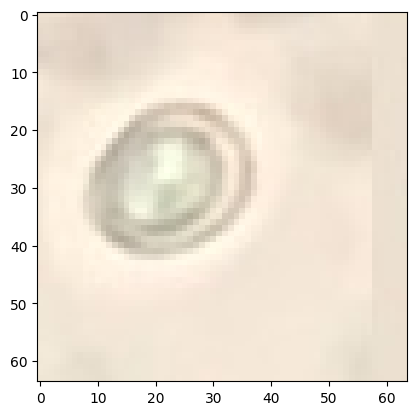

0


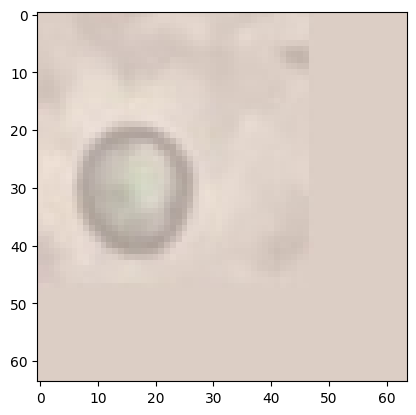

1


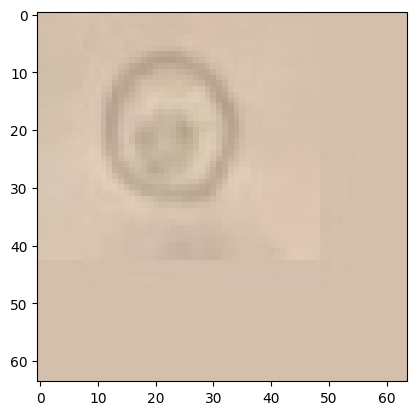

0


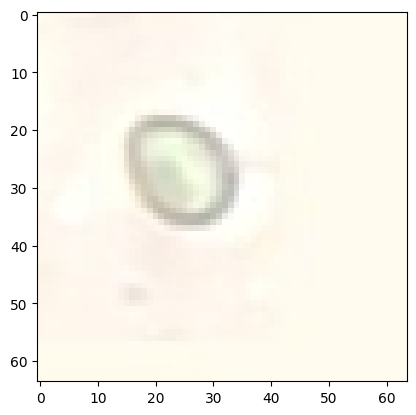

3


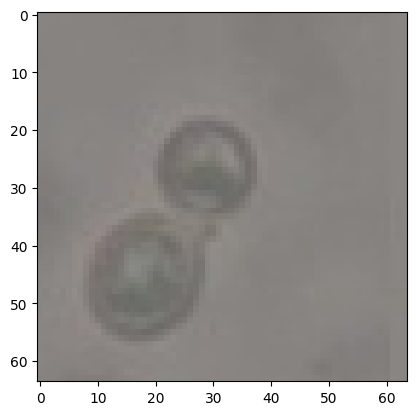

1


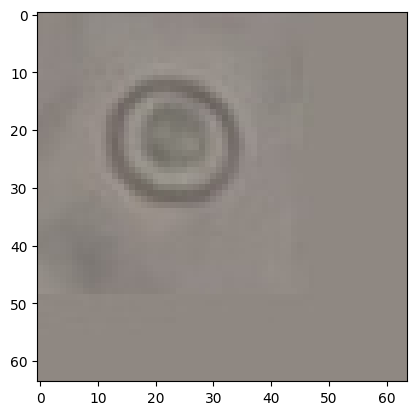

0


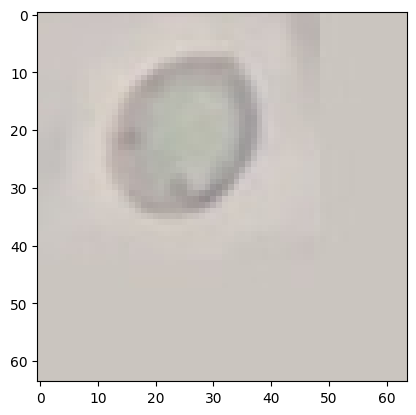

3


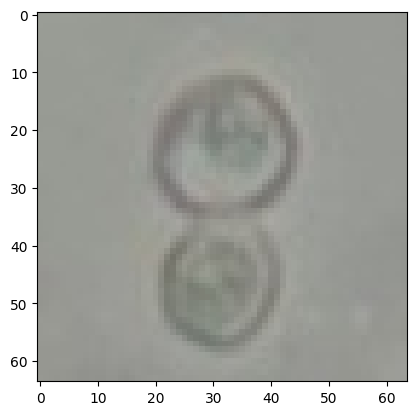

1


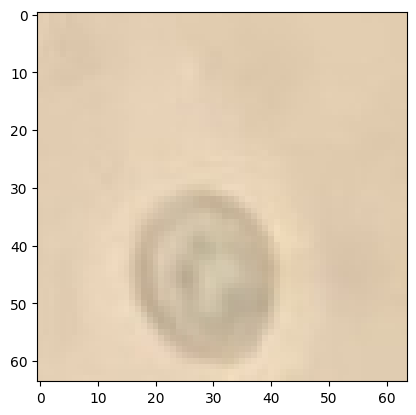

3


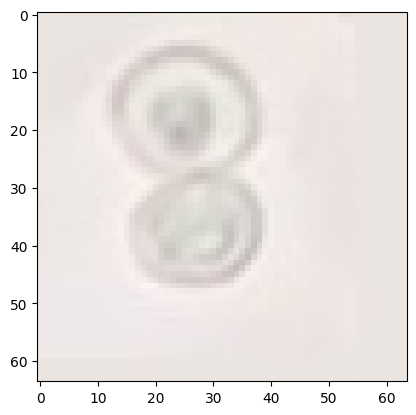

0


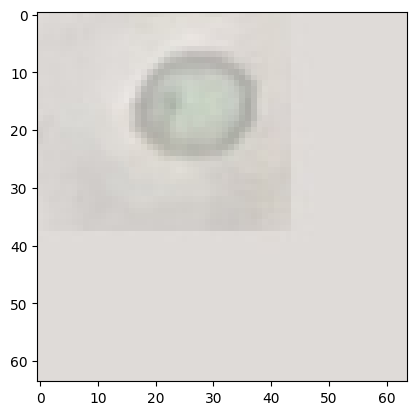

1


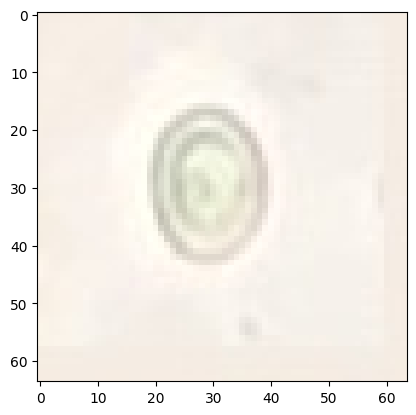

1


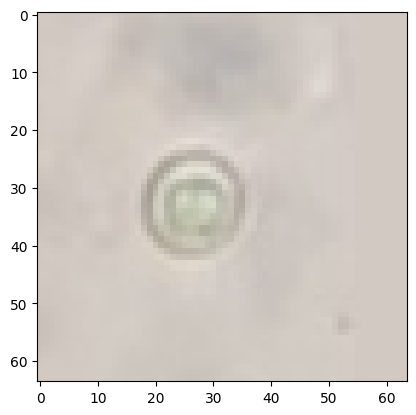

1


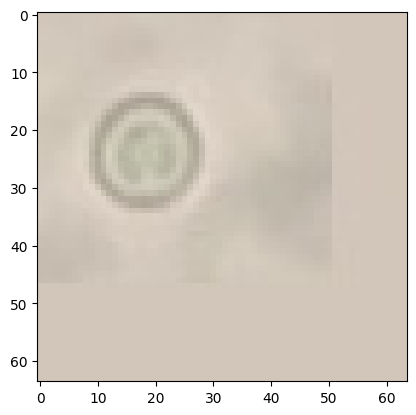

0


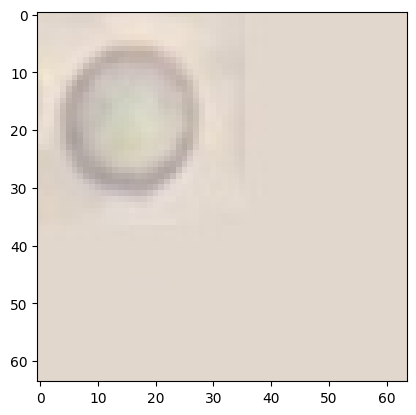

2


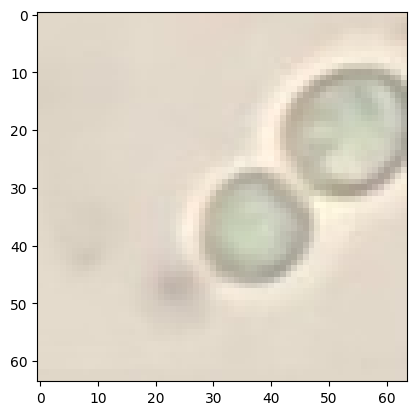

3


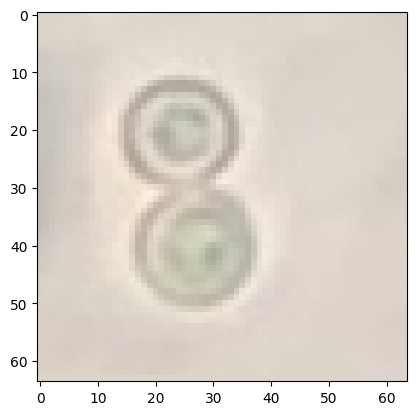

3


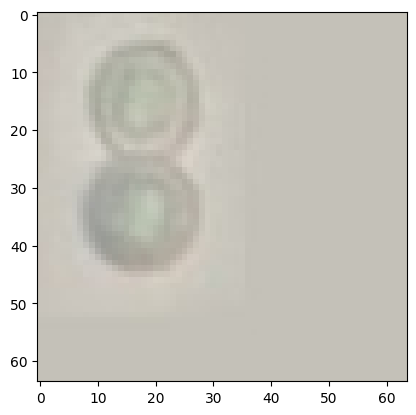

1


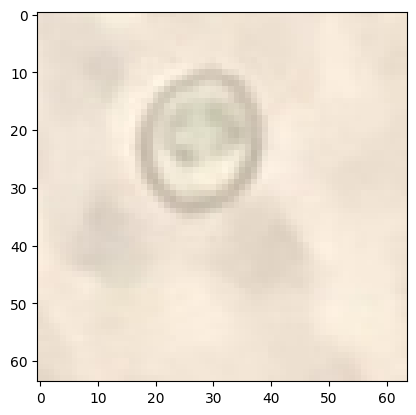

1


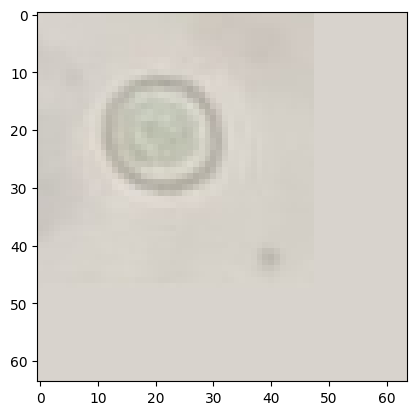

1


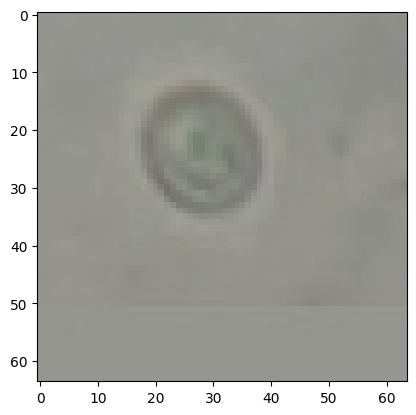

1


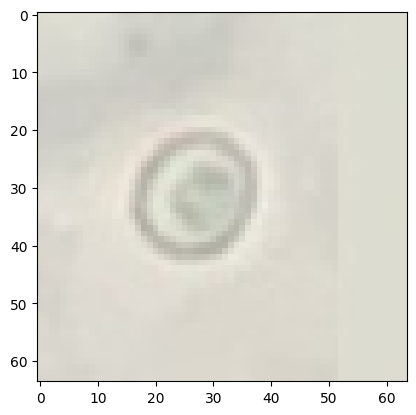

1


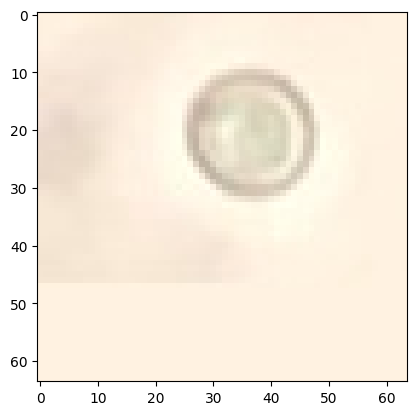

1


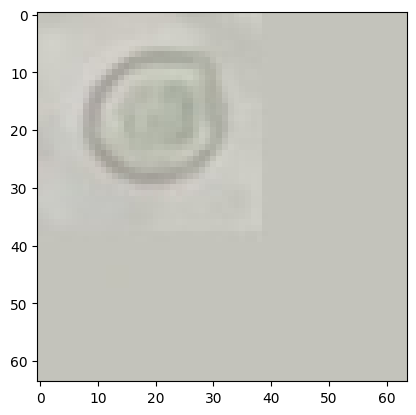

1


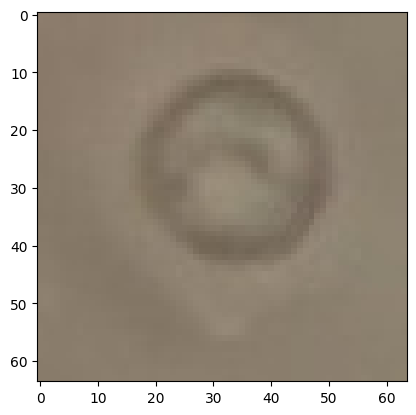

1


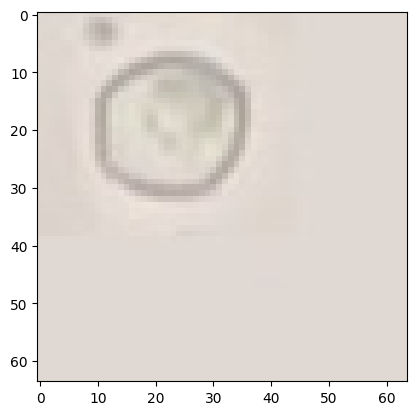

0


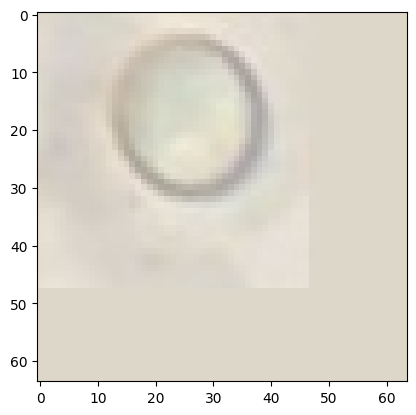

1


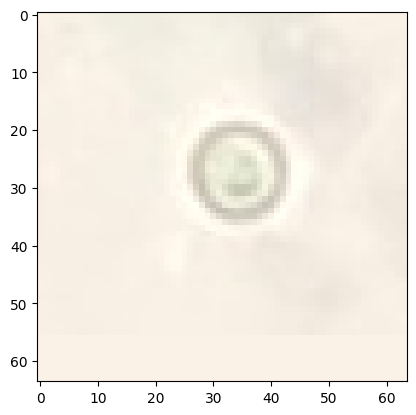

0


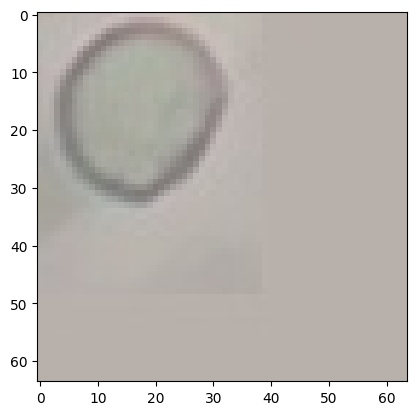

1


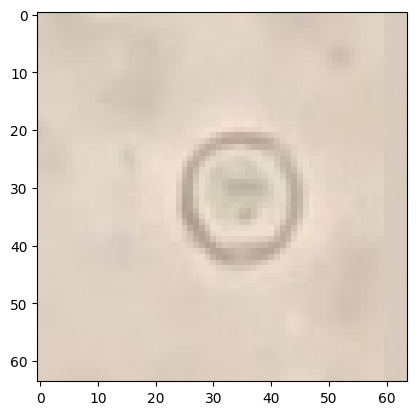

1


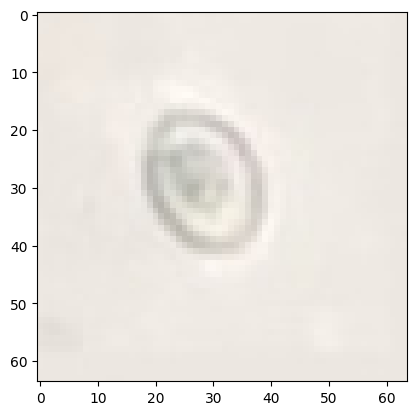

1


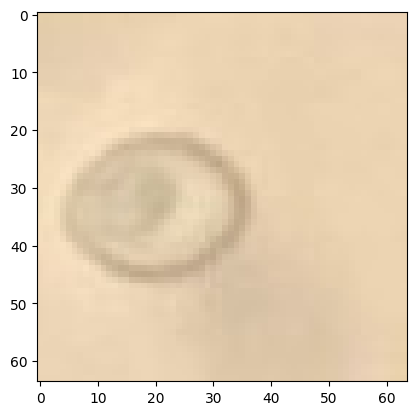

0


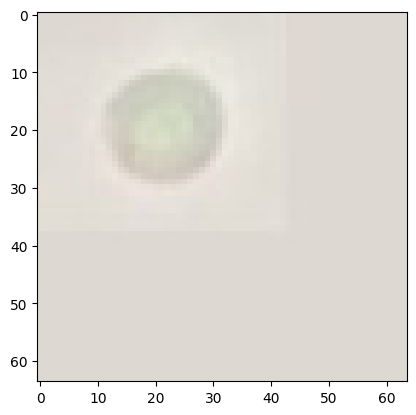

1


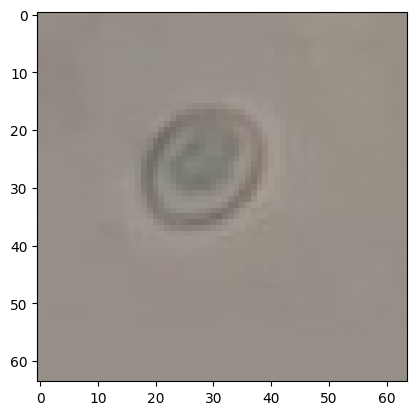

1


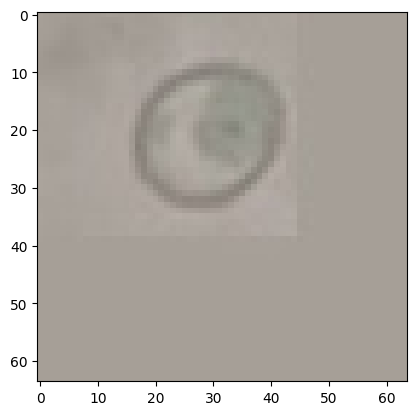

0


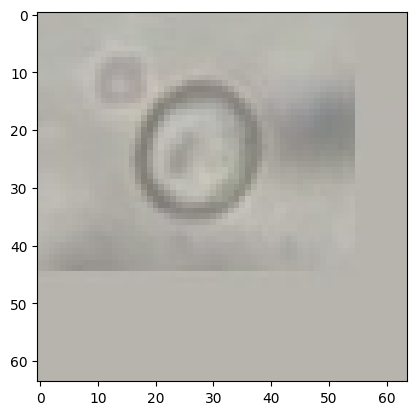

1


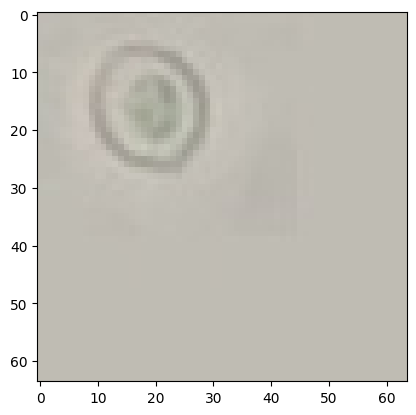

1


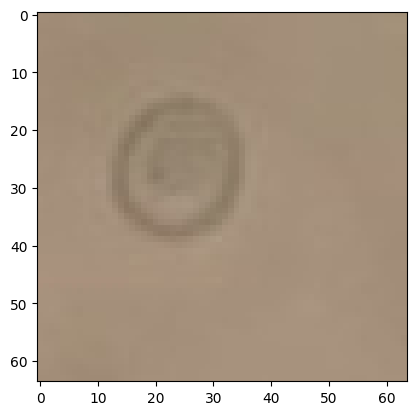

3


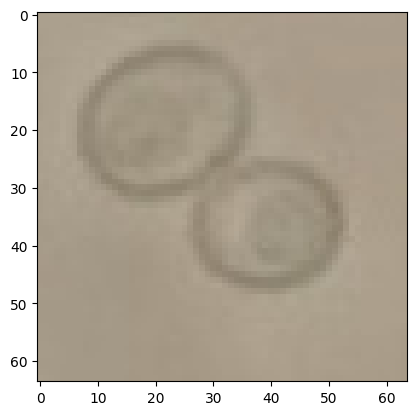

1


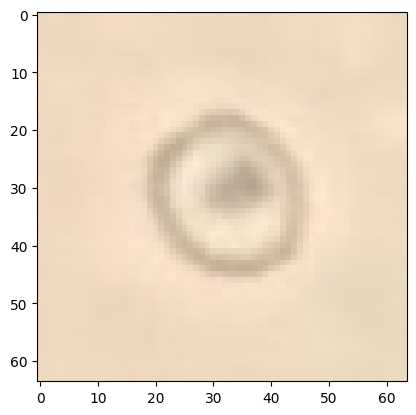

0


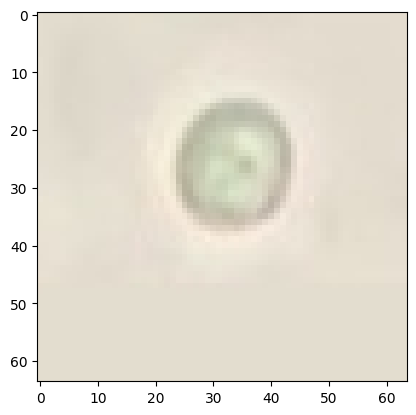

3


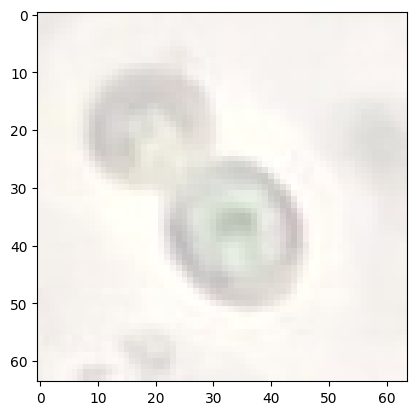

3


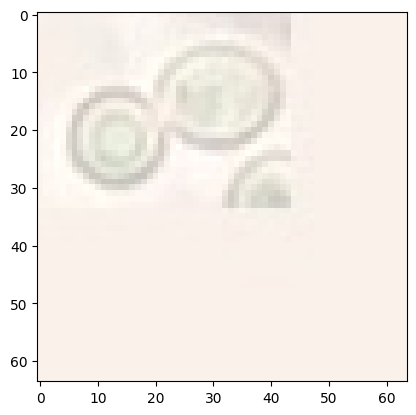

1


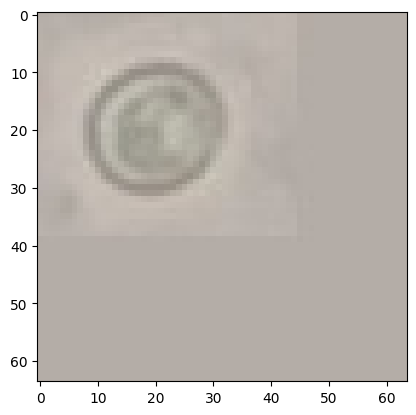

1


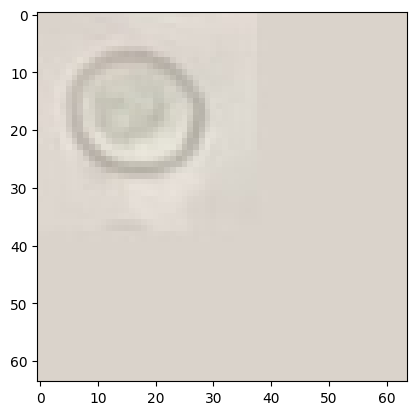

1


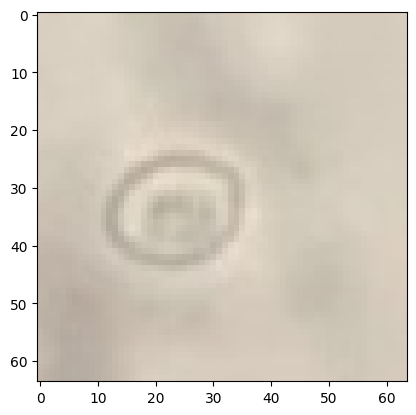

0


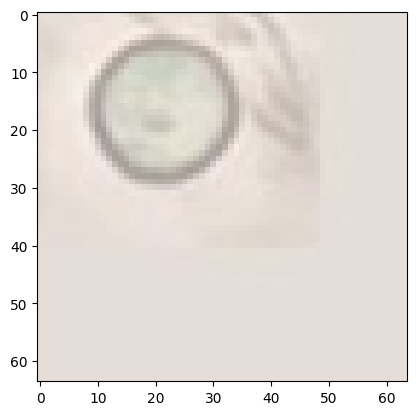

1


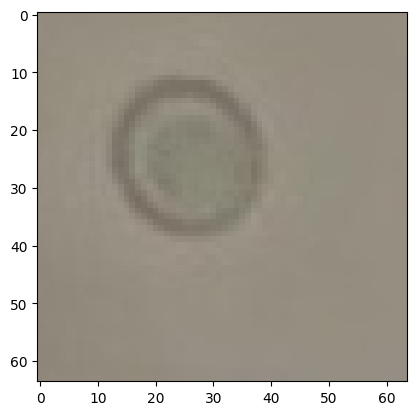

1


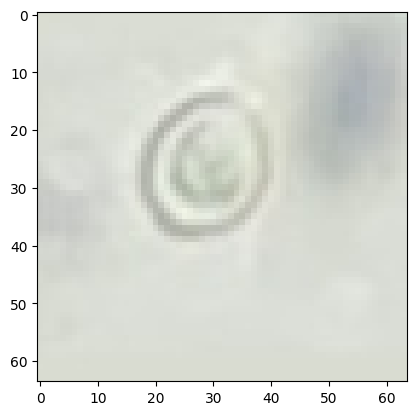

1


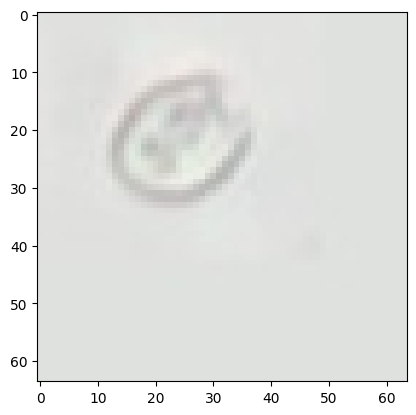

3


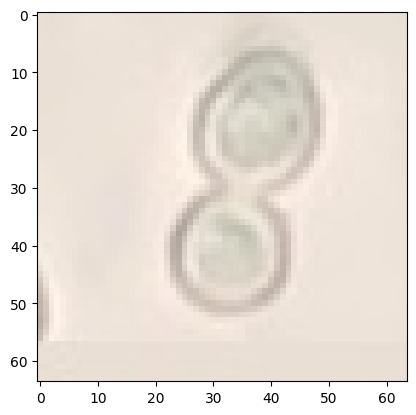

1


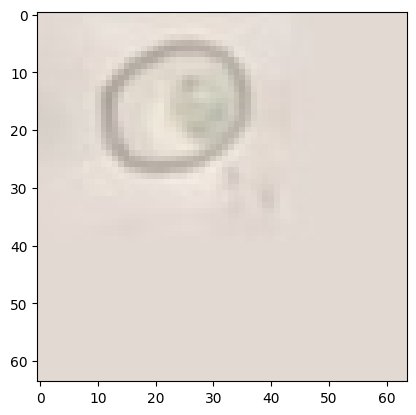

1


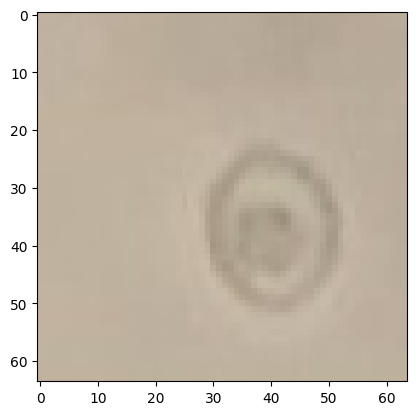

1


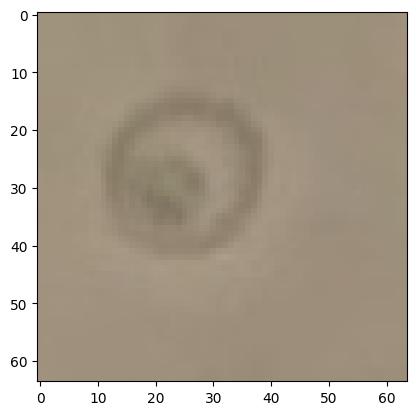

1


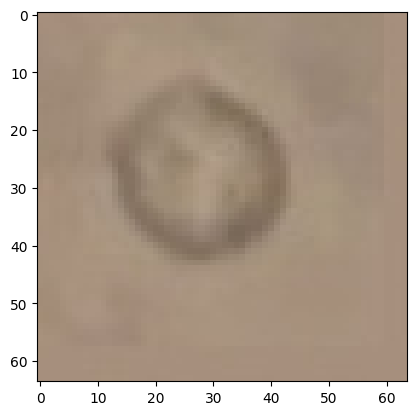

1


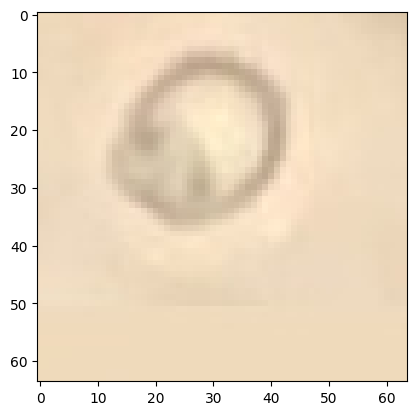

1


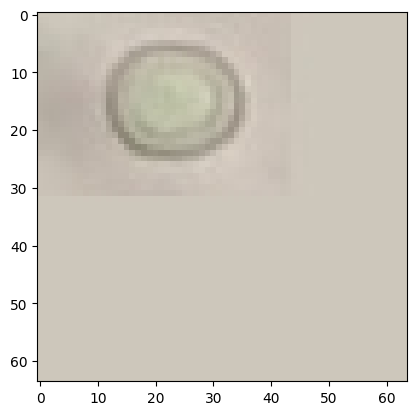

1


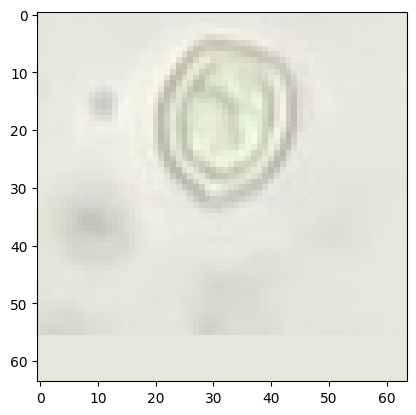

0


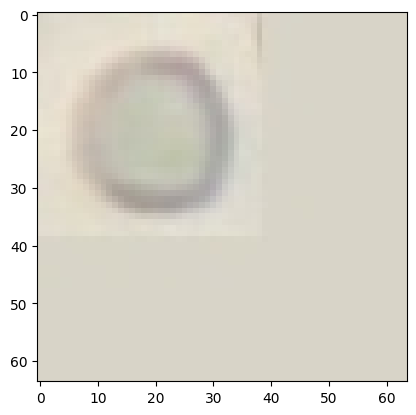

1


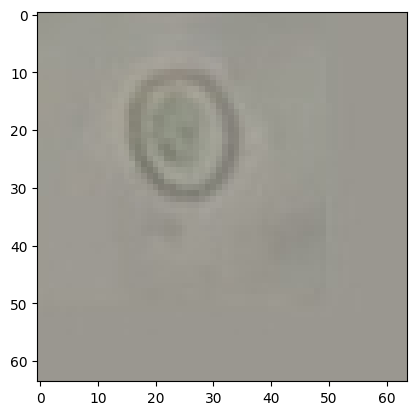

1


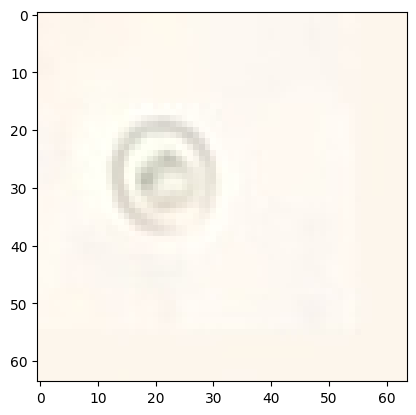

1


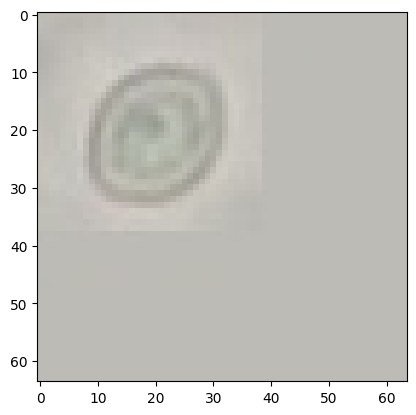

1


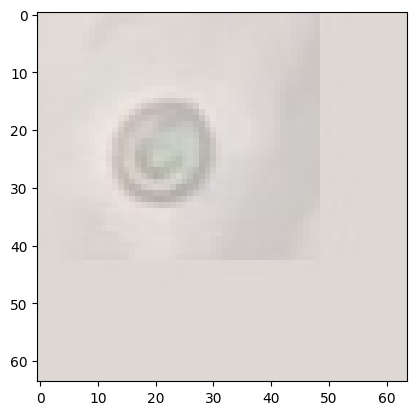

1


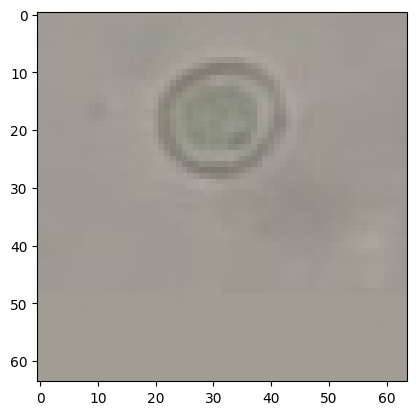

1


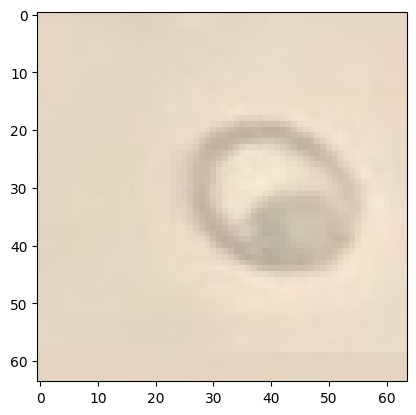

0


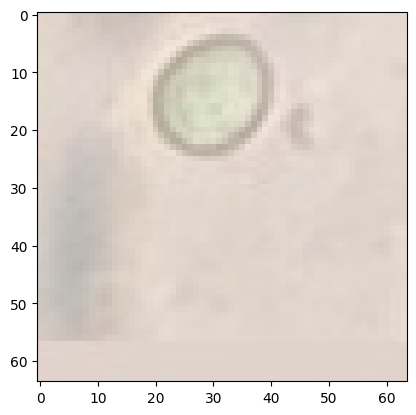

1


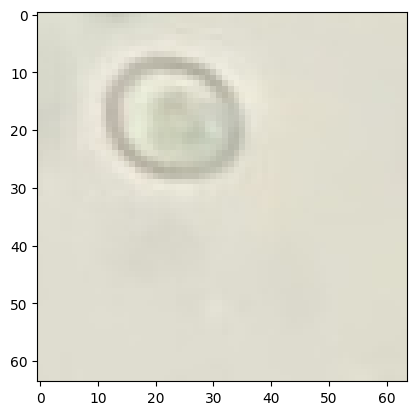

1


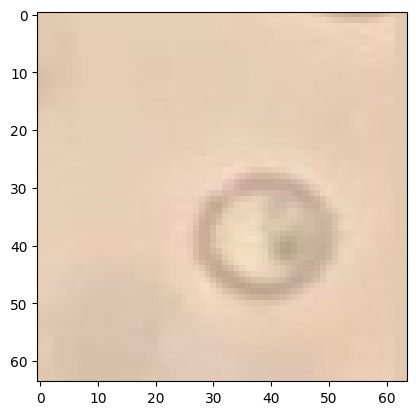

0


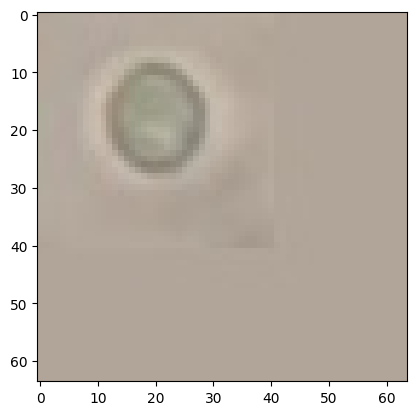

1


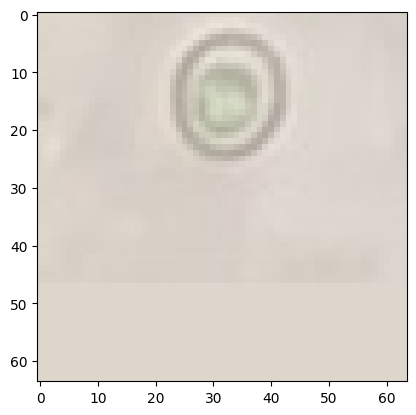

1


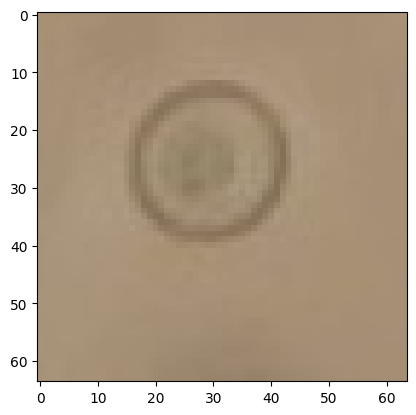

1


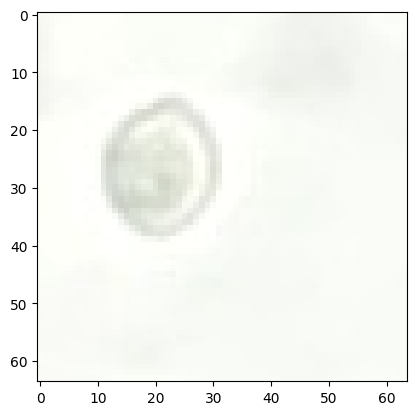

1


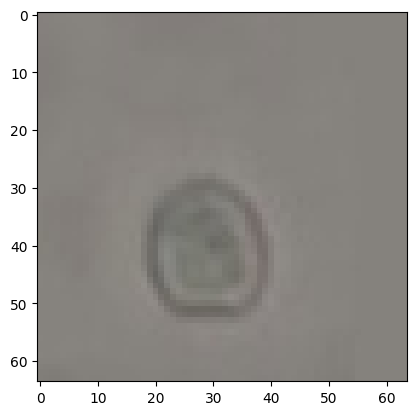

1


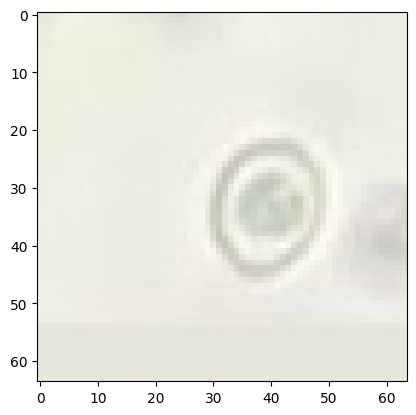

1


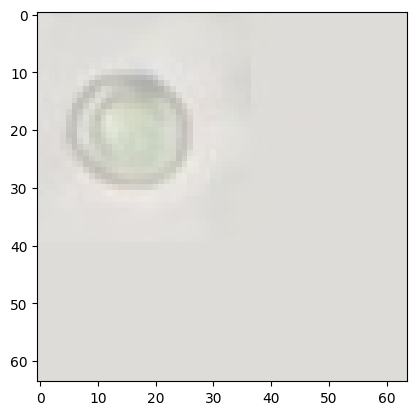

1


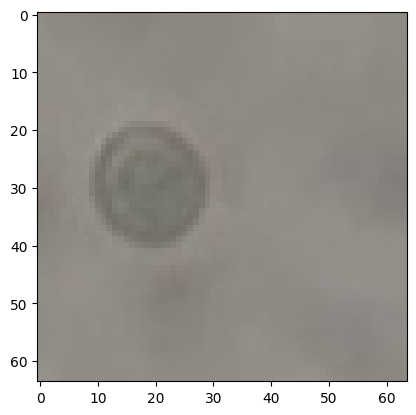

0


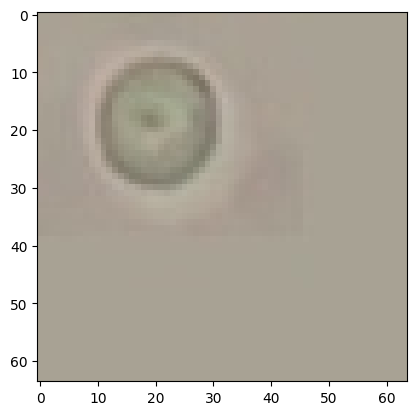

3


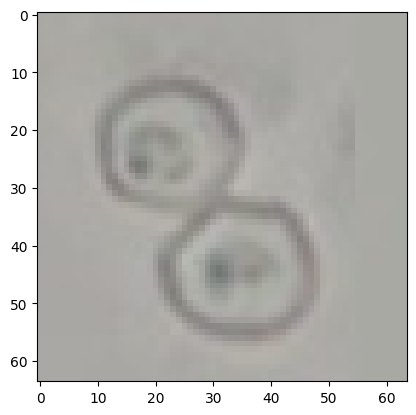

0


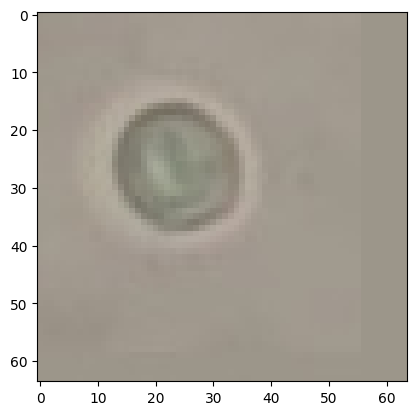

0


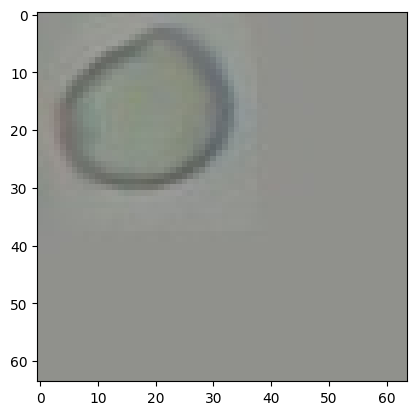

0


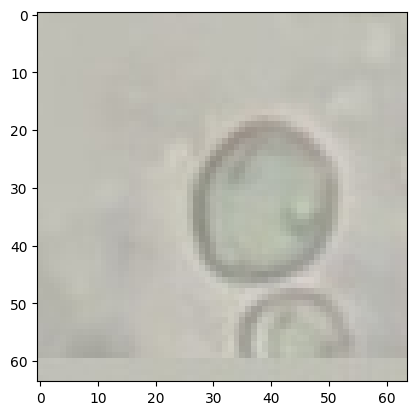

1


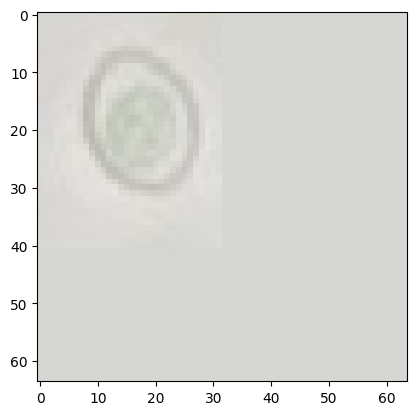

1


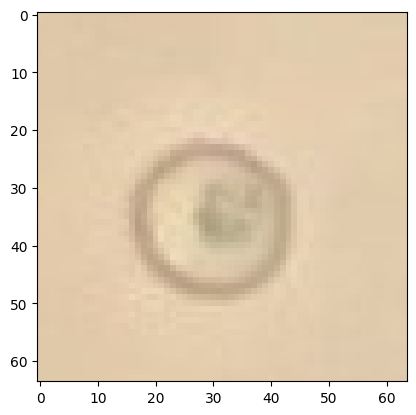

1


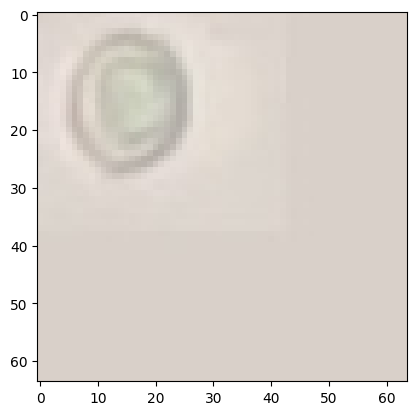

2


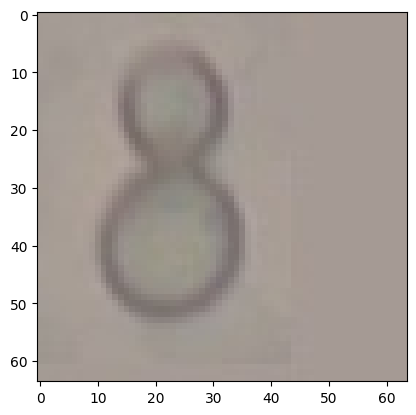

1


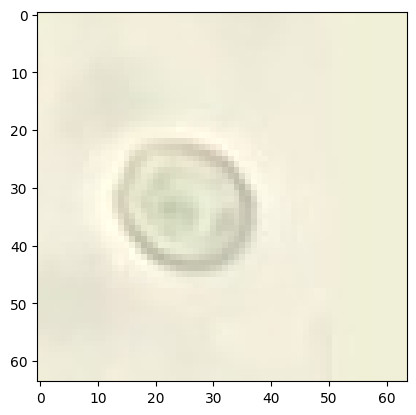

1


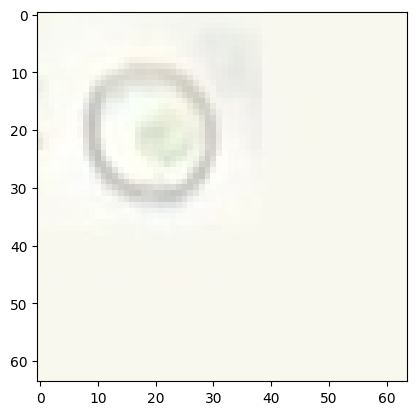

0


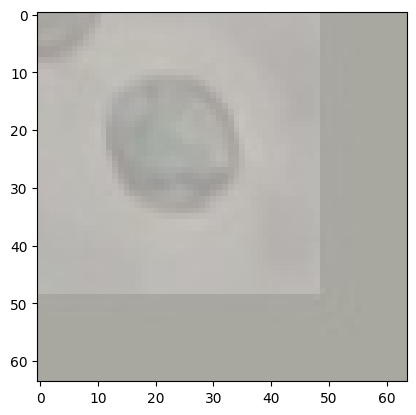

1


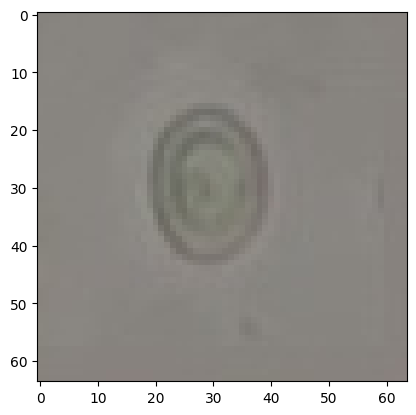

3


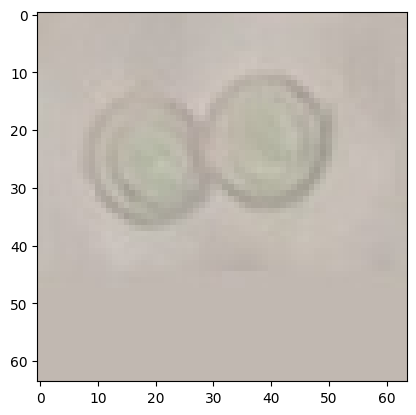

3


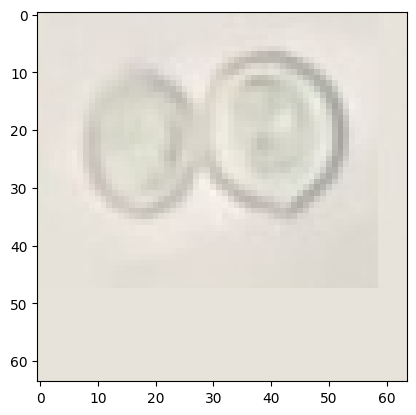

2


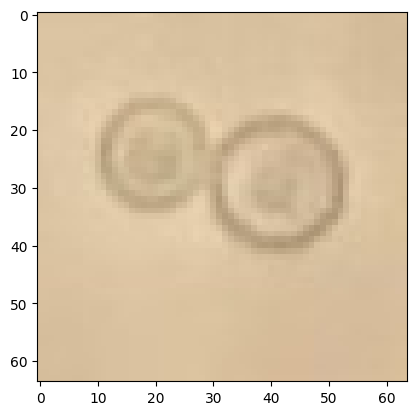

0


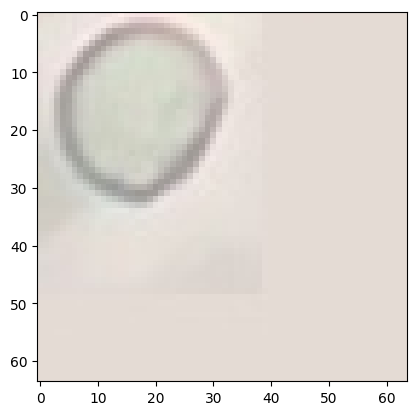

0


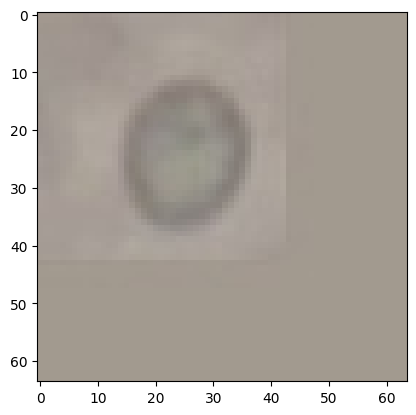

0


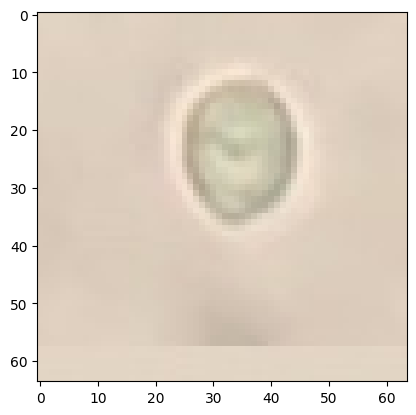

0


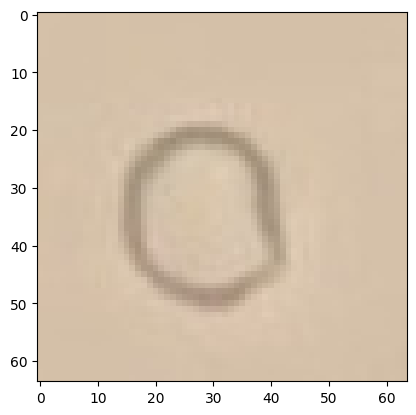

1


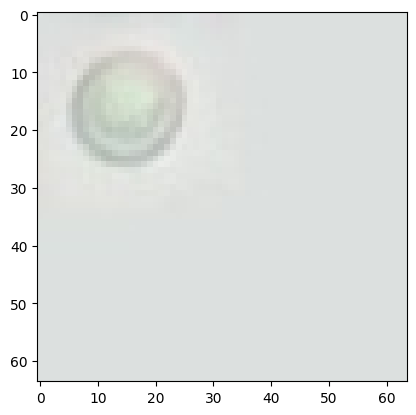

0


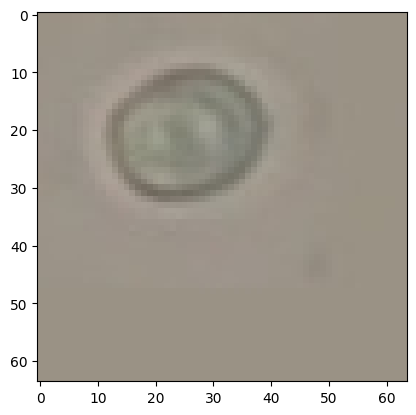

1


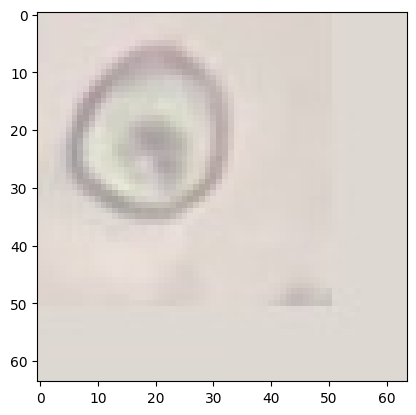

0


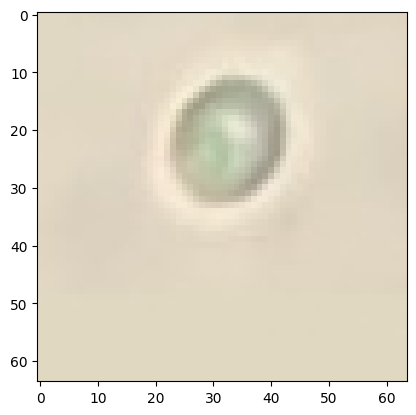

1


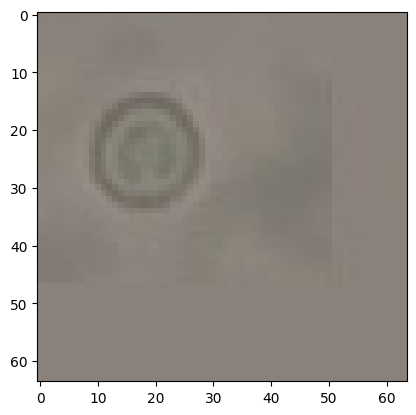

1


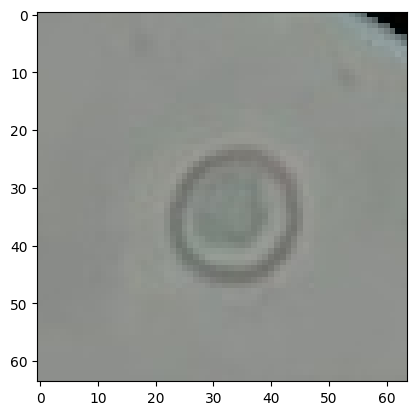

1


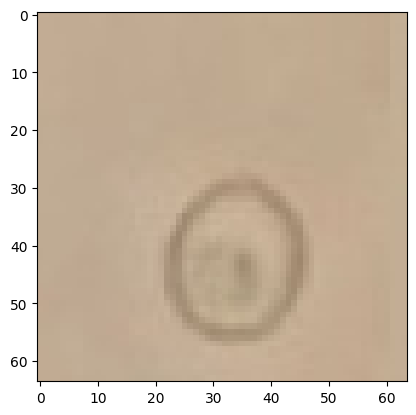

3


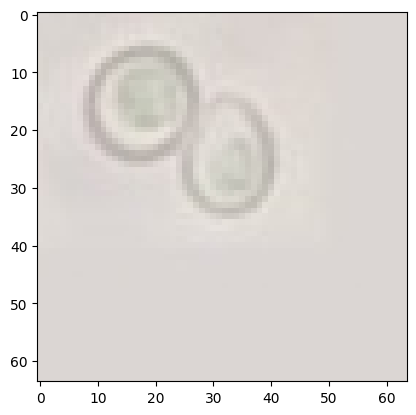

3


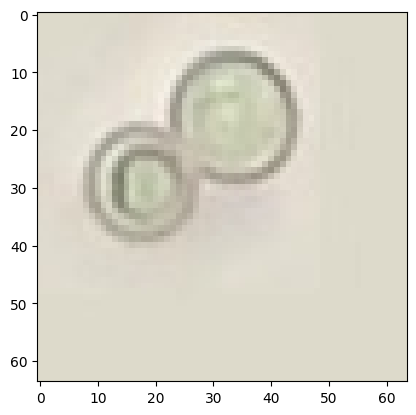

1


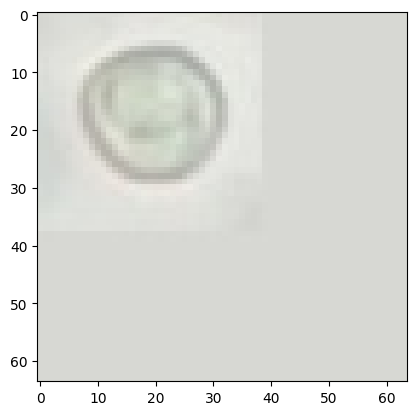

2


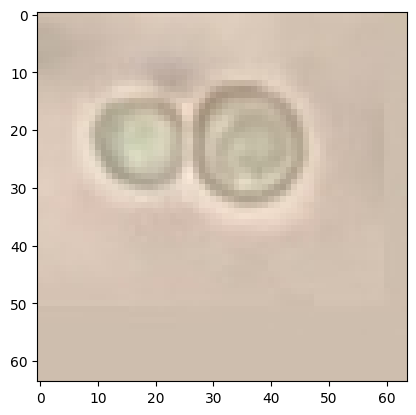

1


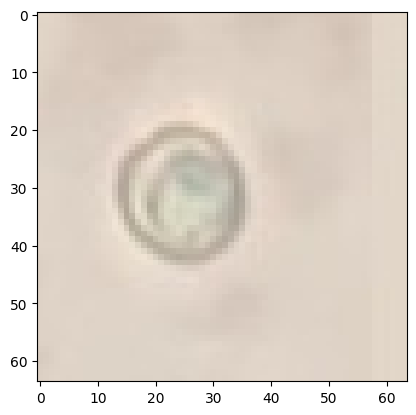

3


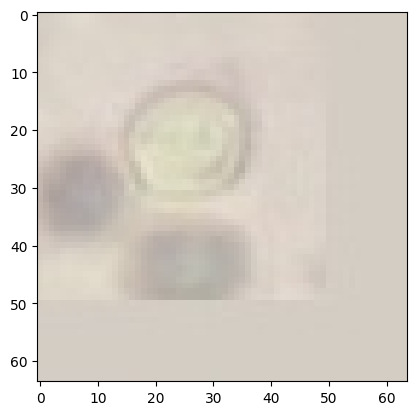

3


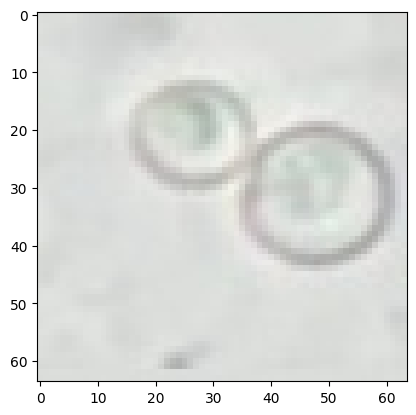

0


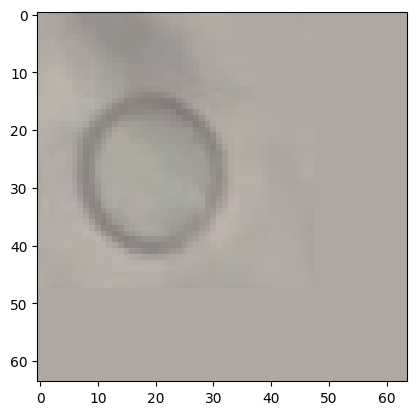

0


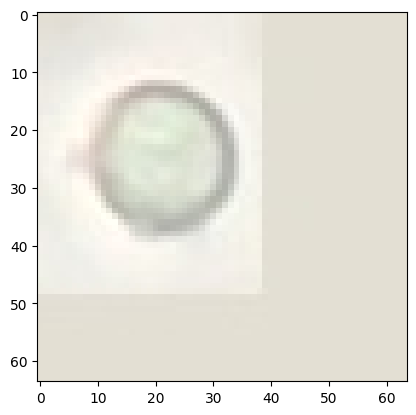

0


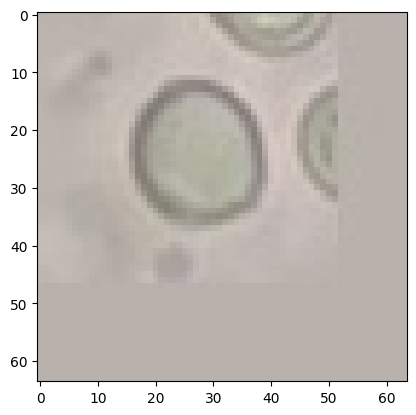

1


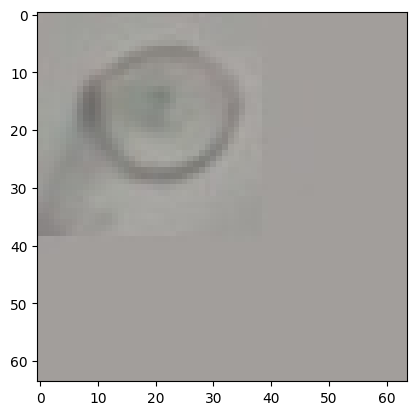

0


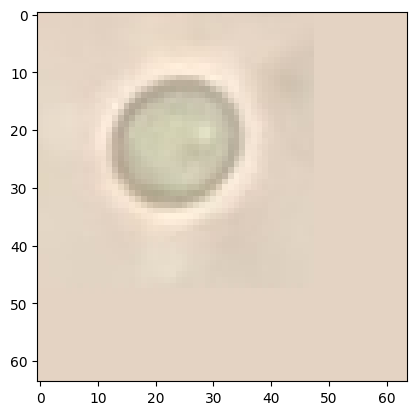

0


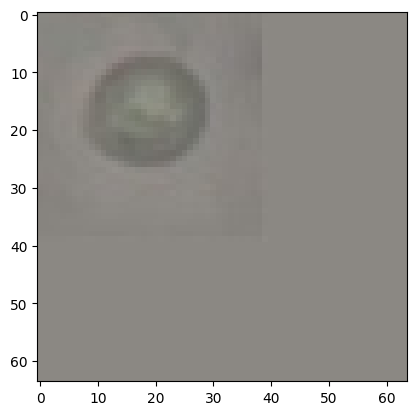

0


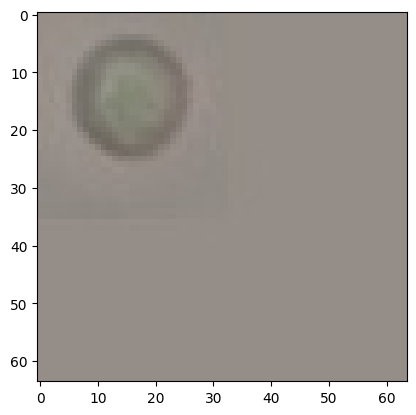

1


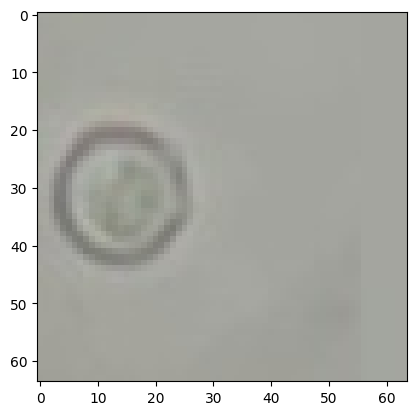

0


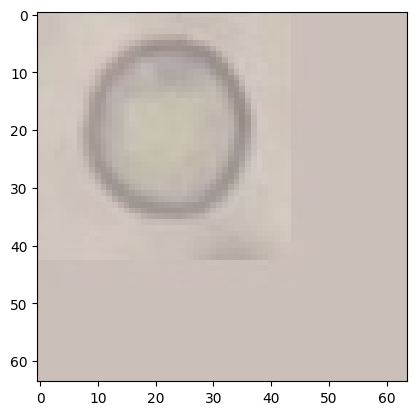

0


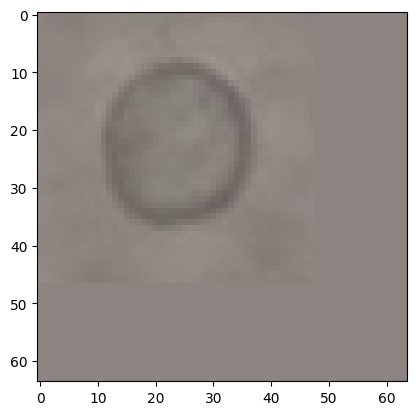

1


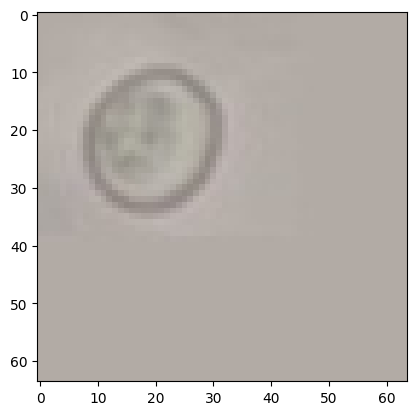

1


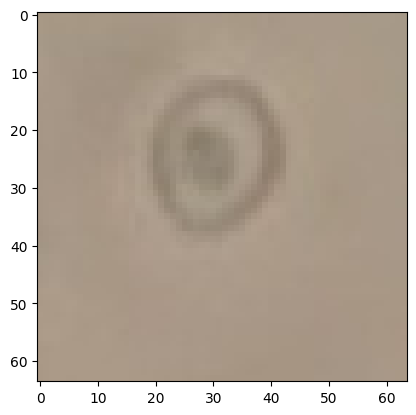

1


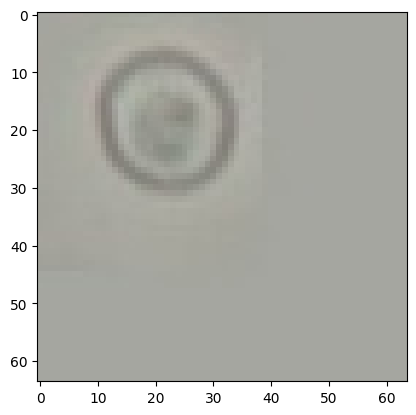

3


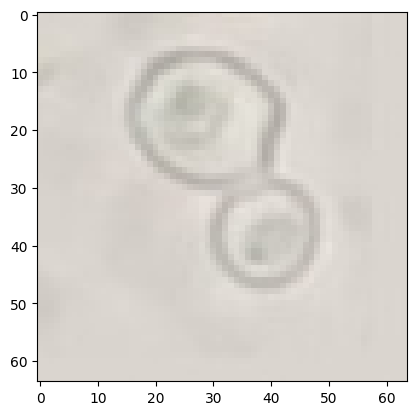

1


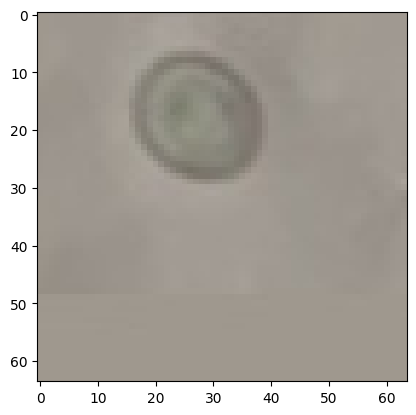

1


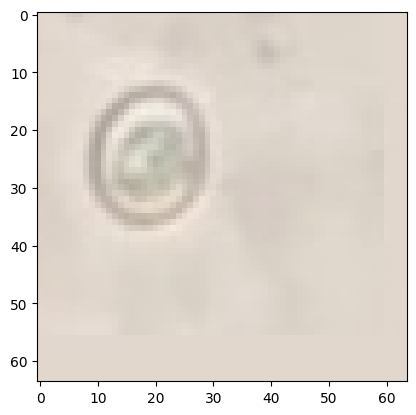

1


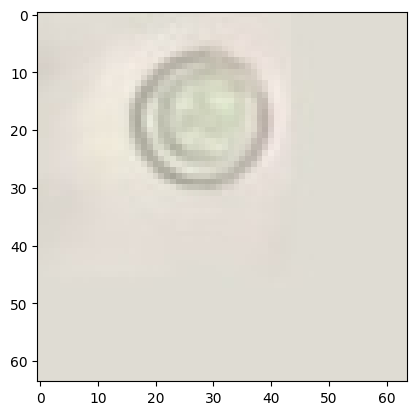

3


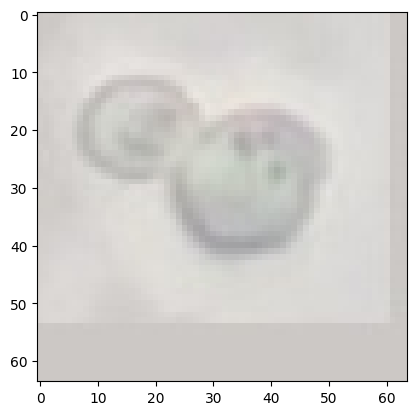

1


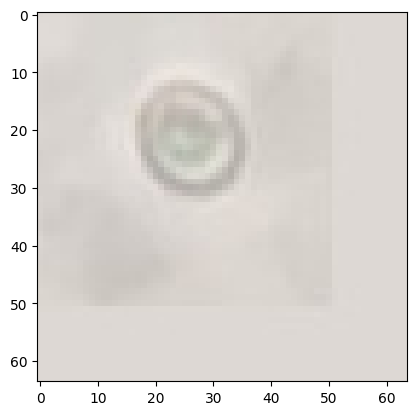

0


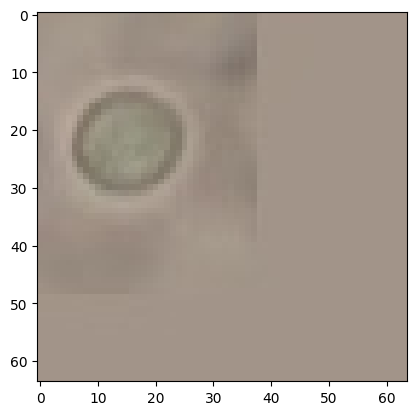

1


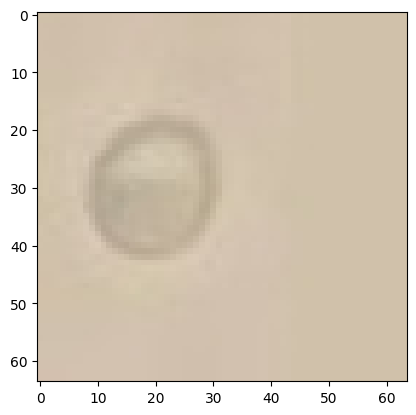

0


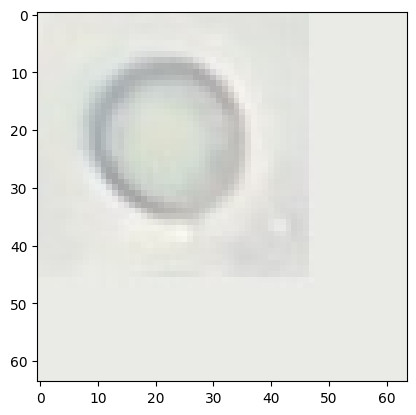

1


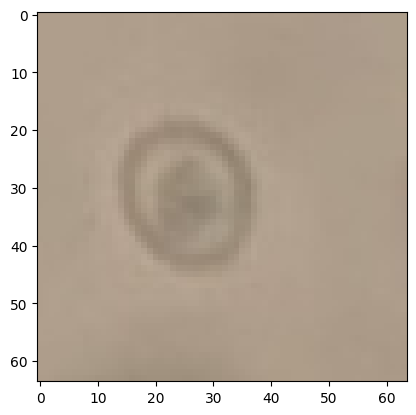

1


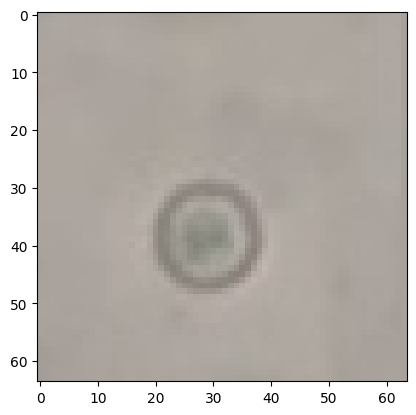

1


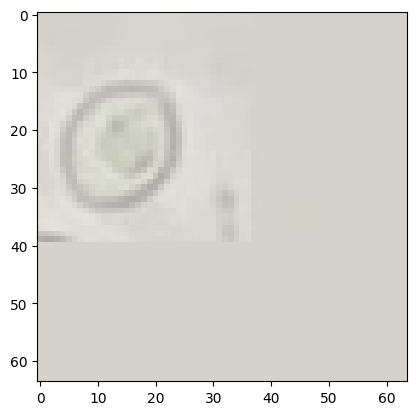

0


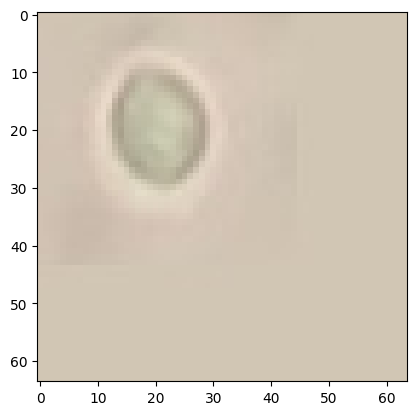

3


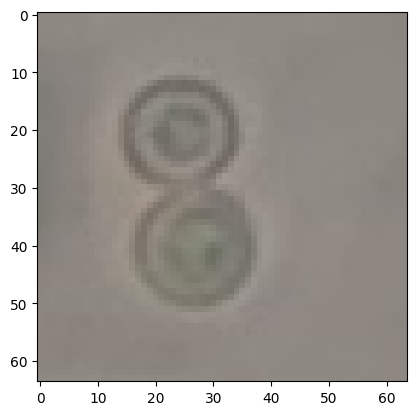

3


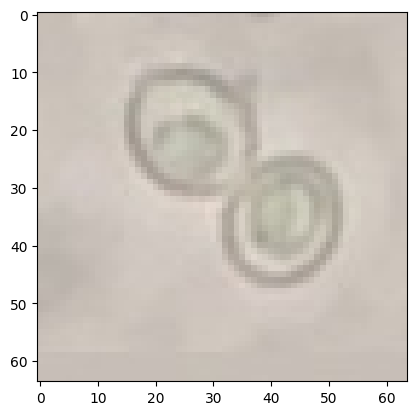

1


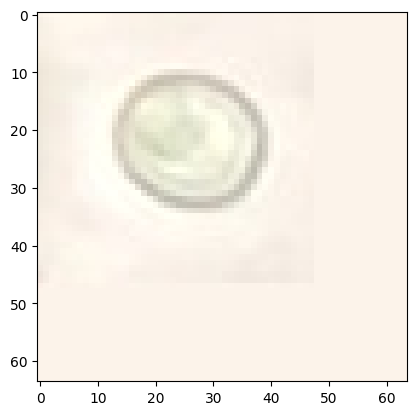

0


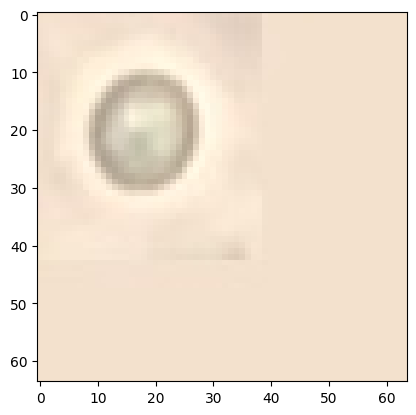

0


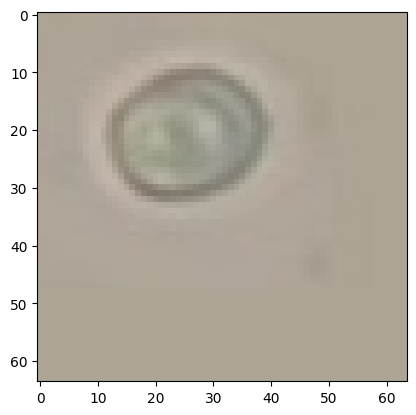

1


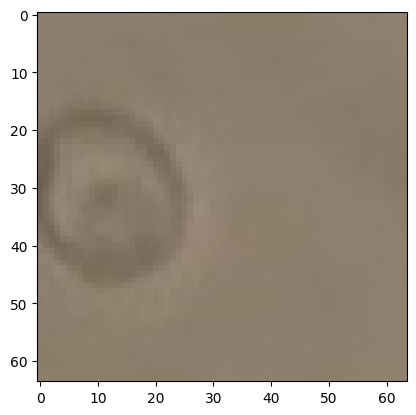

3


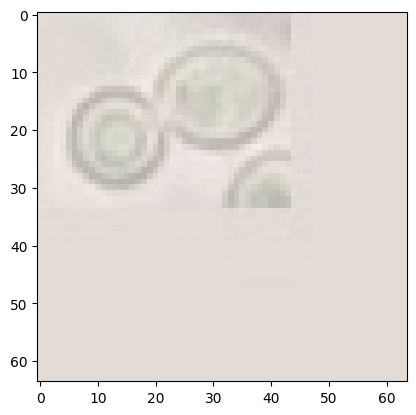

0


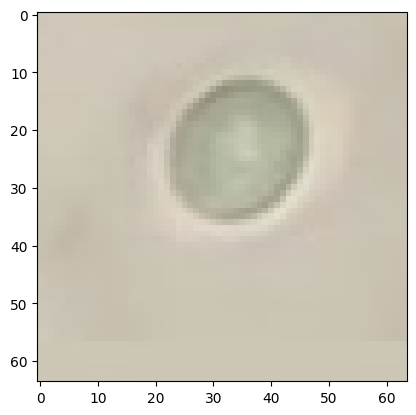

3


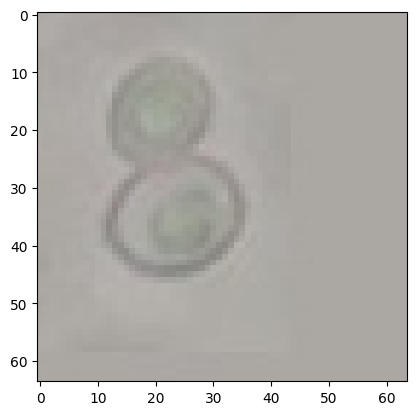

0


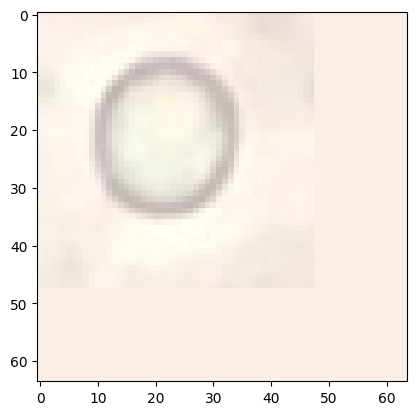

1


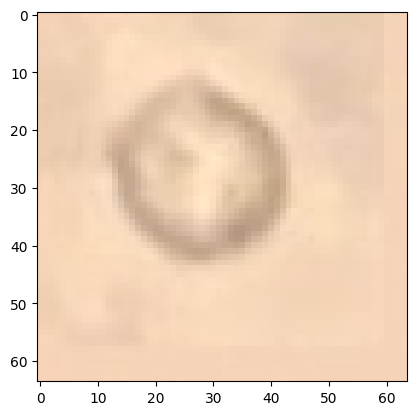

0


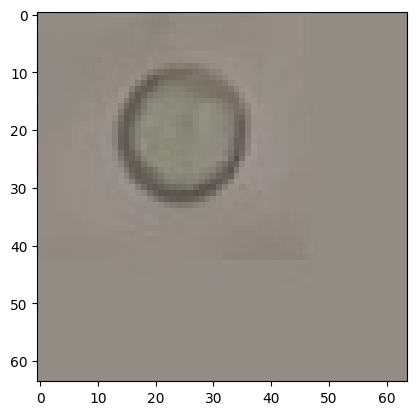

1


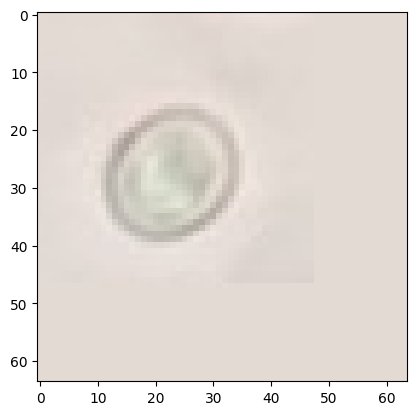

0


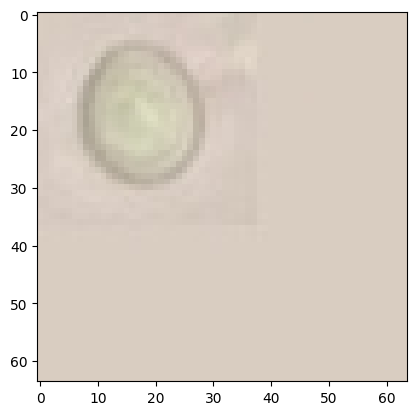

3


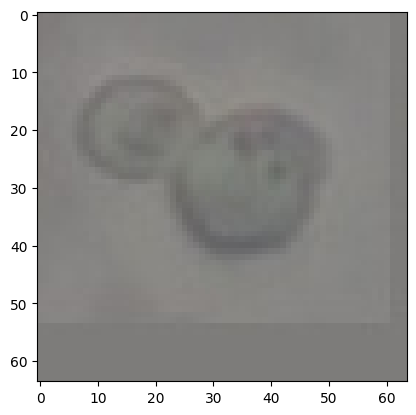

1


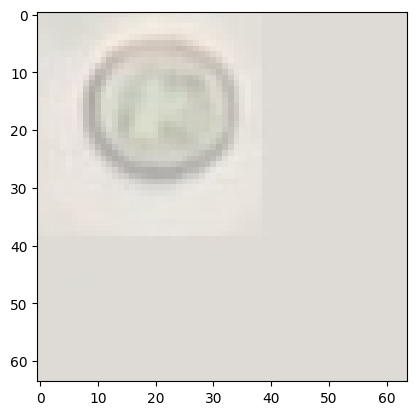

1


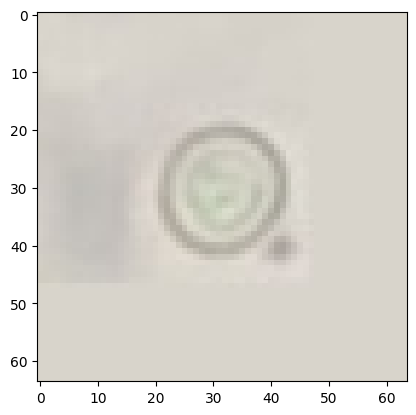

1


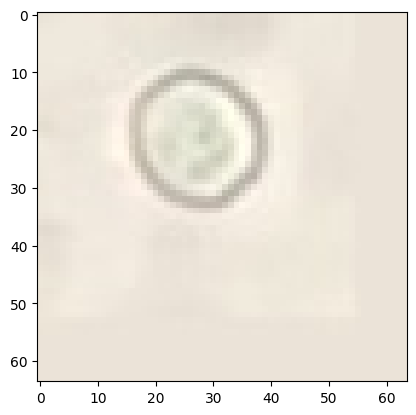

1


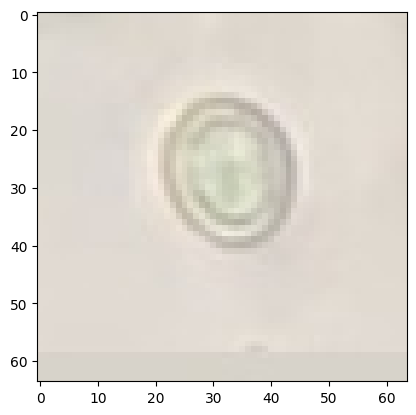

1


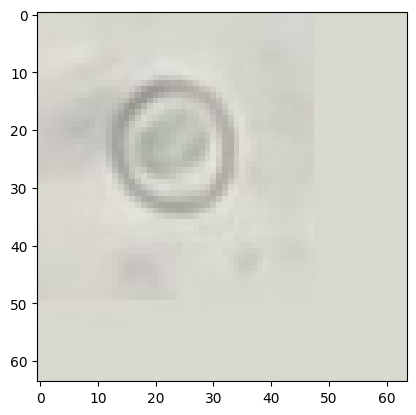

3


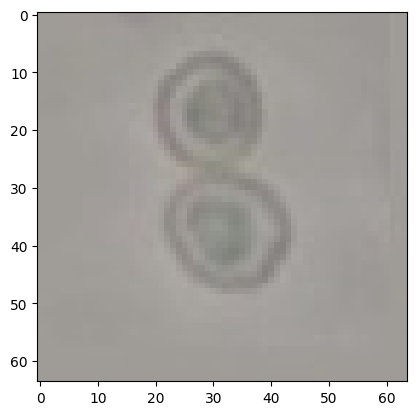

3


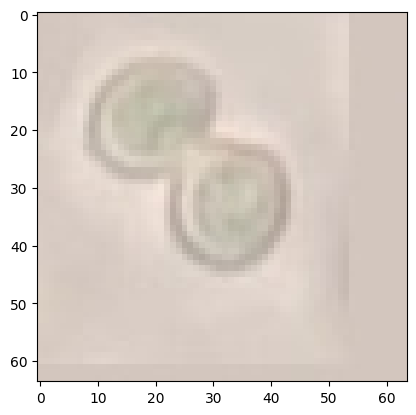

0


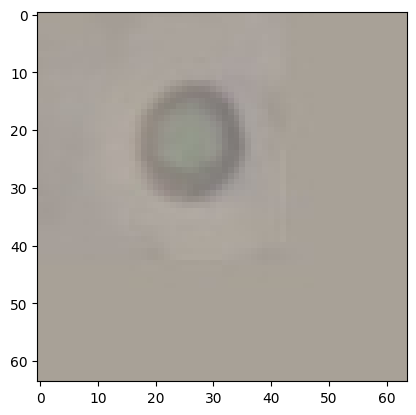

1


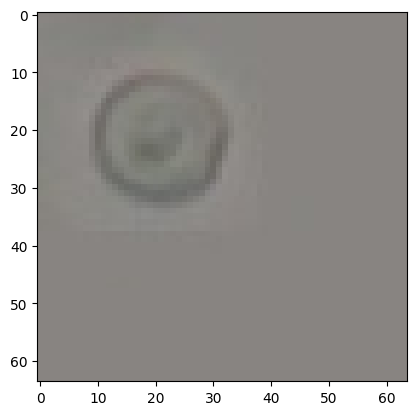

0


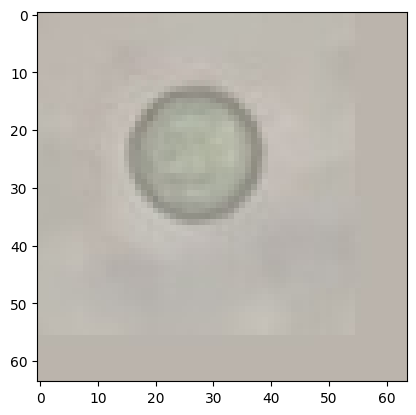

1


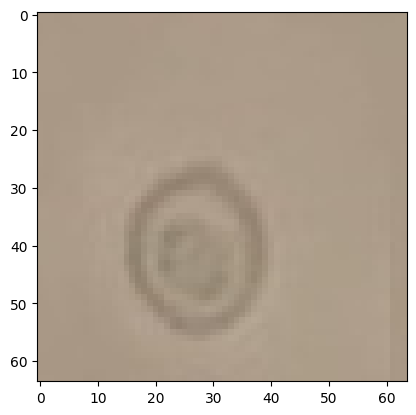

0


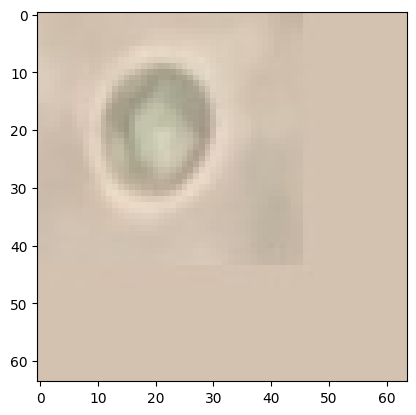

1


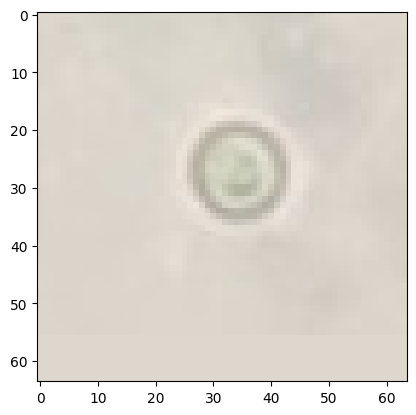

1


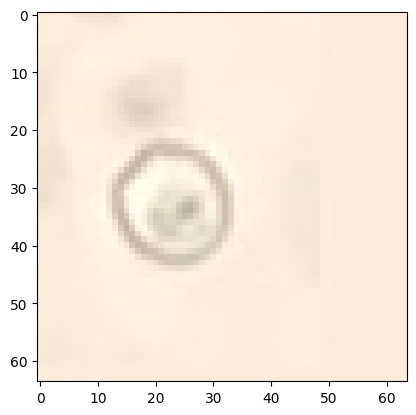

3


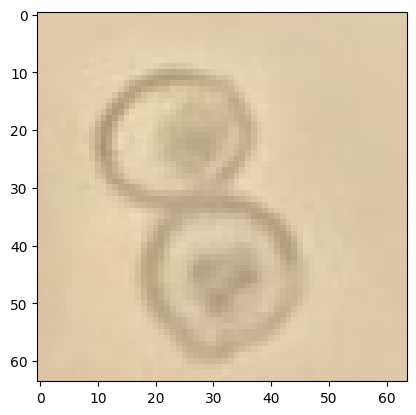

1


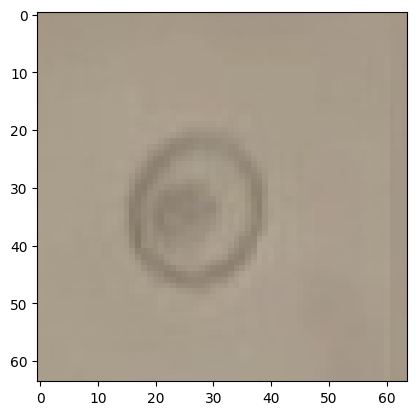

1


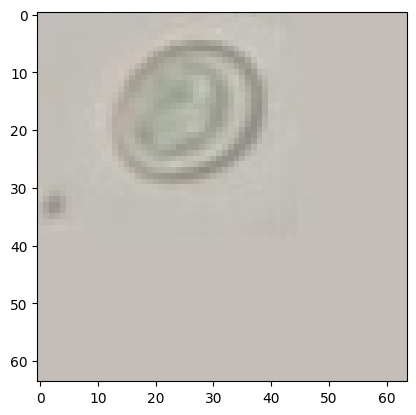

1


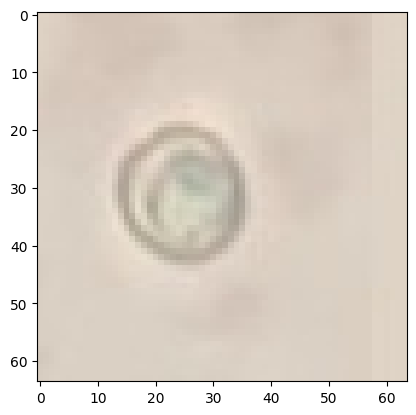

1


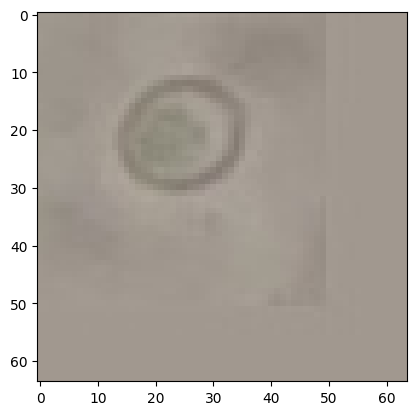

1


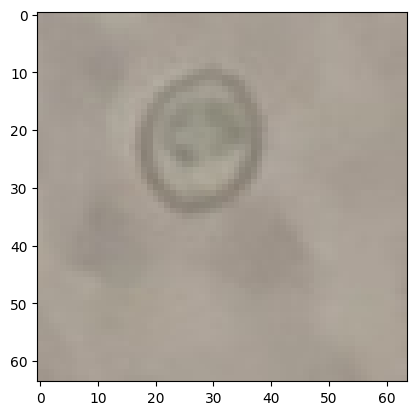

1


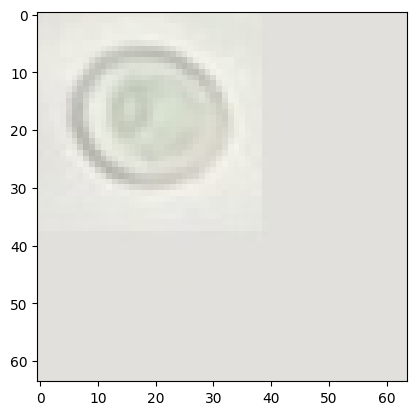

0


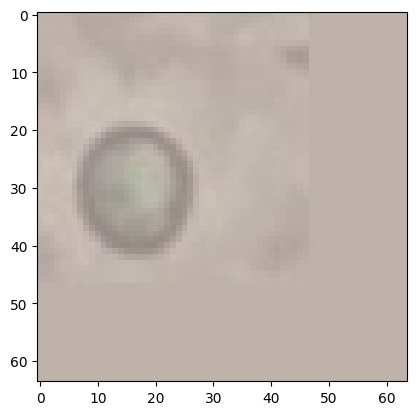

0


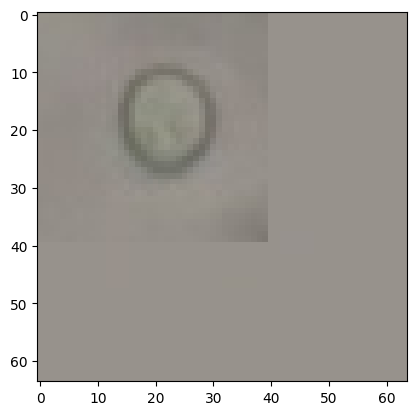

1


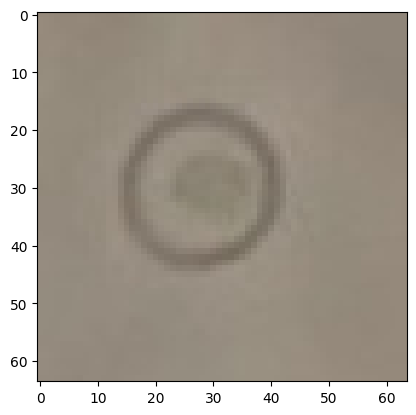

0


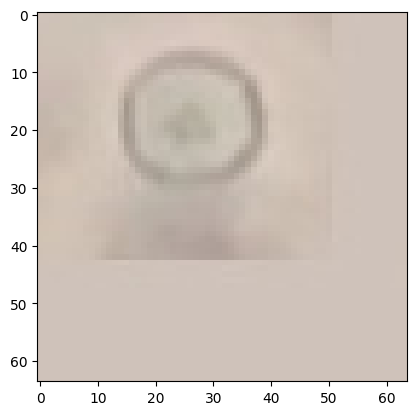

0


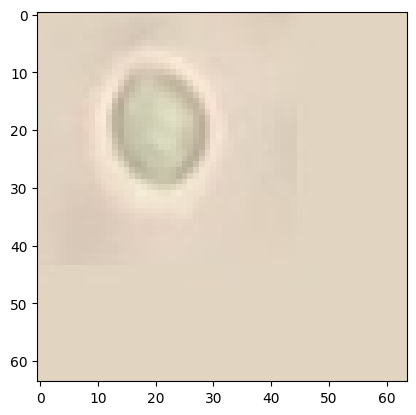

1


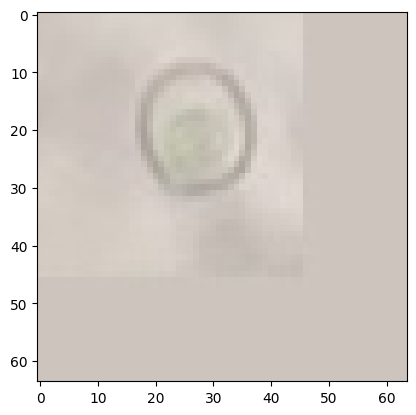

0


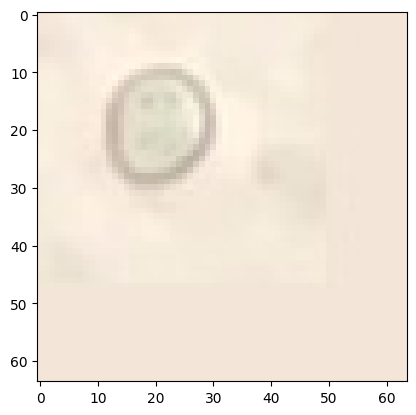

1


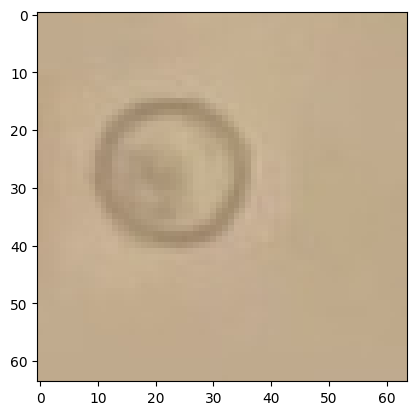

1


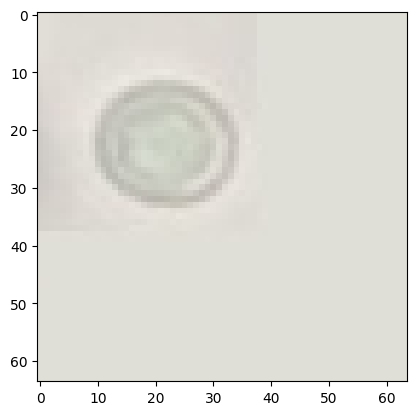

2


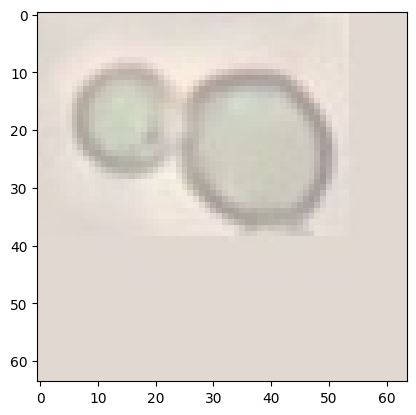

3


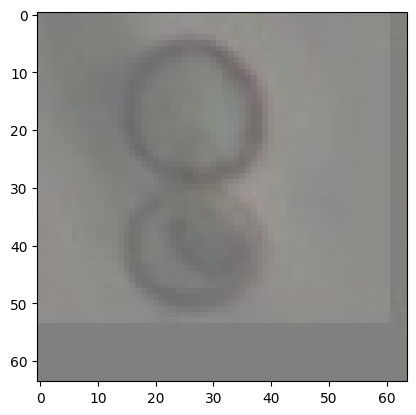

0


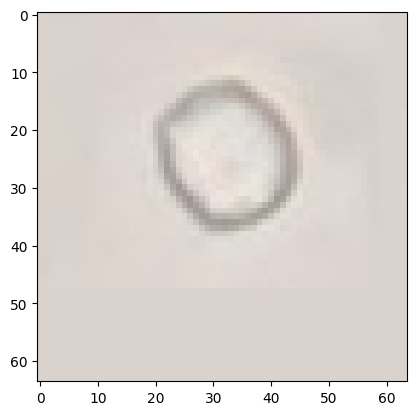

0


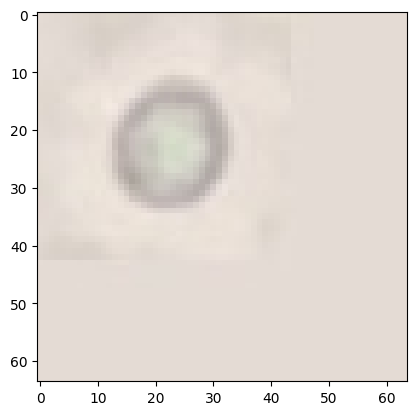

1


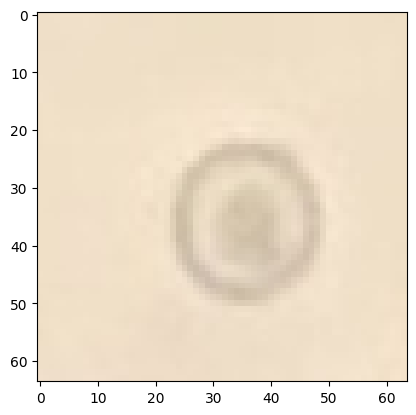

1


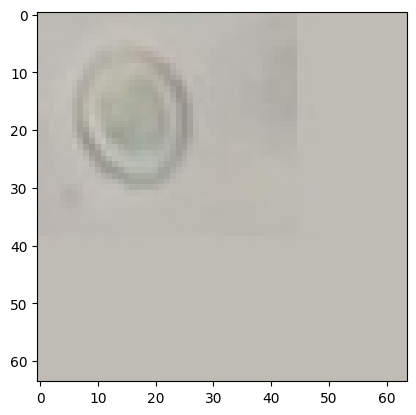

1


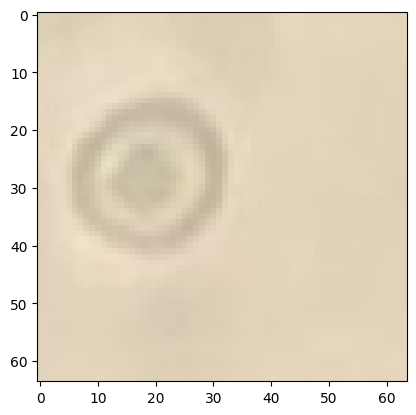

2


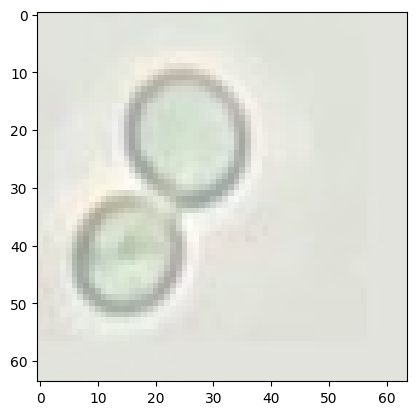

1


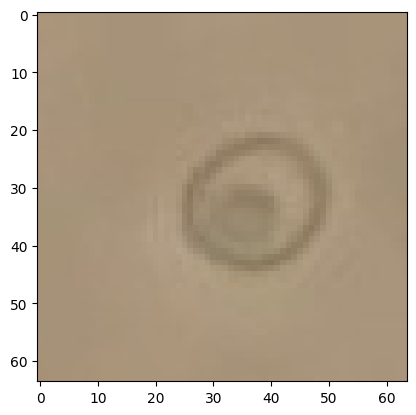

0


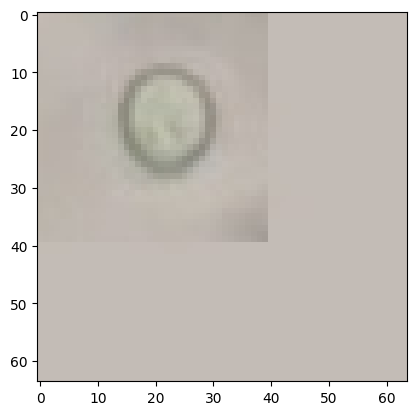

1


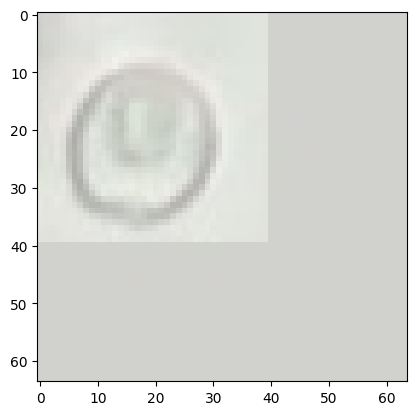

1


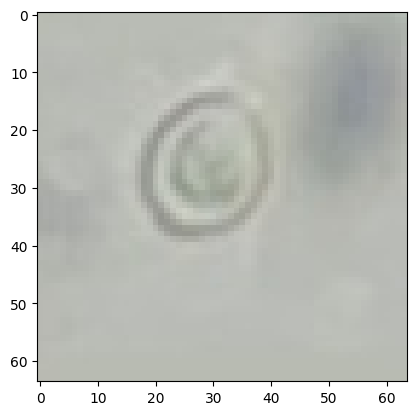

1


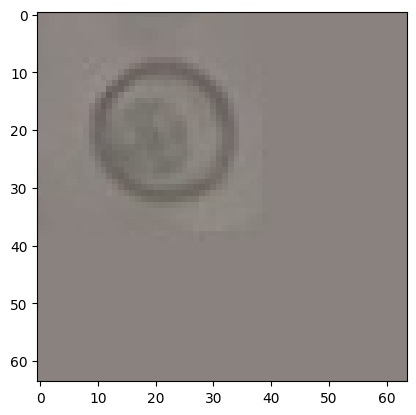

3


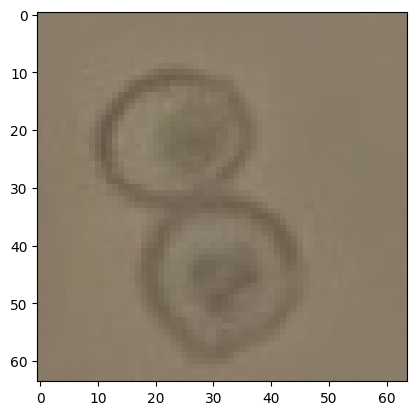

1


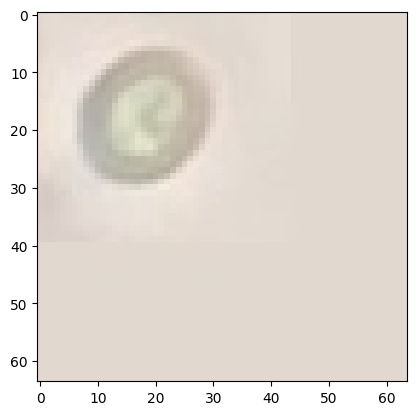

0


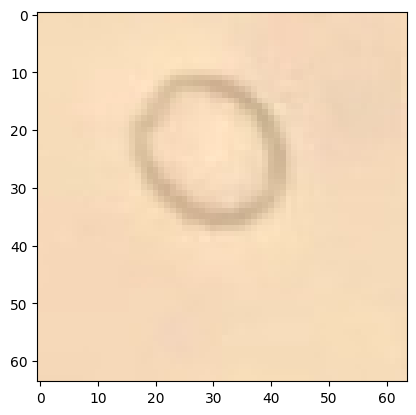

1


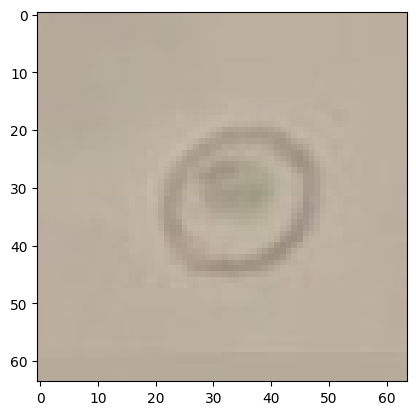

1


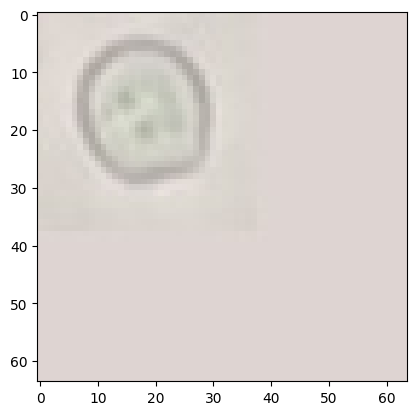

0


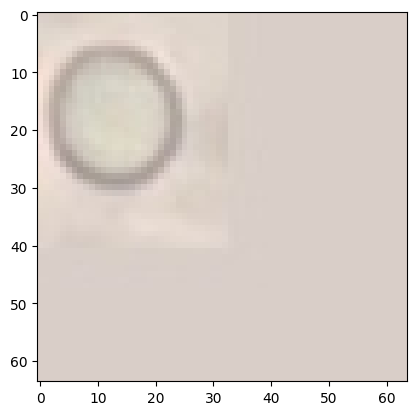

1


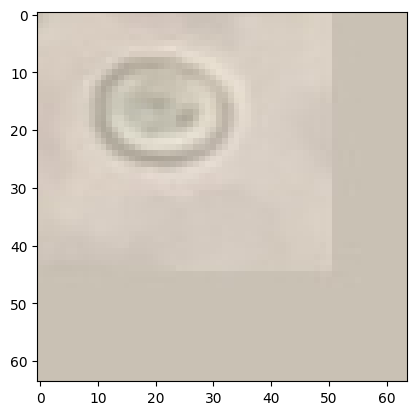

1


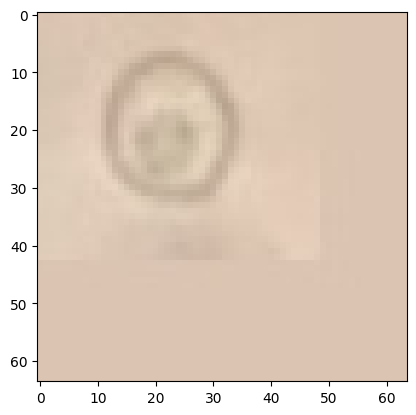

3


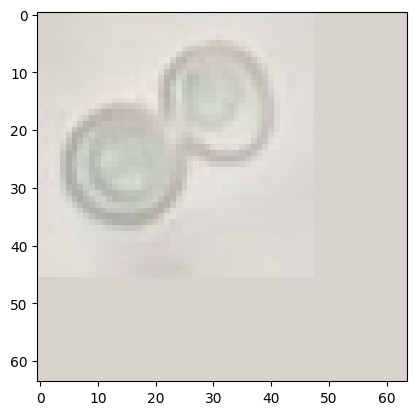

1


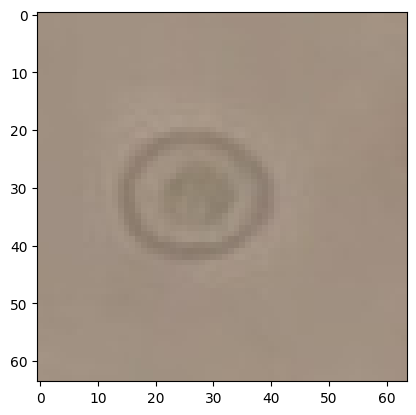

0


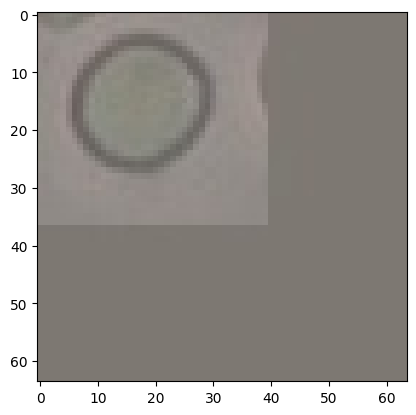

0


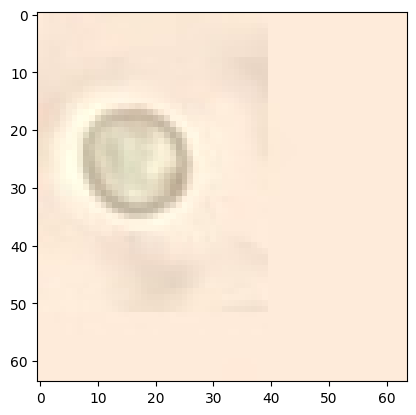

0


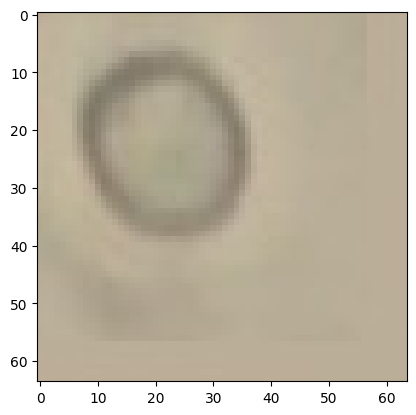

1


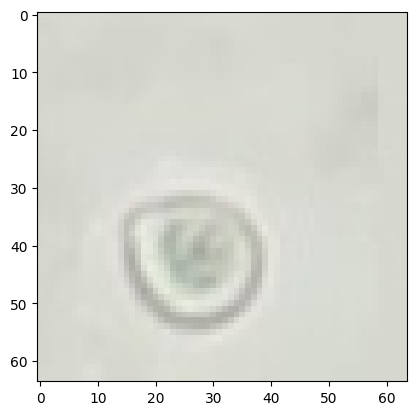

0


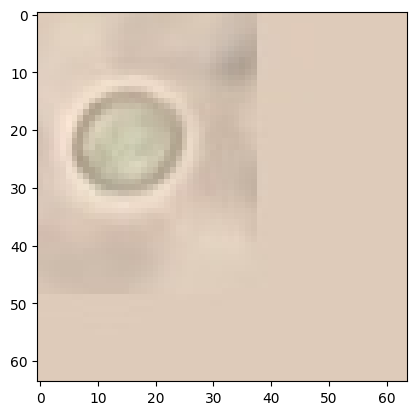

0


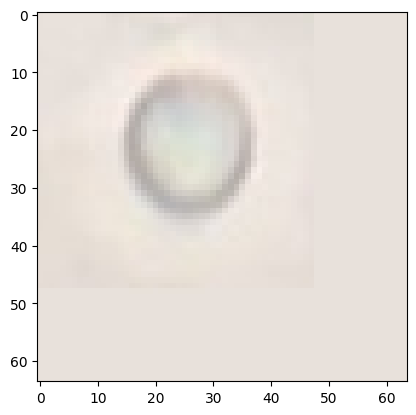

1


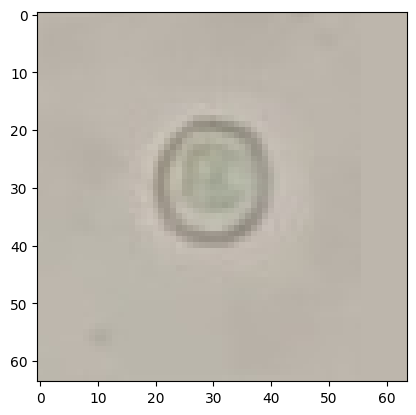

0


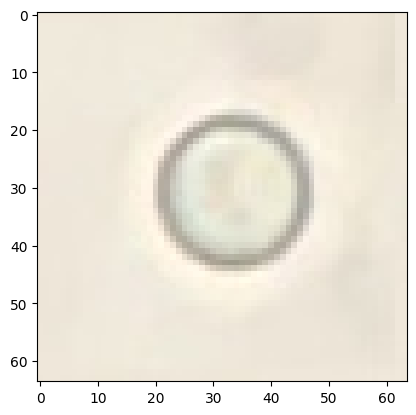

3


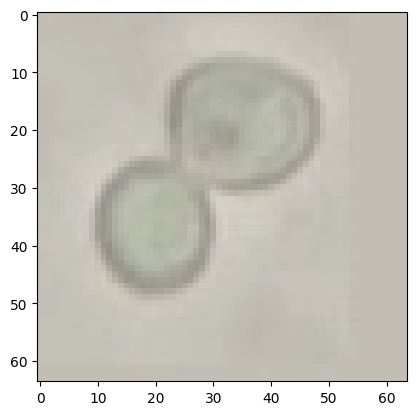

0


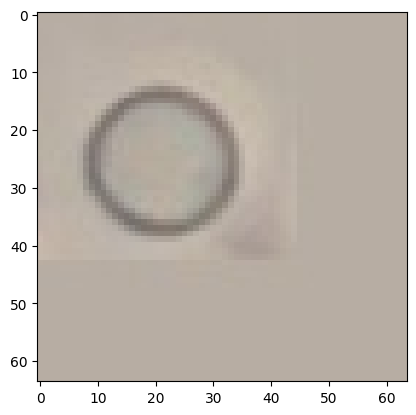

1


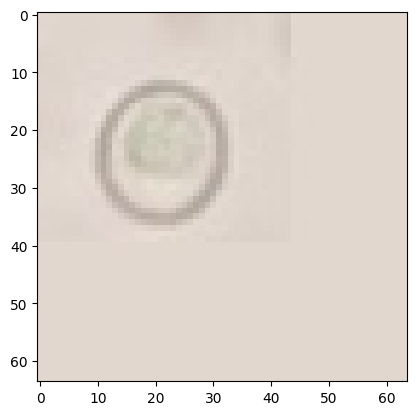

1


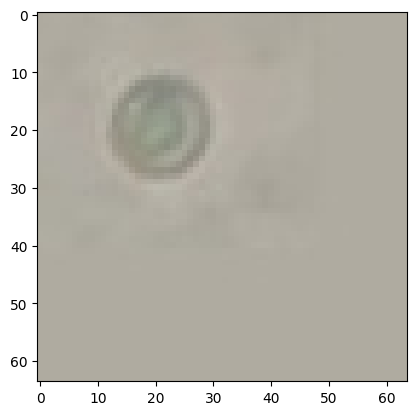

1


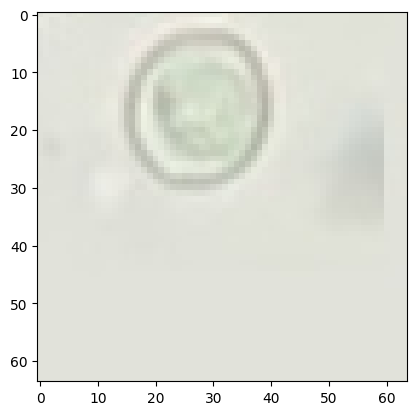

3


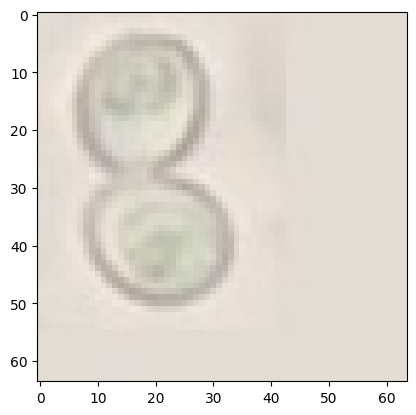

0


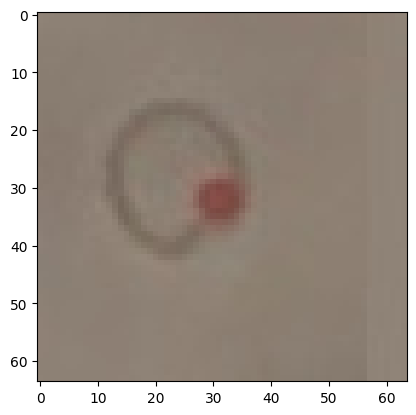

1


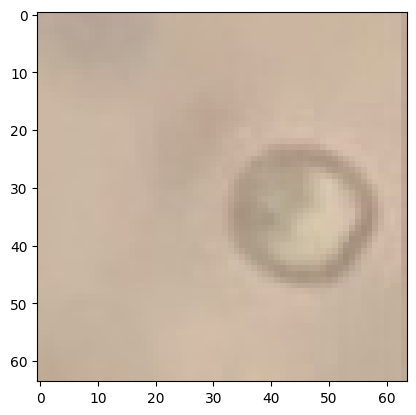

1


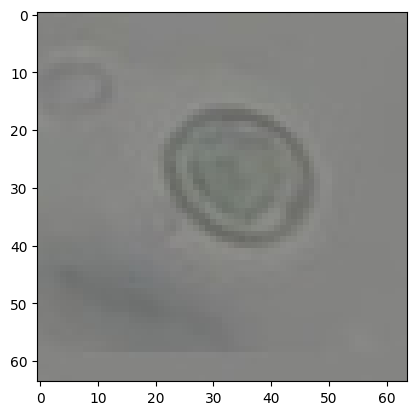

1


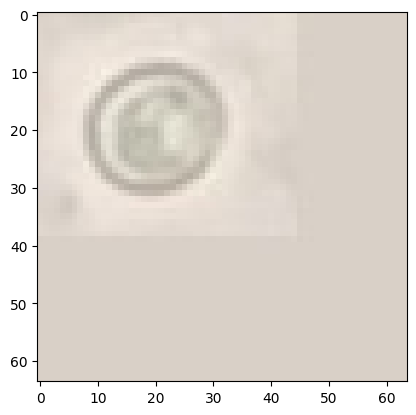

1


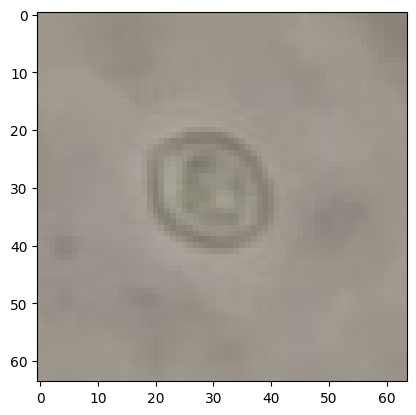

1


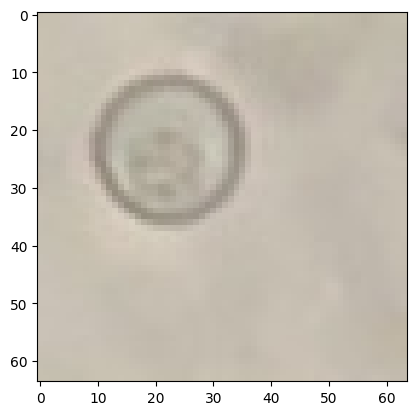

0


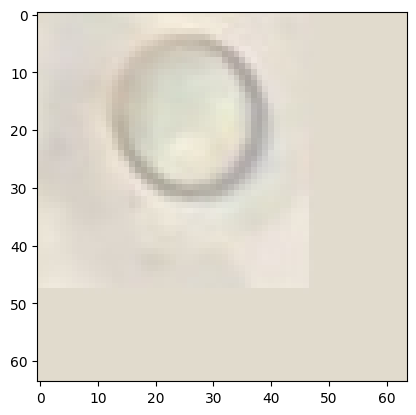

1


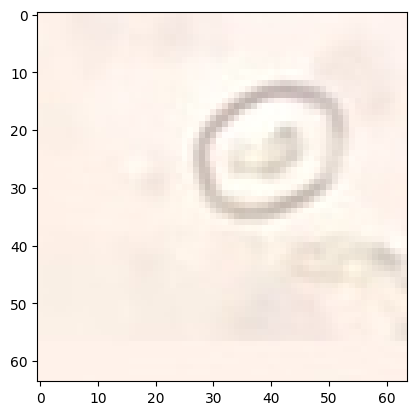

0


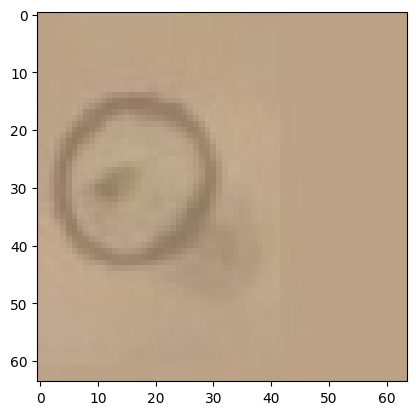

1


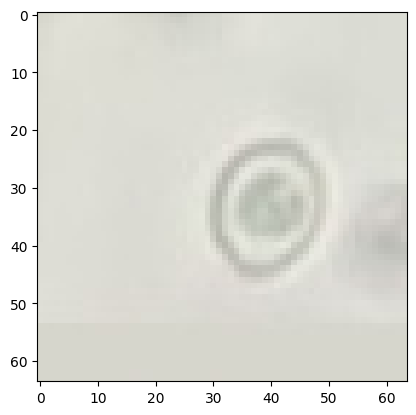

0


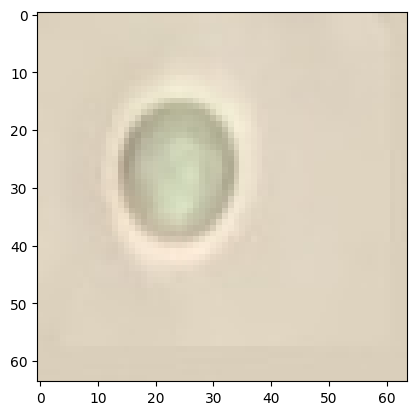

2


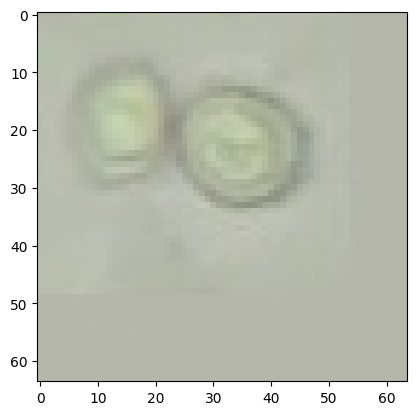

1


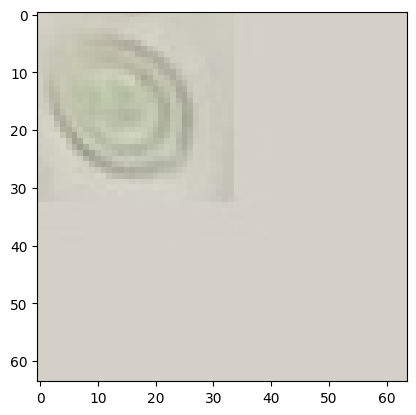

0


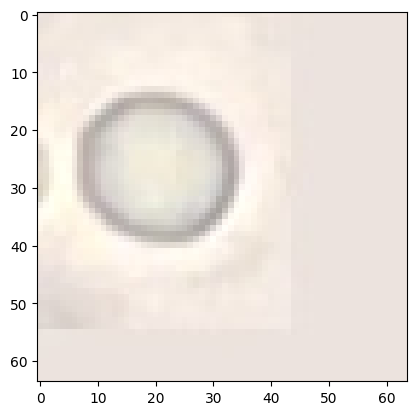

1


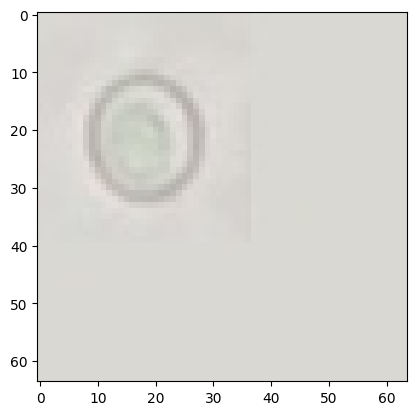

3


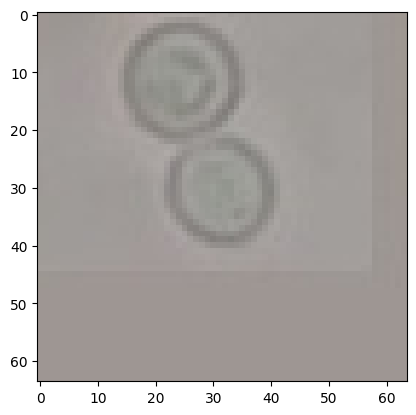

1


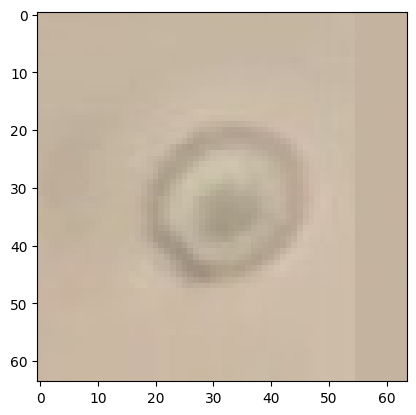

1


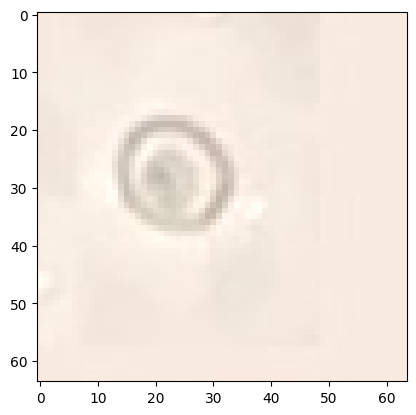

2


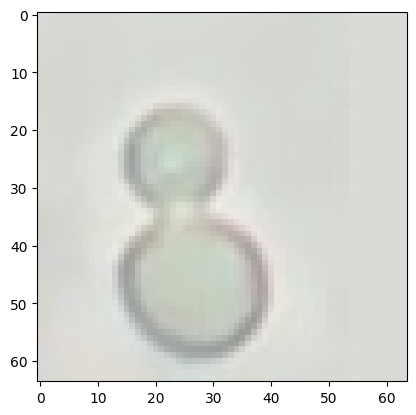

1


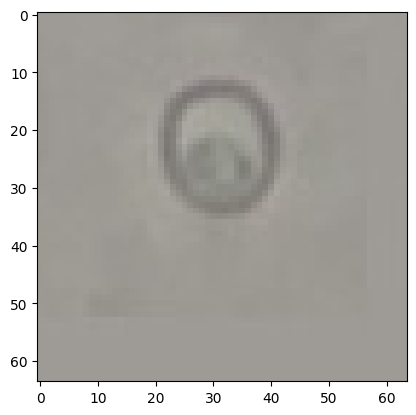

1


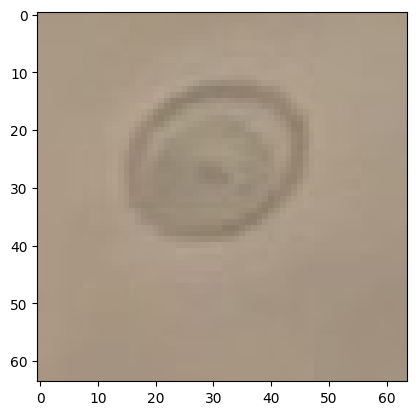

0


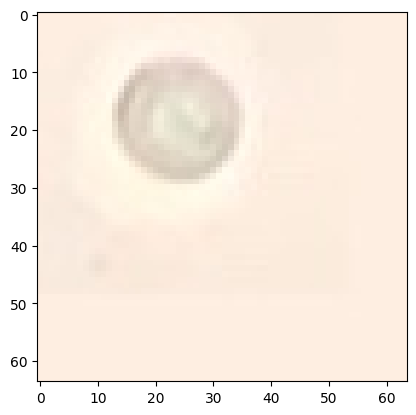

1


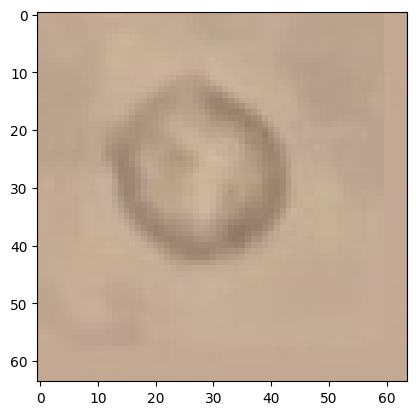

1


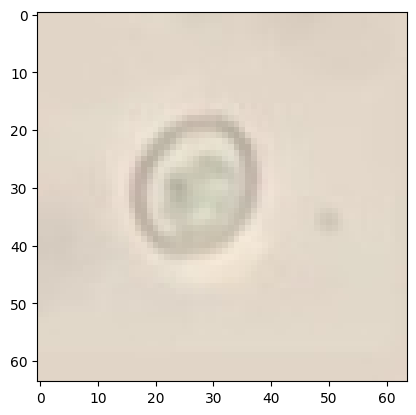

1


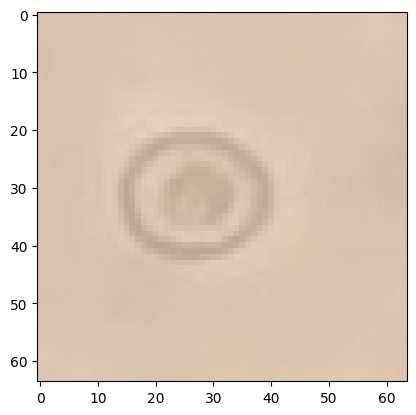

0


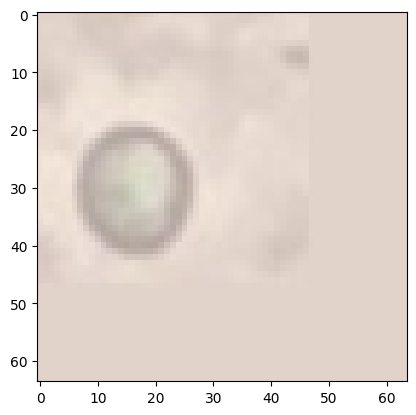

3


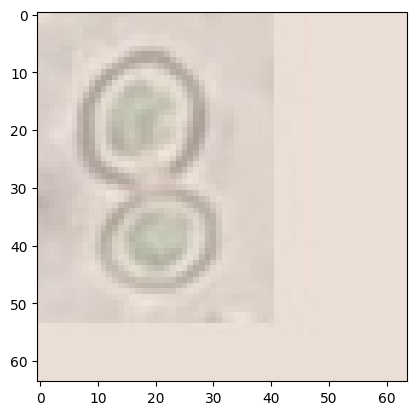

0


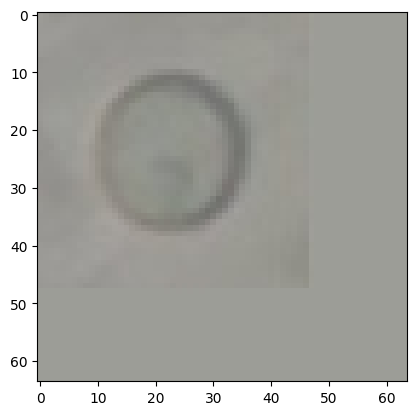

1


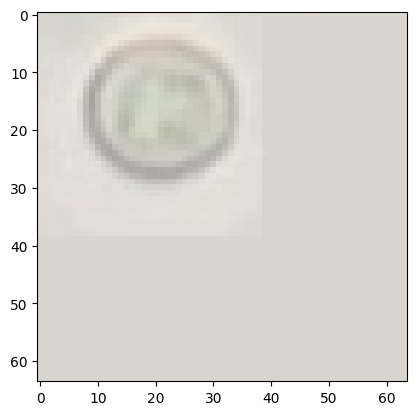

1


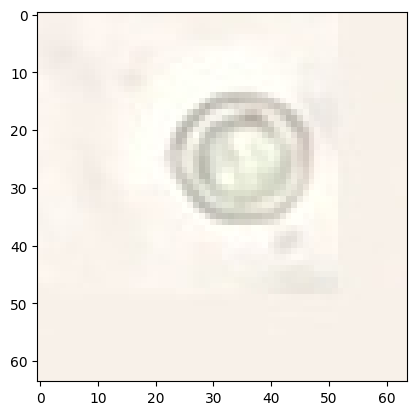

1


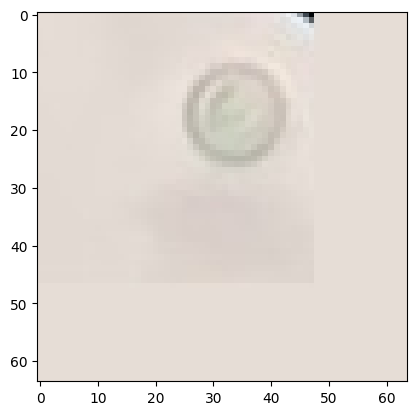

1


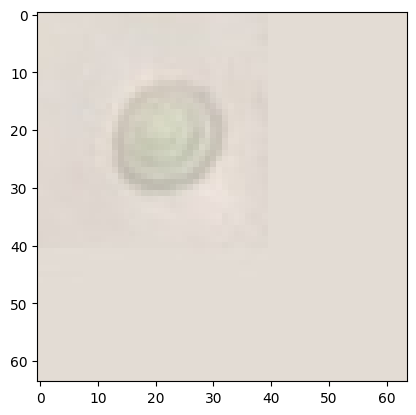

1


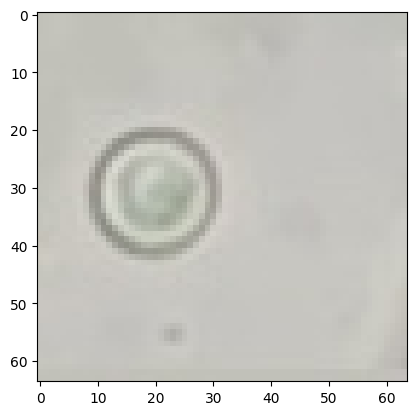

1


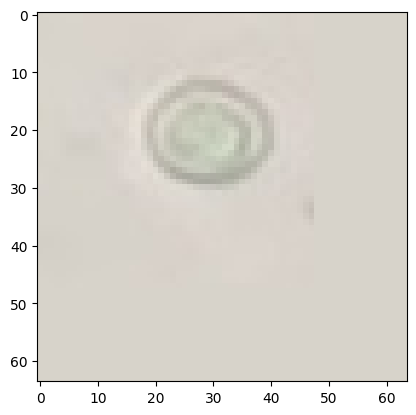

1


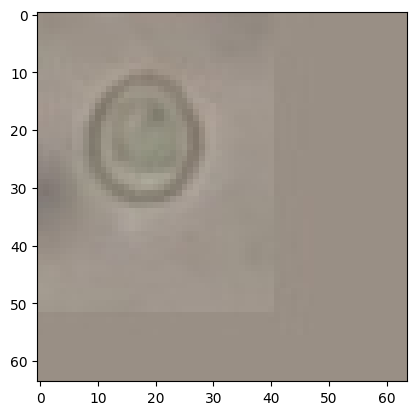

1


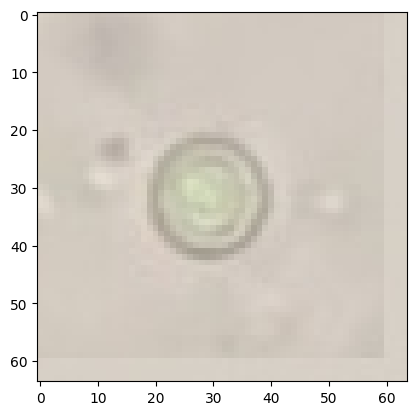

0


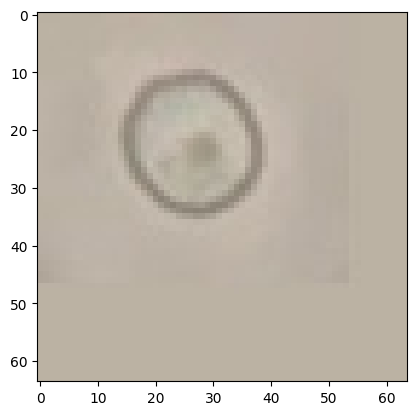

1


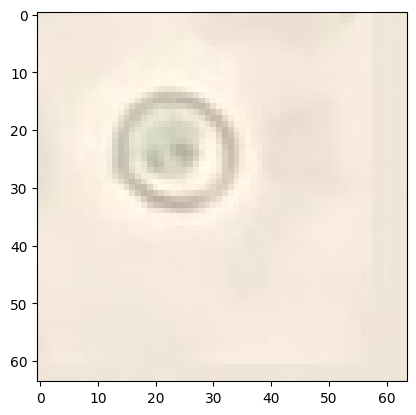

3


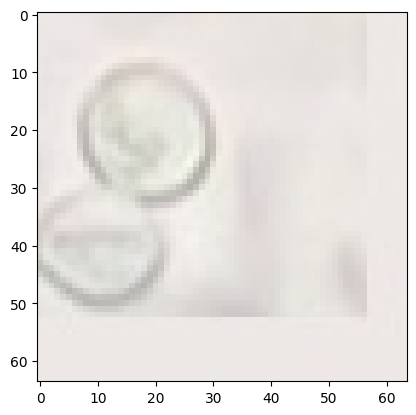

1


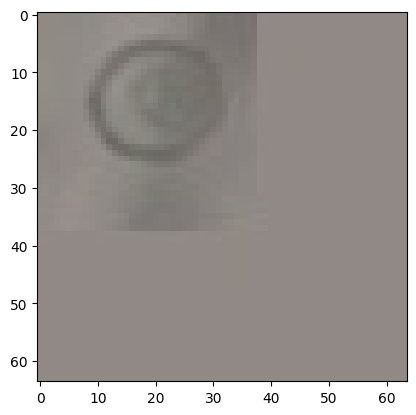

1


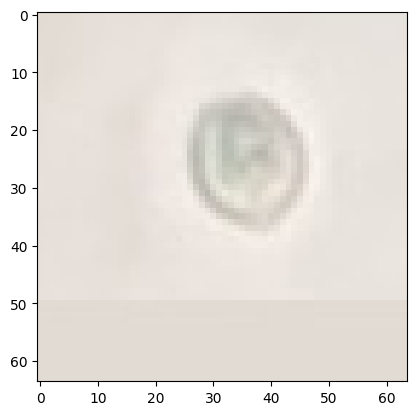

1


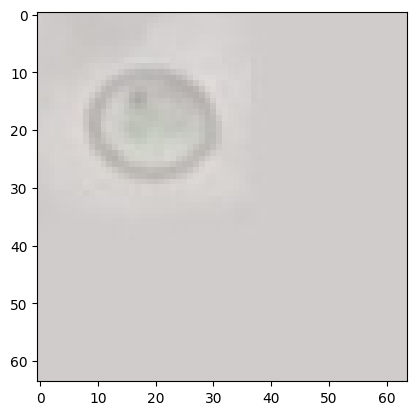

1


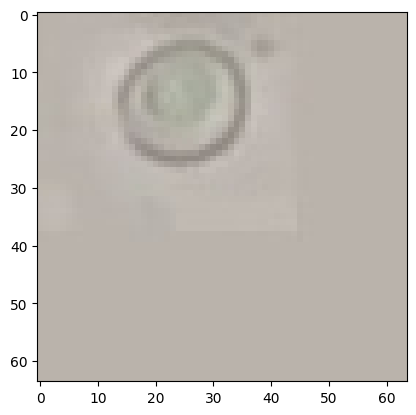

0


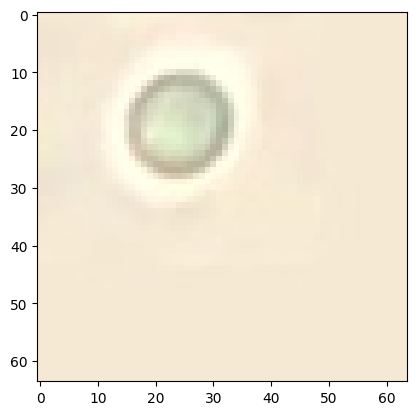

1


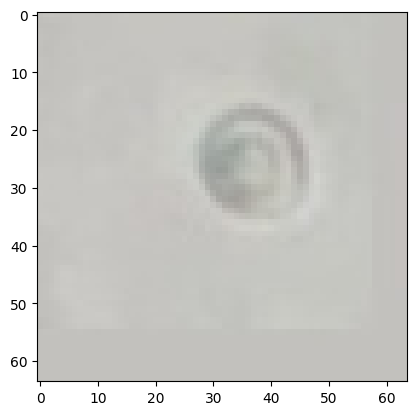

1


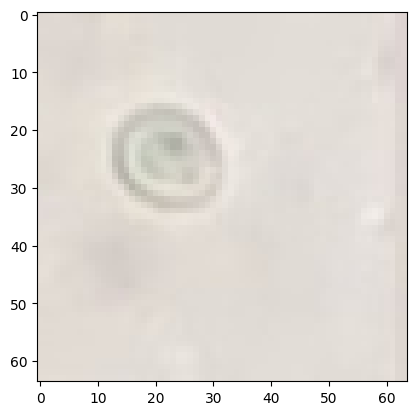

1


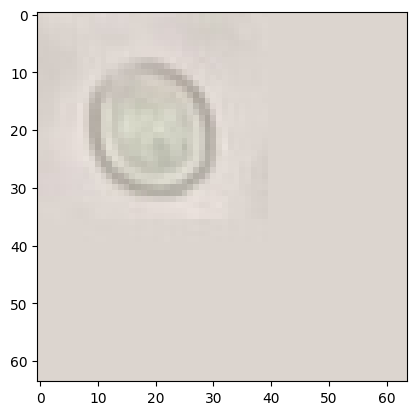

1


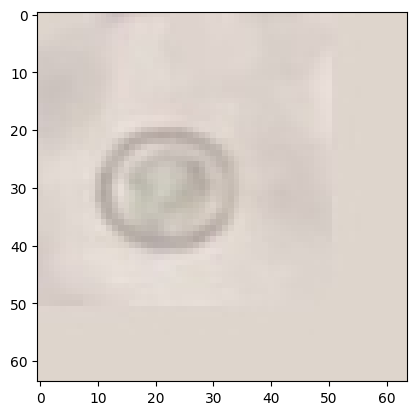

1


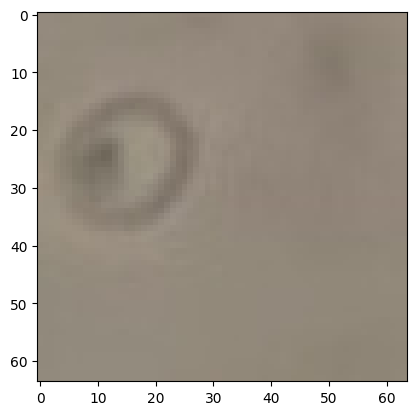

1


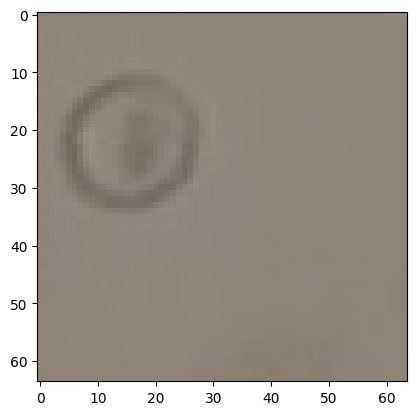

0


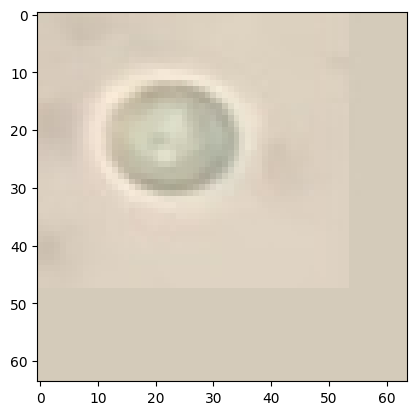

3


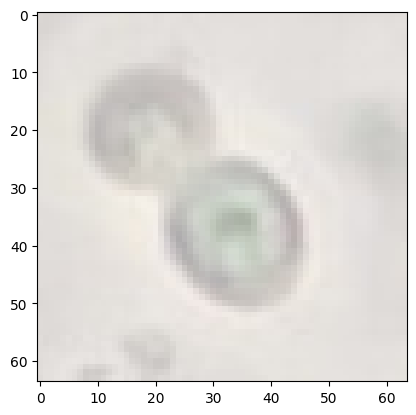

3


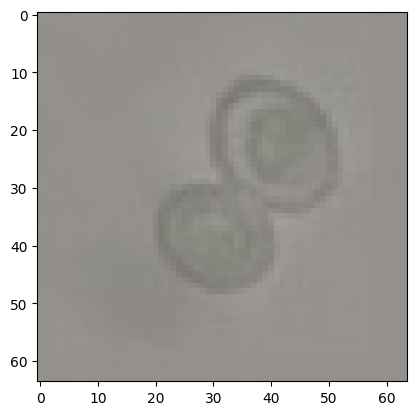

3


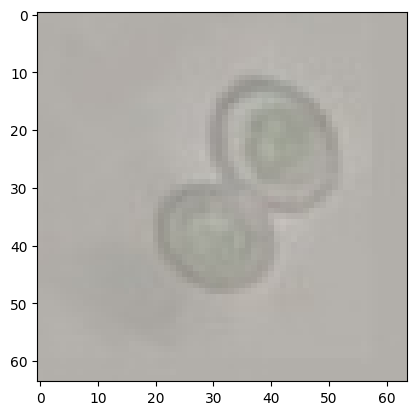

0


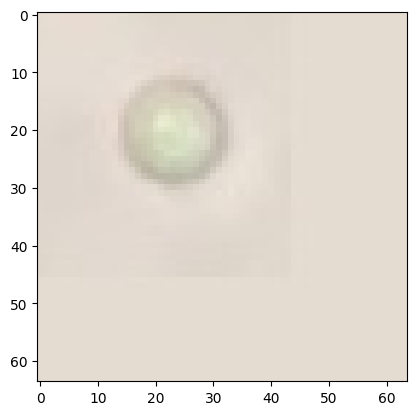

0


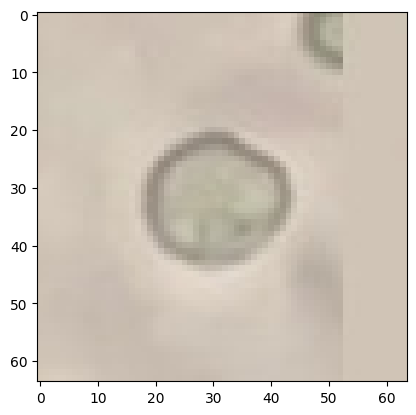

0


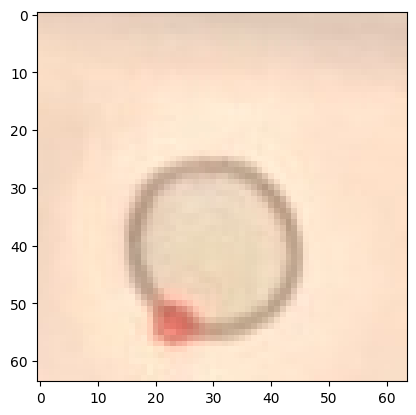

0


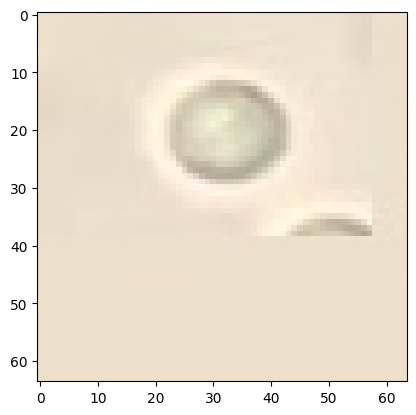

1


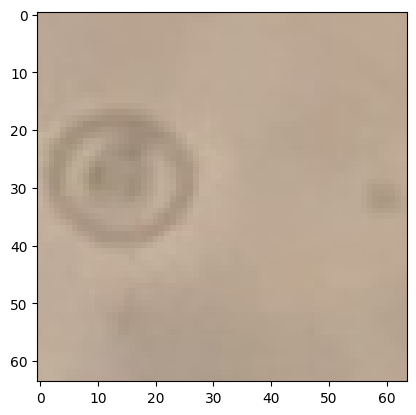

3


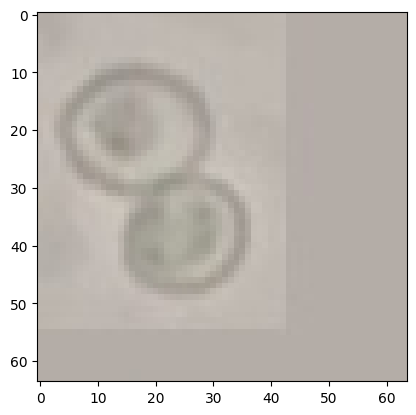

0


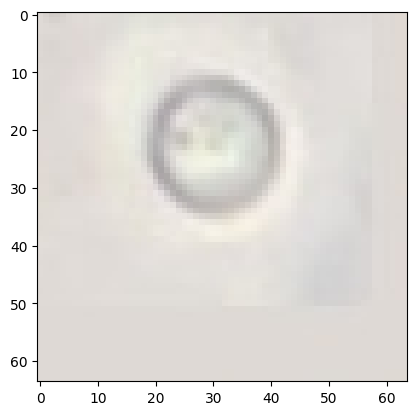

1


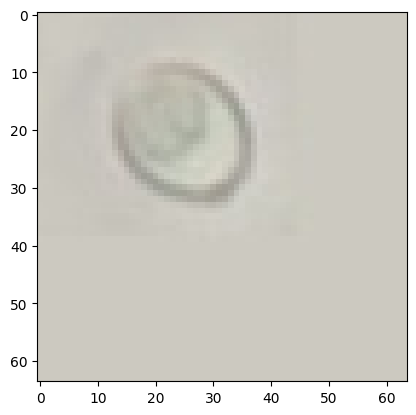

1


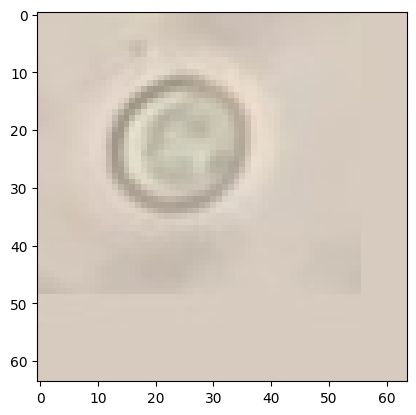

1


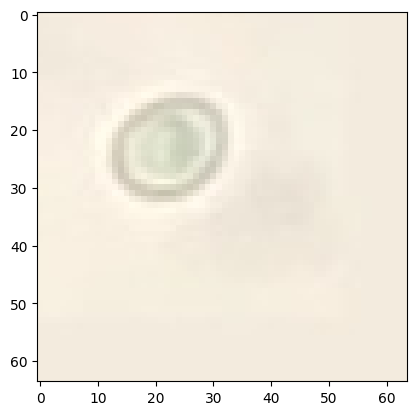

1


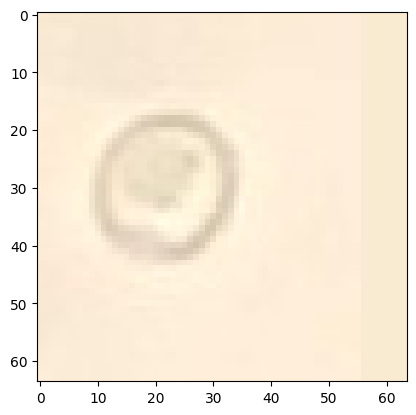

1


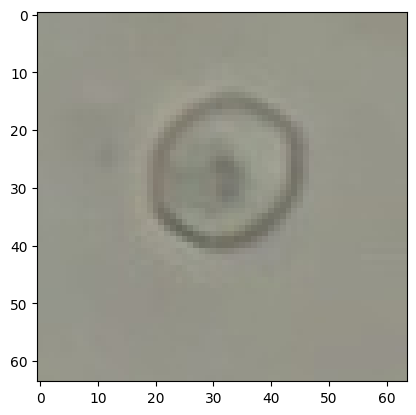

1


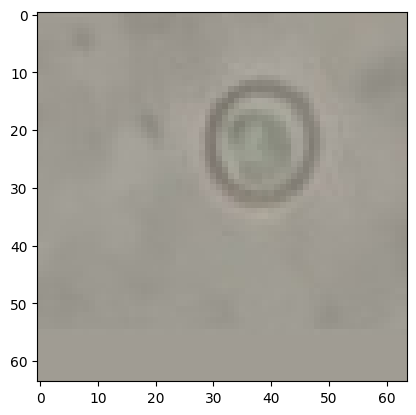

0


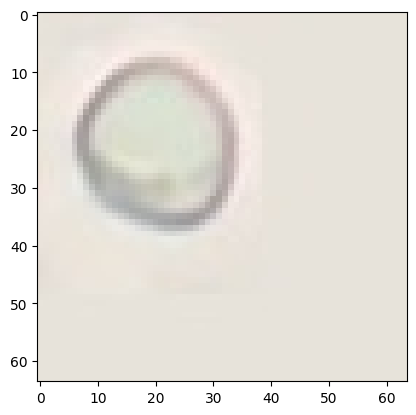

2


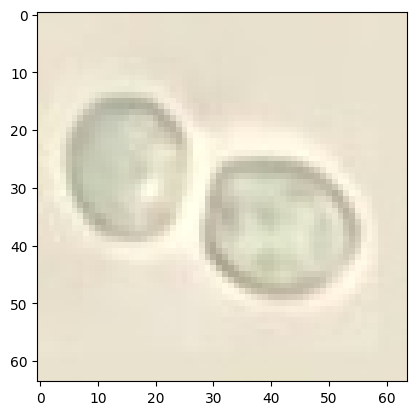

1


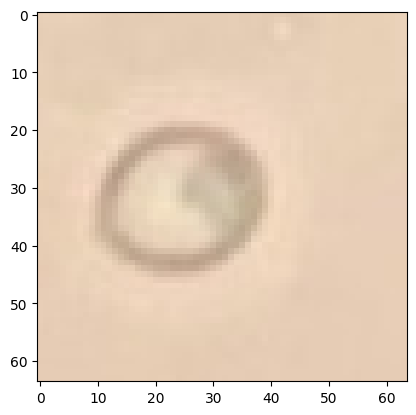

1


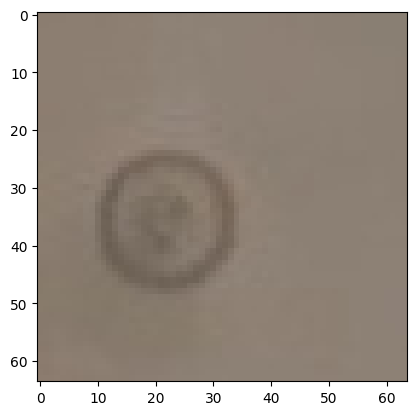

0


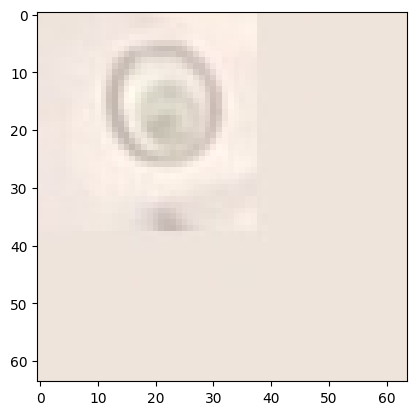

3


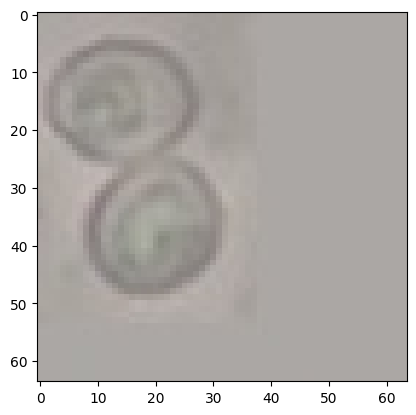

1


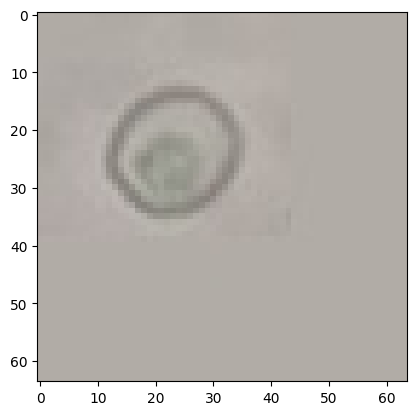

0


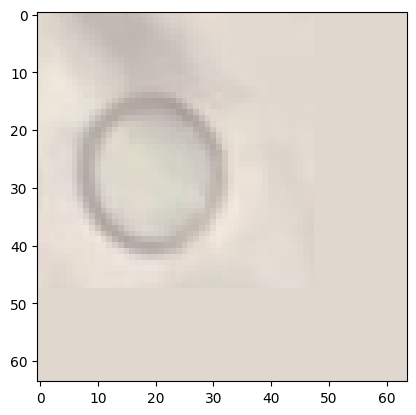

1


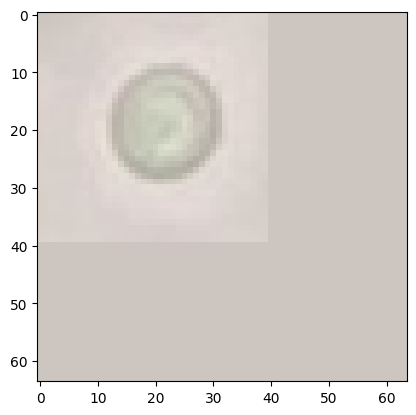

1


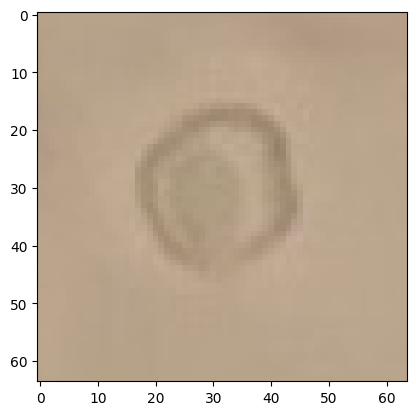

1


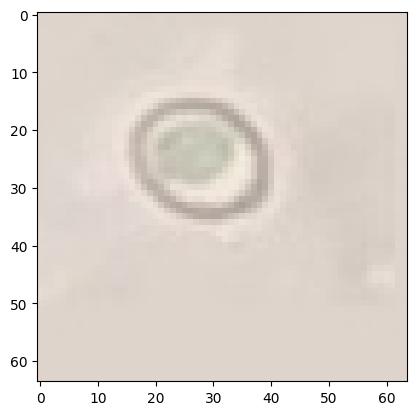

1


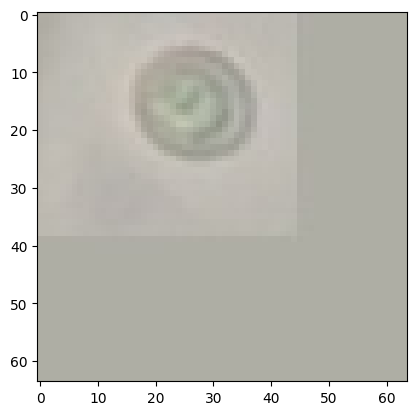

1


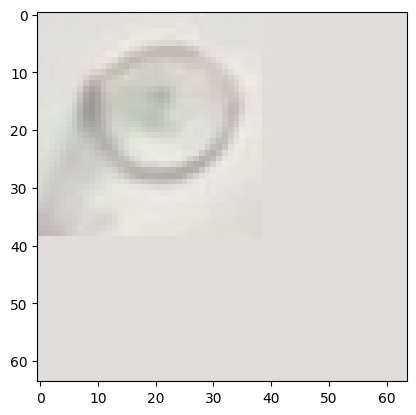

0


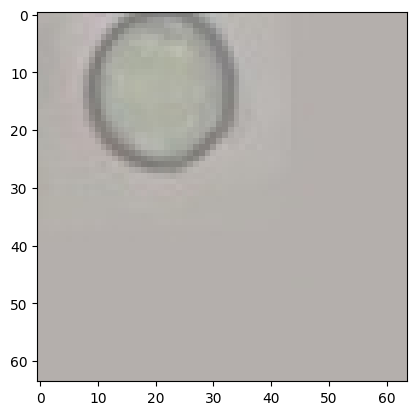

1


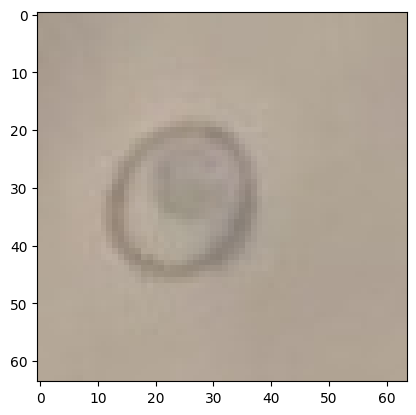

1


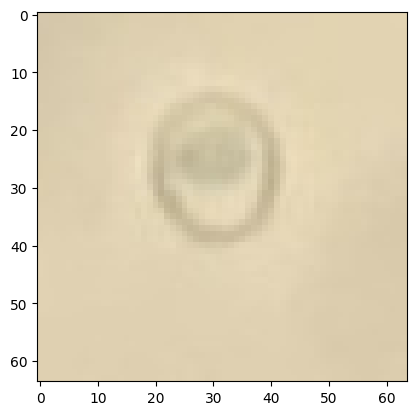

3


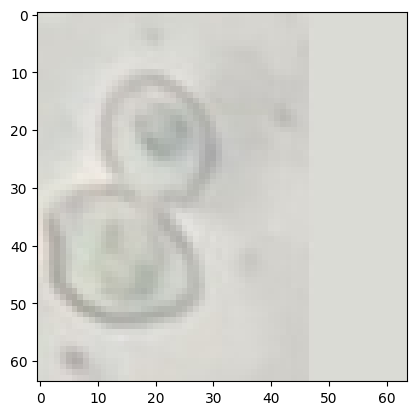

0


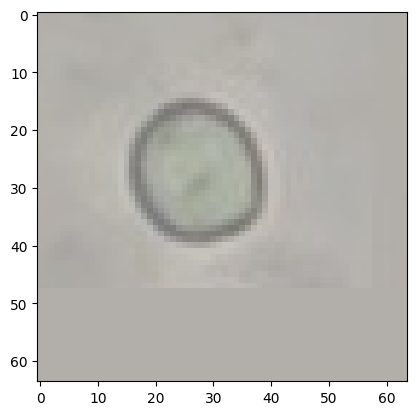

1


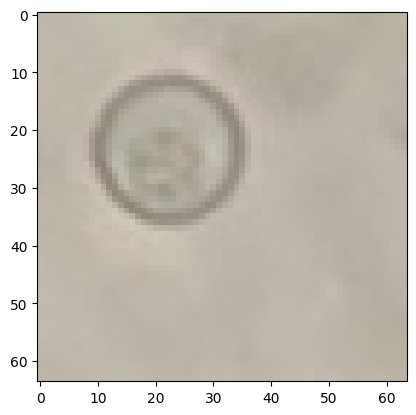

0


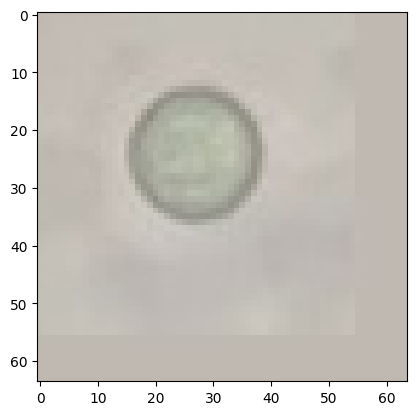

1


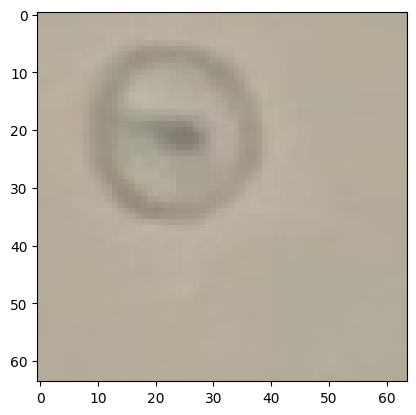

1


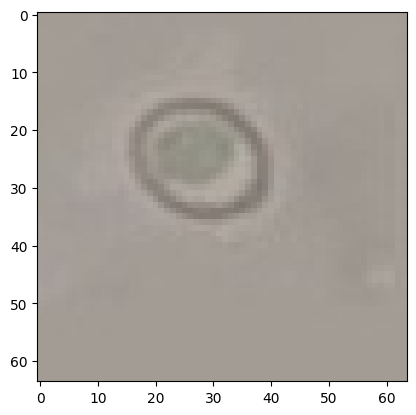

1


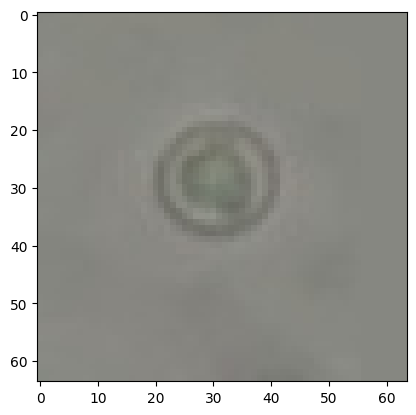

1


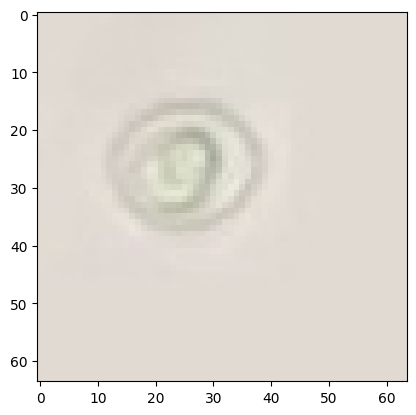

0


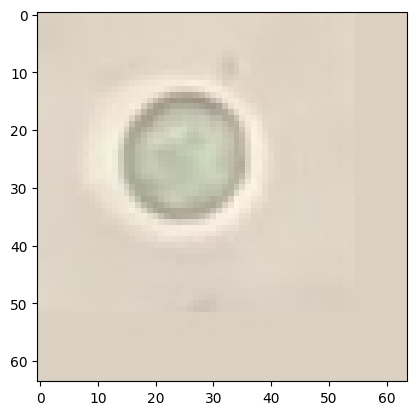

1


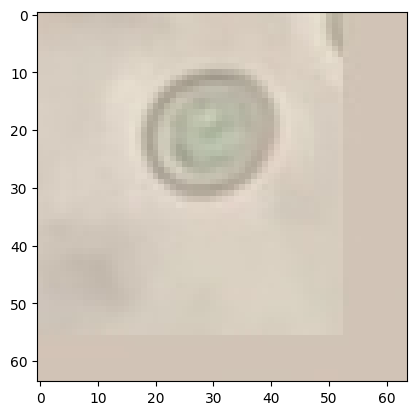

1


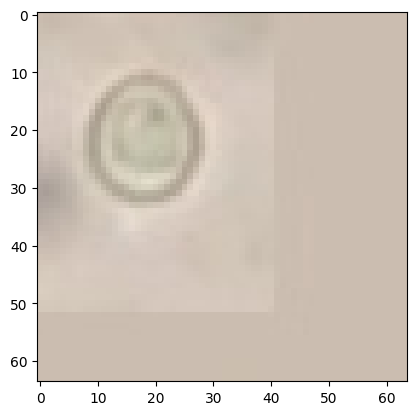

1


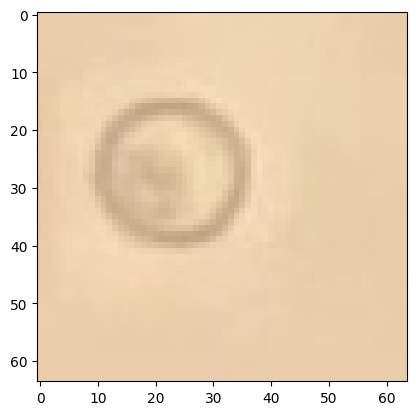

1


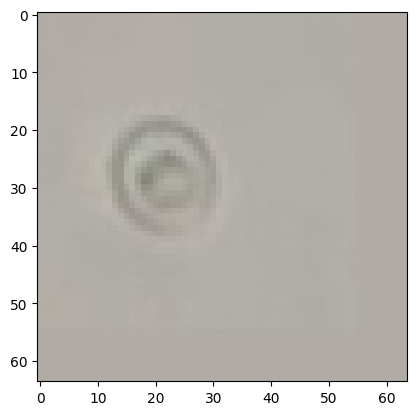

1


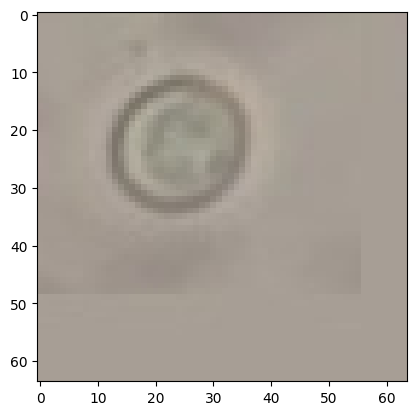

3


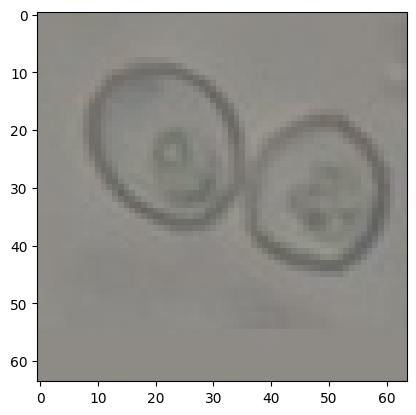

3


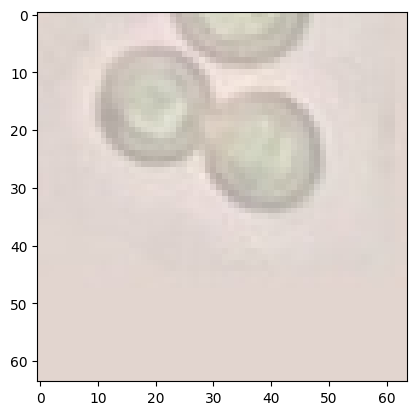

0


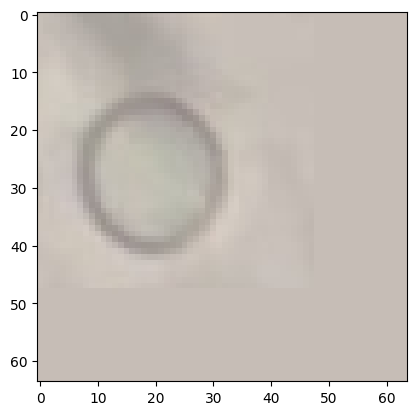

1


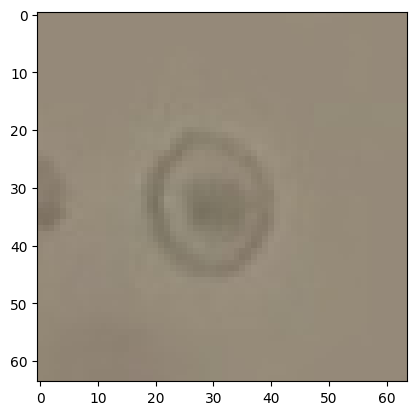

1


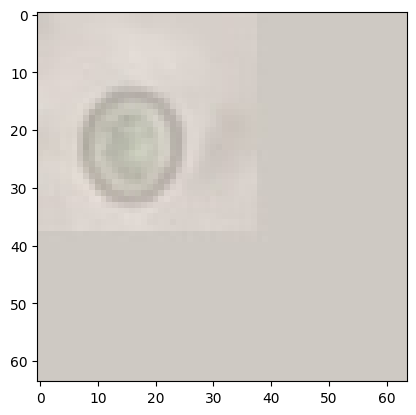

In [27]:
for i in range(len(test_dataset)):
    img_path = test_dataset.img_paths[i]
    print(predict(img_path, model, device))
    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    plt.show()

In [28]:
def predict_v2(img, model, device):
    img = data_transform['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    return pred.item()


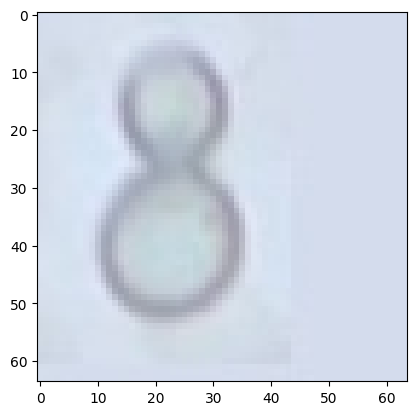

2


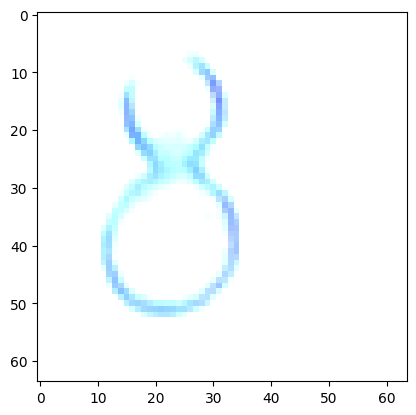

In [29]:
test_img = cv2.imread(test_dataset.img_paths[5])
plt.imshow(test_img)
plt.show()
print(predict_v2(test_img, model, device))
img = data_transform['val'](test_img)
img = img.permute(1,2,0)
plt.imshow(img)
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [64]:
def predict_cell(image,mask, model):
    """
    Parameters:
    image (numpy.ndarray): The input image containing cells, in BGR format.
    mask (numpy.ndarray): A binary mask to identify the regions containing cells.
    model (keras.Model): A pre-trained machine learning model for cell classification.

    Returns:
    normal (int): The number of cells classified as "normal".
    abnormal (int): The number of cells classified as "abnormal".
    normal_2x (int): The number of cells classified as "normal_2x".
    abnormal_2x (int): The number of cells classified as "abnormal_2x".
    image (numpy.ndarray): The input image with rectangles drawn around detected cells, including area and perimeter information.
    bounding_boxes (list): A list of objects containing information about the location, size, type, and contours of the cells.

    """
    label_dict = {
        0: "normal",
        1: "abnormal",
        2: "normal_2x",
        3: "abnormal_2x"
    }

    ret, nguong1 = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    nguong2 = cv2.bitwise_not(nguong1)

    contours, _ = cv2.findContours(nguong2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    MIN_HEIGHT = 10
    MAX_HEIGHT = image.shape[0] * 0.25

    normal = 0
    abnormal = 0
    normal_2x = 0
    abnormal_2x = 0
    id = 1
    bboxes = []
    for cnt in contours[:-1]:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > MIN_HEIGHT and w < MAX_HEIGHT and h > MIN_HEIGHT and h < MAX_HEIGHT:
            y1 = max(0, y - 4)
            y2 = min(mask.shape[0], y + h + 4)
            x1 = max(0, x - 4)
            x2 = min(mask.shape[1], x + w + 4)

            crop_number = image[y1:y2, x1:x2]
            crop_number = new_resize_image(crop_number, 64, crop_number[0][0].tolist())
            plt.imshow(crop_number)
            plt.axis("off")
            pil_img = Image.fromarray(crop_number).convert('RGB')
            label = predict_v2(pil_img, model, device)
            plt.title(f"Label cell: {label_dict[label]}")
            plt.show()
            # predicted_class2 = np.argmax(predictions2, axis =1)
            #print(prediction)
            color = None
            if label == 0:
                normal += 1
            elif label == 1:
                abnormal += 1
            elif label == 2:
                normal_2x += 1
            else:
                abnormal_2x += 1
            bboxes.append([x1,x2,y1,y2,label])

    for bbox in bboxes:
        x1,x2,y1,y2,label = bbox
        if label == 0:
            color = (0, 0, 255)
        elif label == 1:
            color = (128, 0, 128)
        elif label == 3:
            color = (255, 0, 0)
        else:
            color = (0, 255, 0)

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # cv2.putText(image, label_dict[label], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


    return image

In [65]:
image = cv2.imread('image.jpeg')
mask = cv2.imread('mask.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [46]:
mask.shape

(1536, 1536)

In [47]:
image.shape

(1536, 1536, 3)

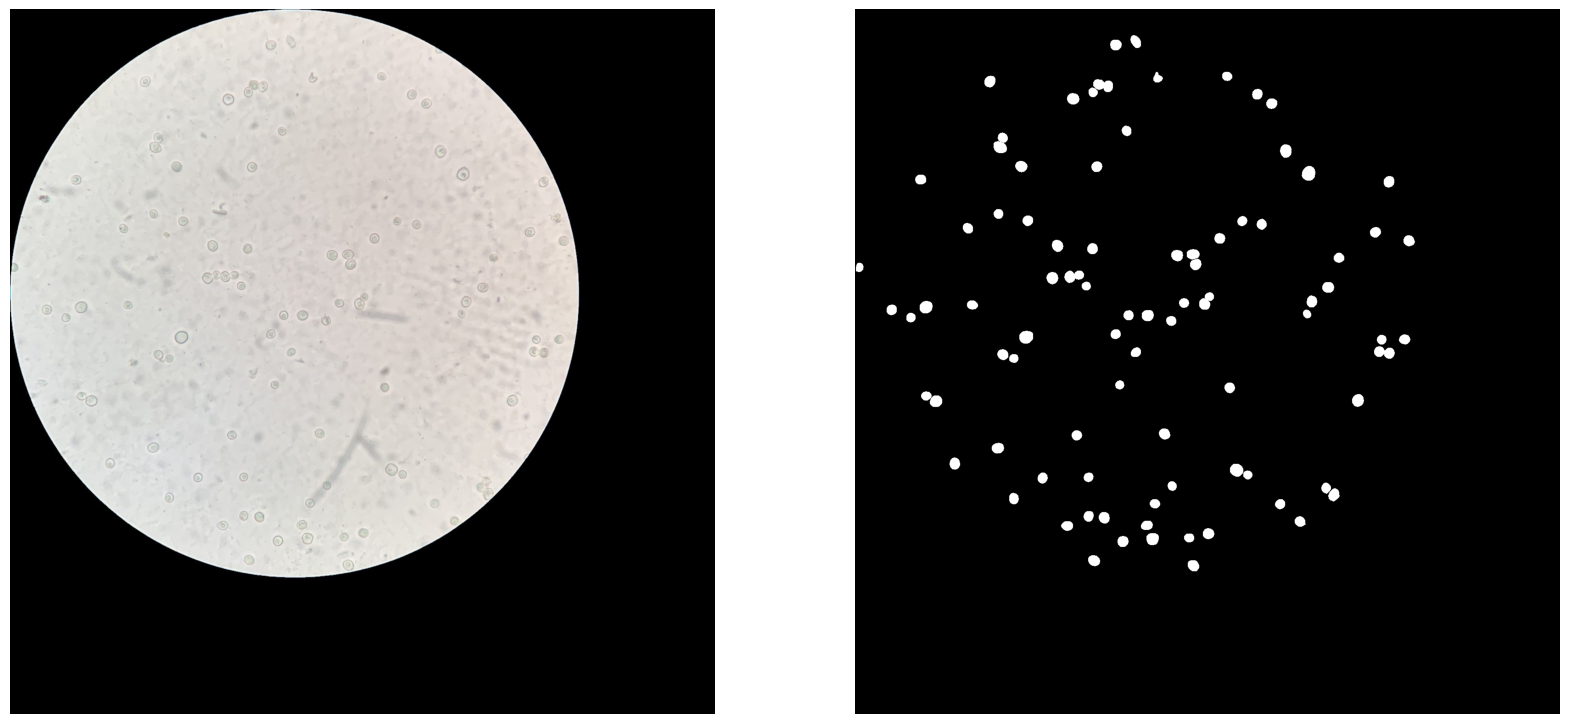

In [56]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask,cmap="gray")
plt.axis('off')
plt.show()

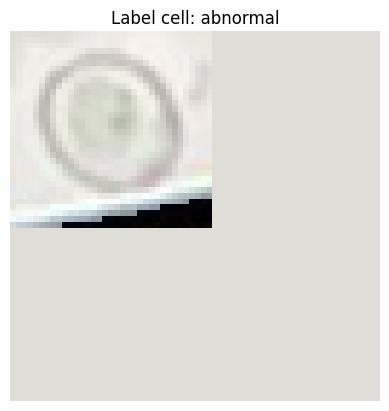

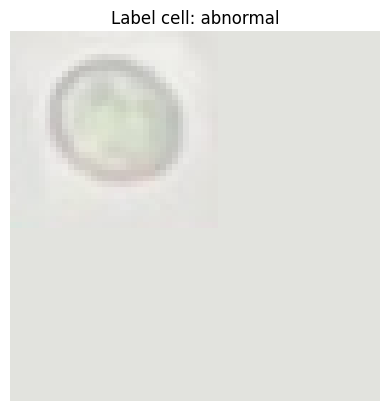

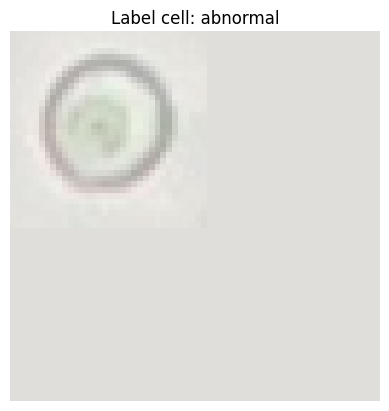

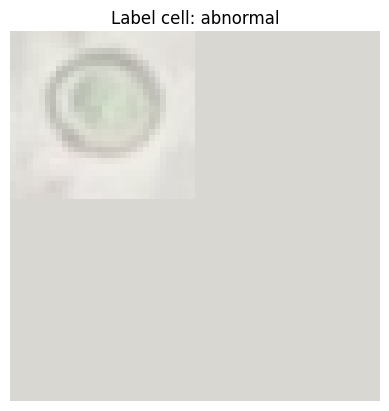

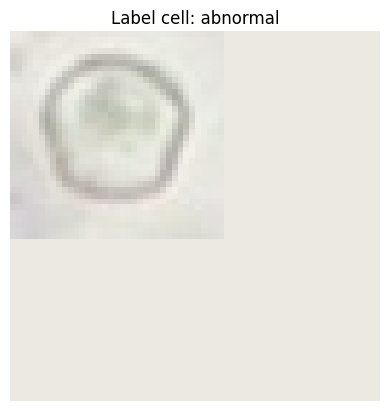

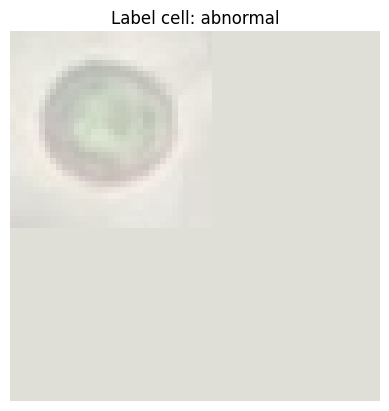

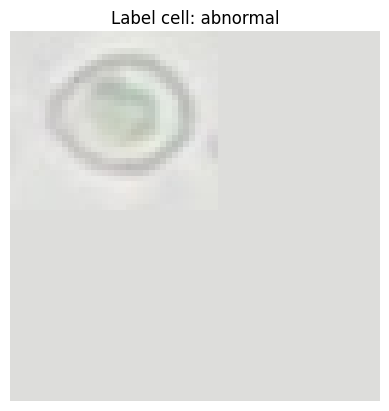

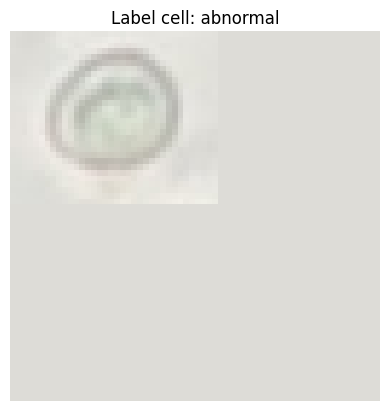

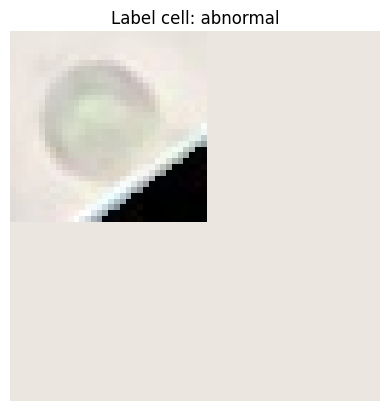

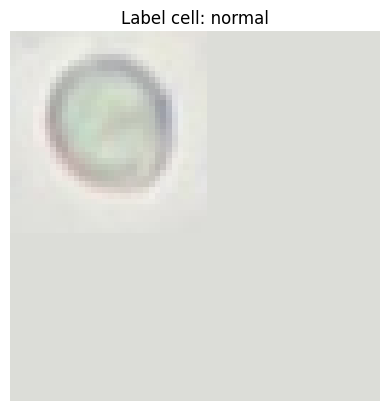

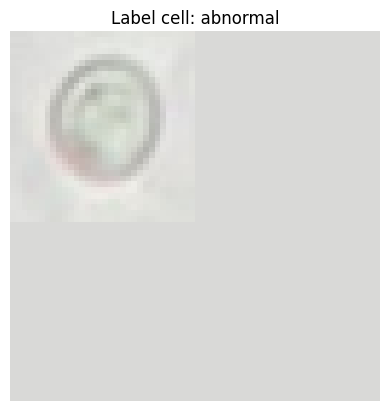

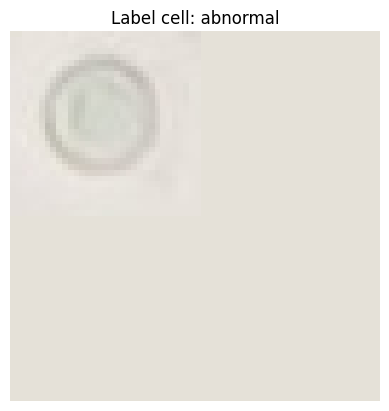

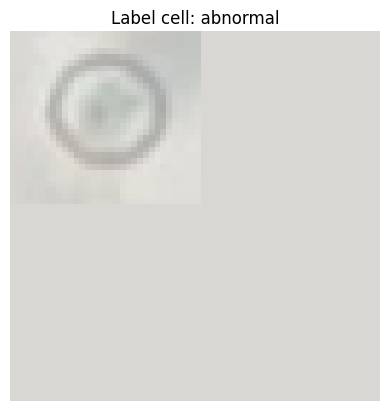

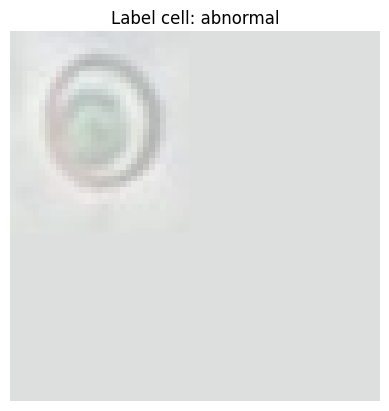

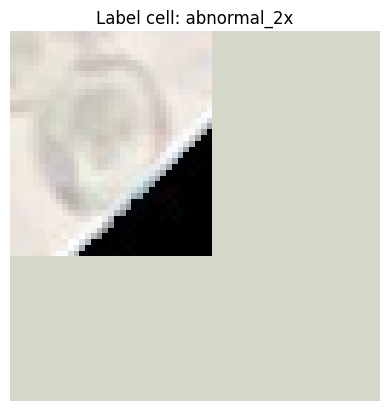

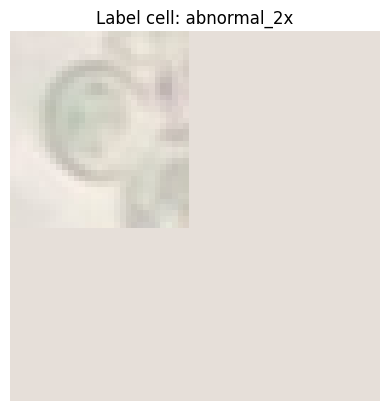

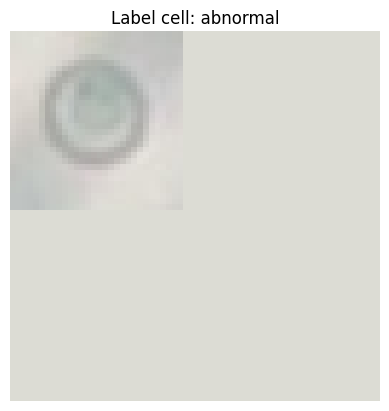

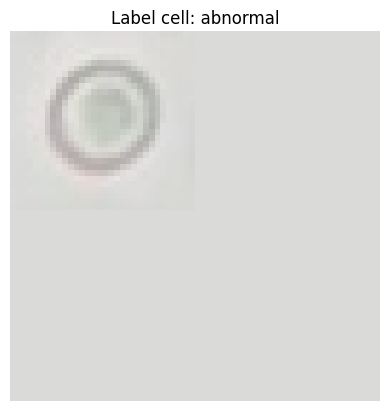

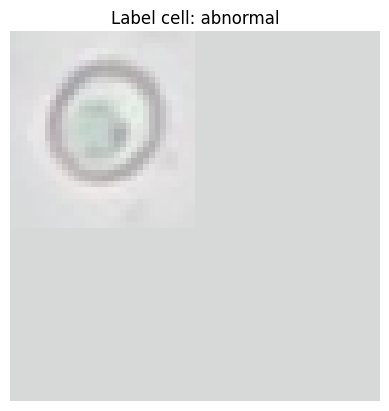

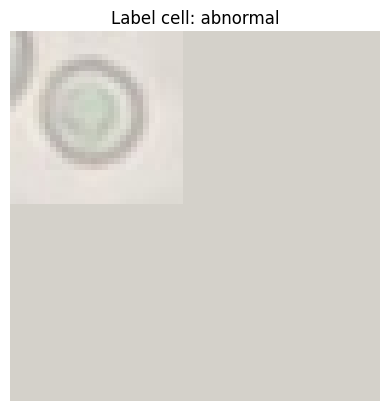

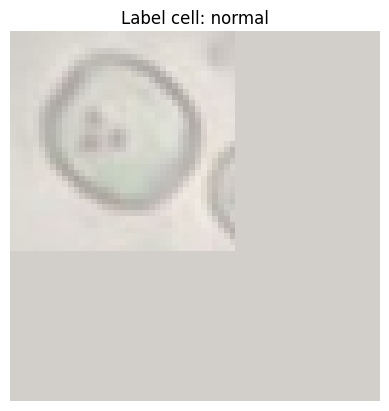

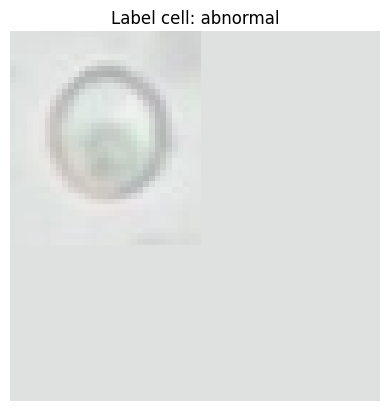

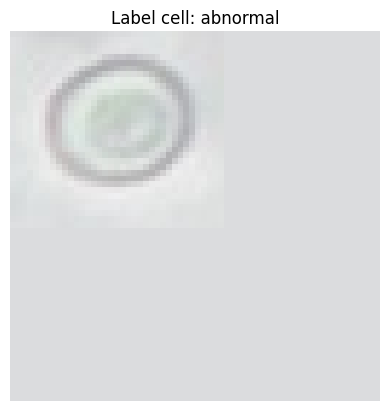

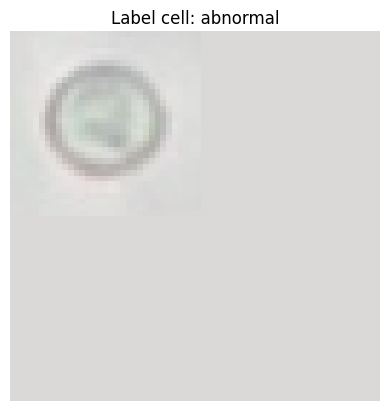

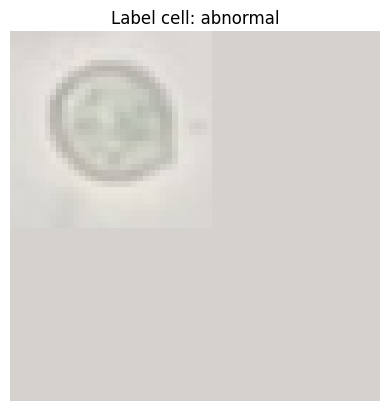

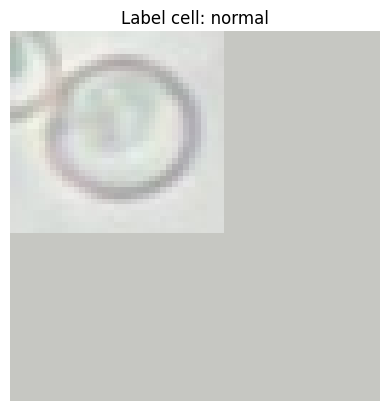

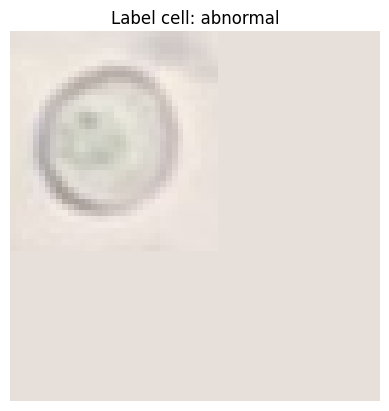

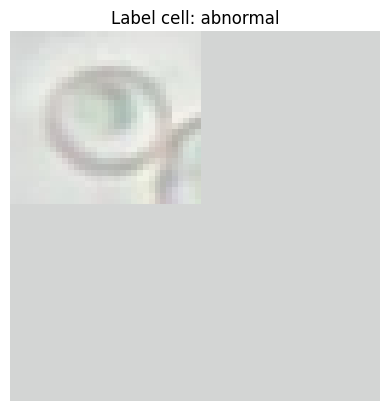

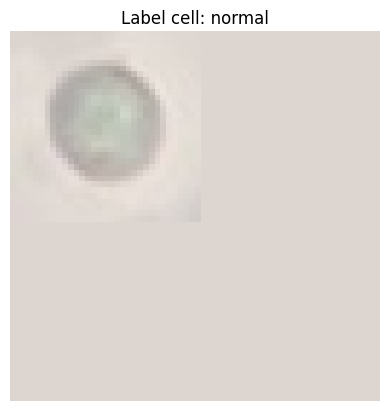

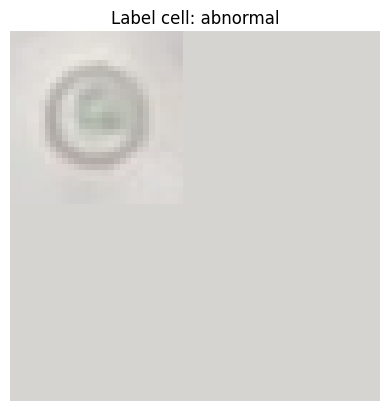

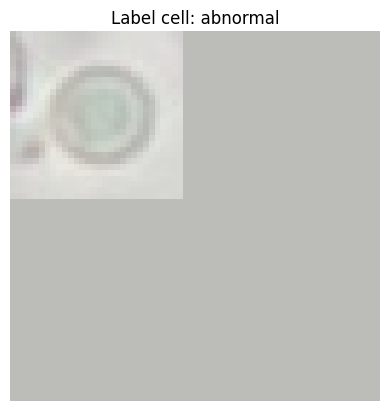

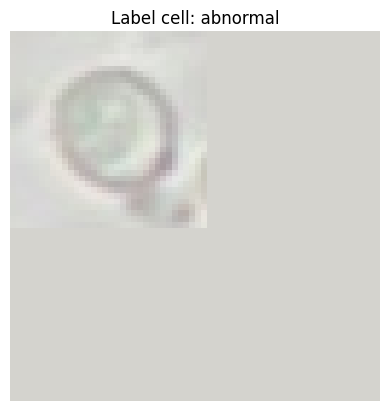

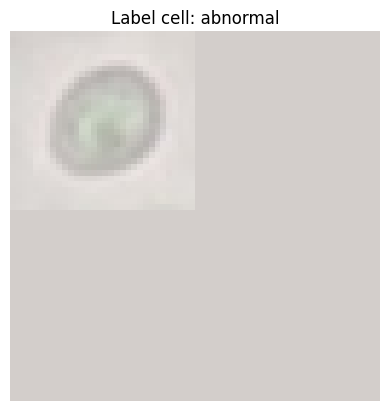

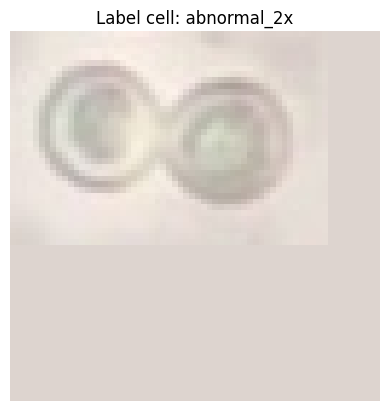

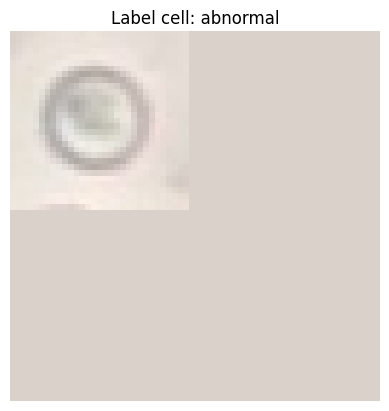

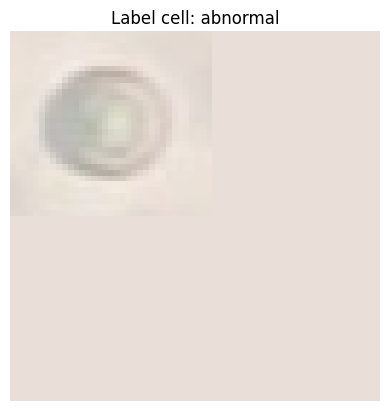

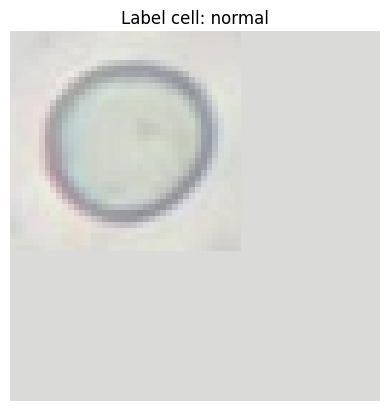

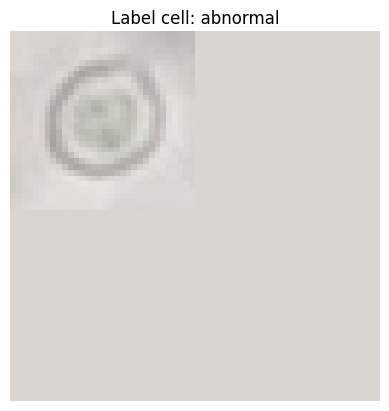

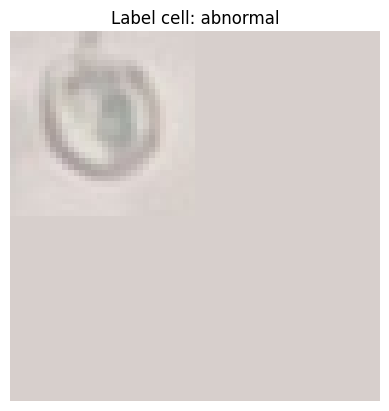

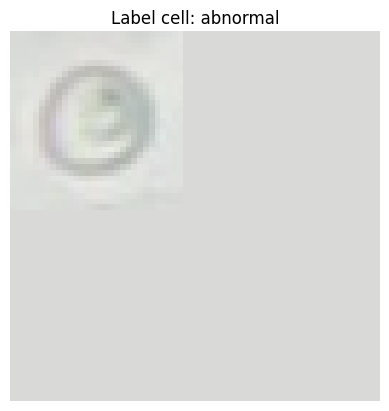

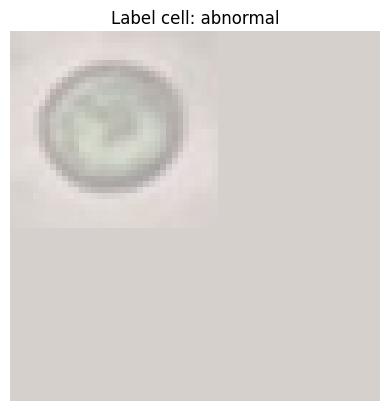

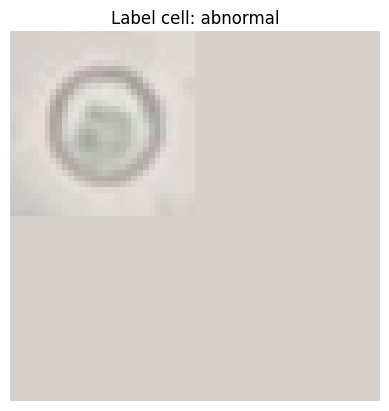

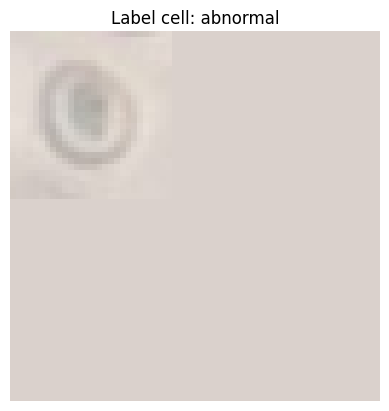

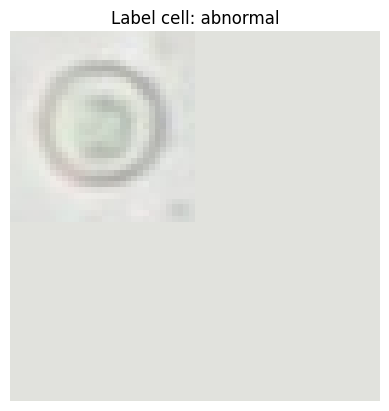

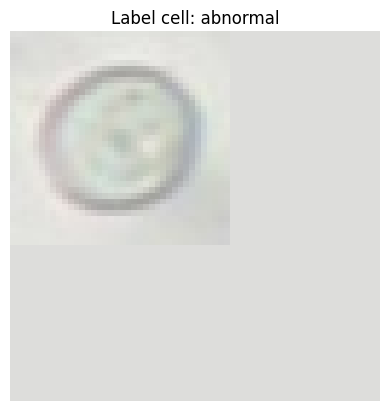

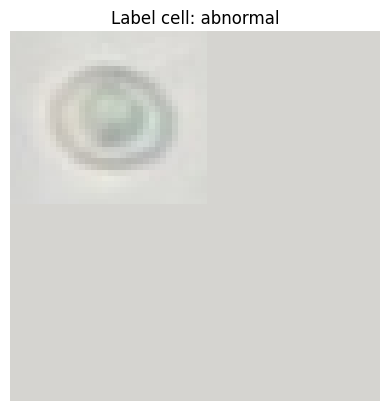

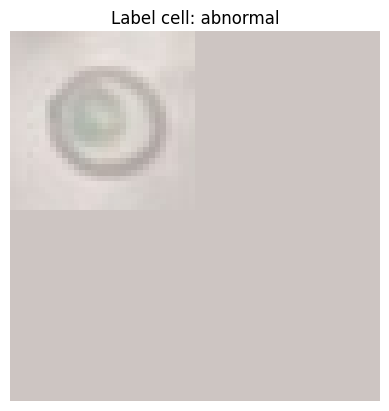

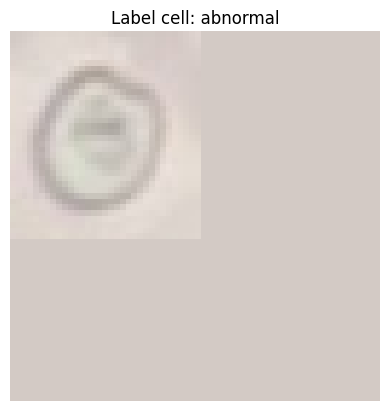

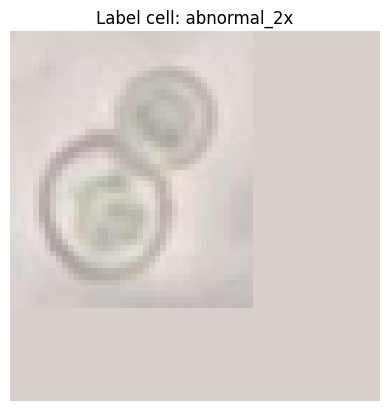

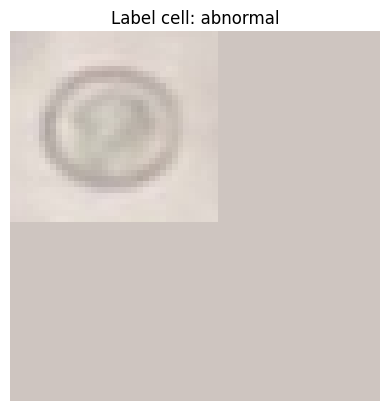

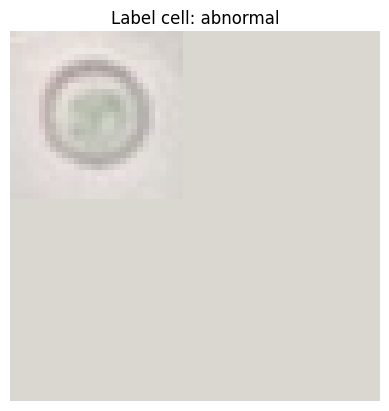

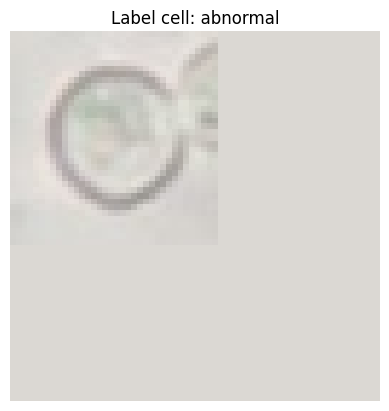

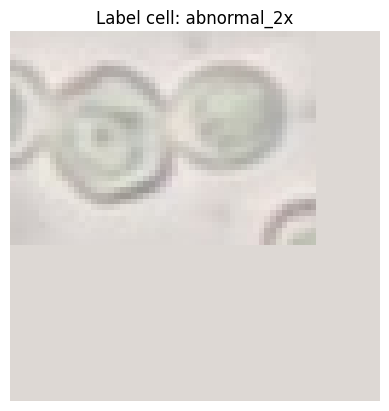

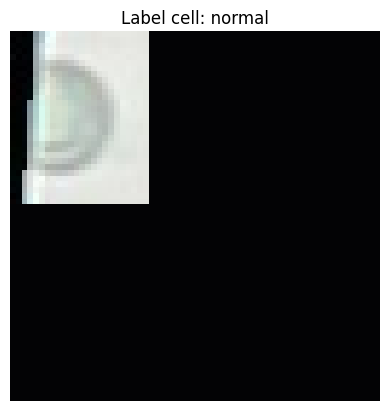

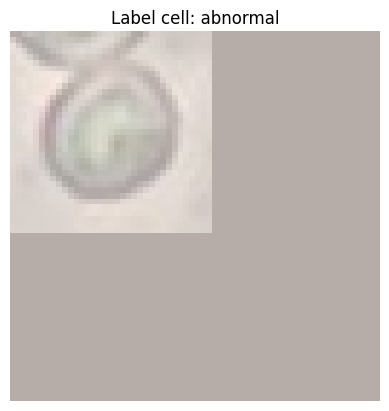

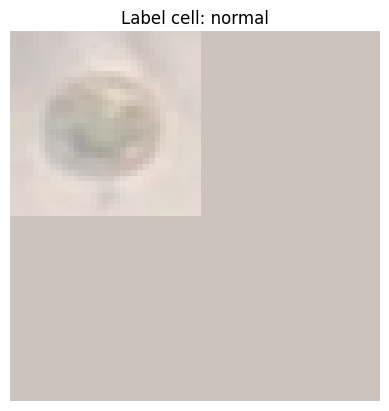

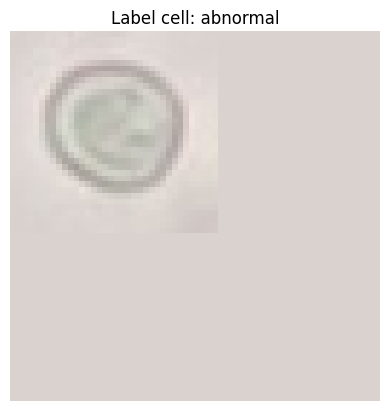

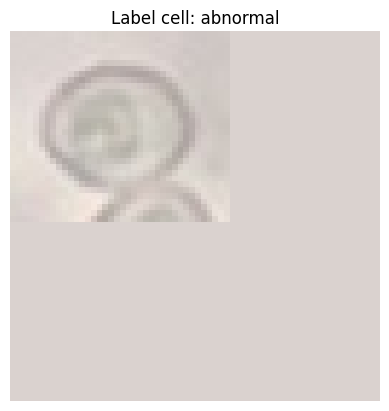

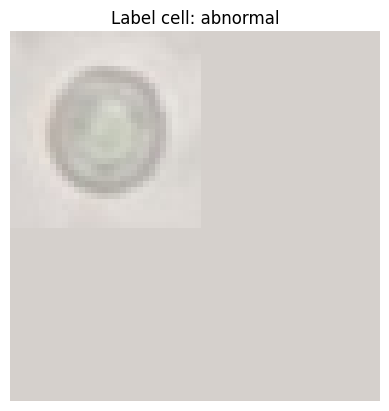

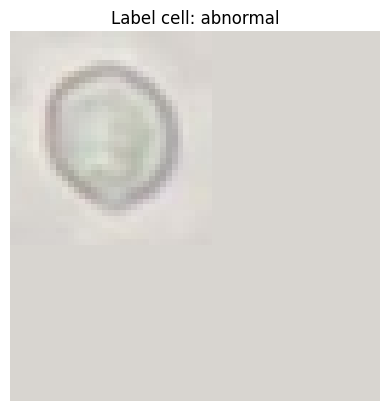

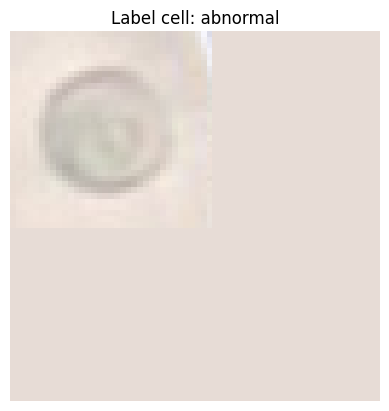

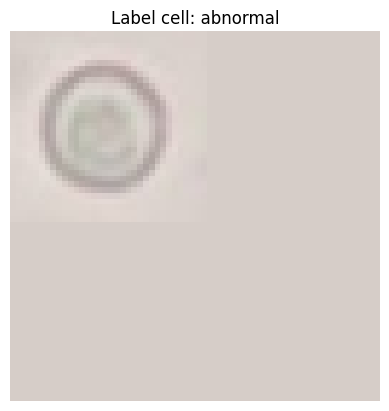

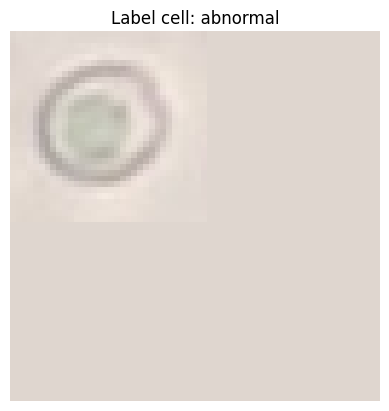

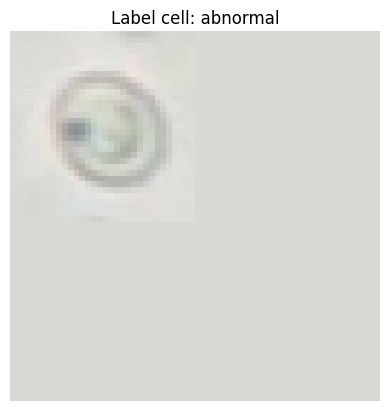

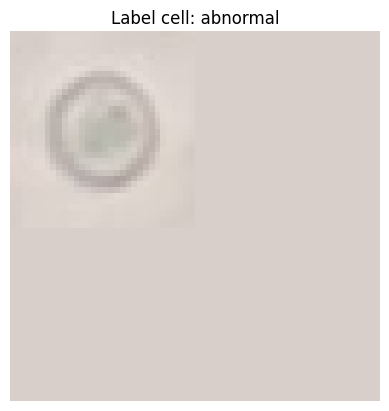

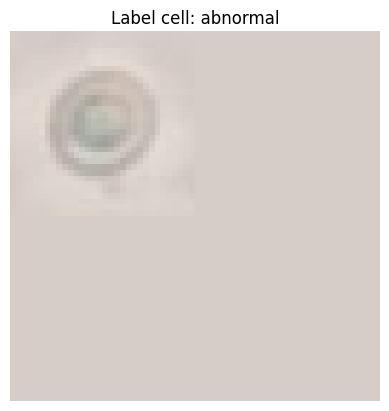

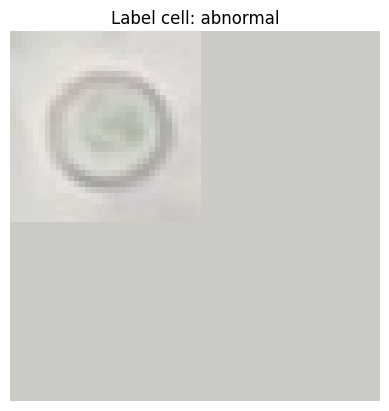

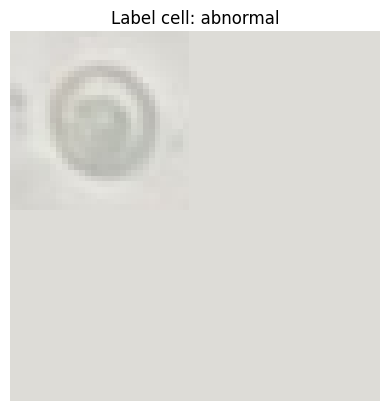

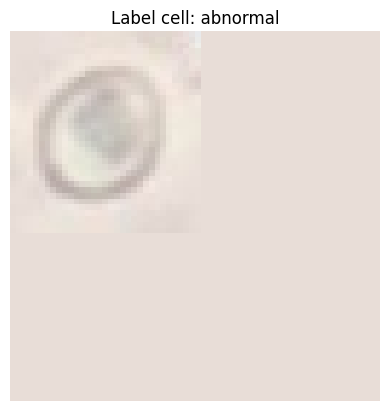

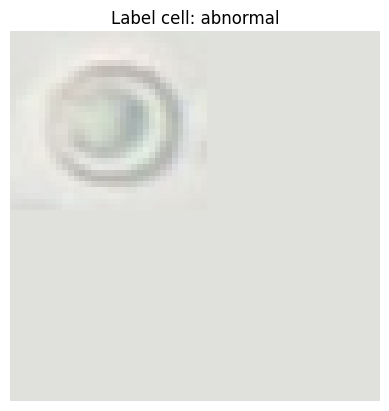

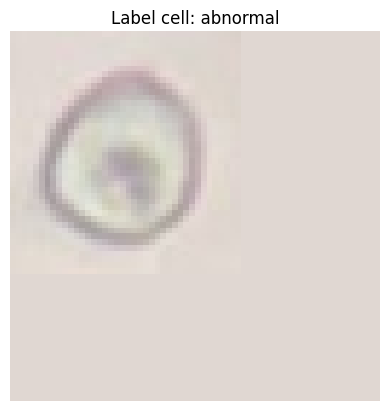

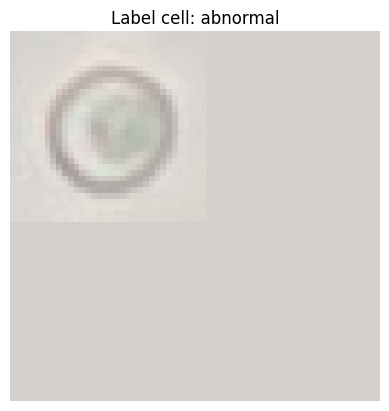

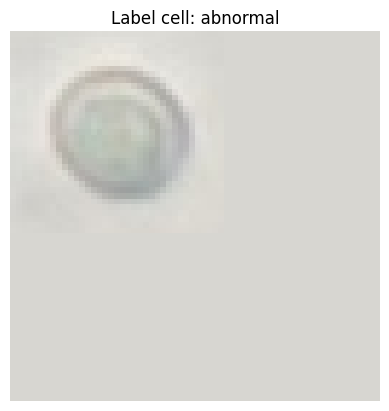

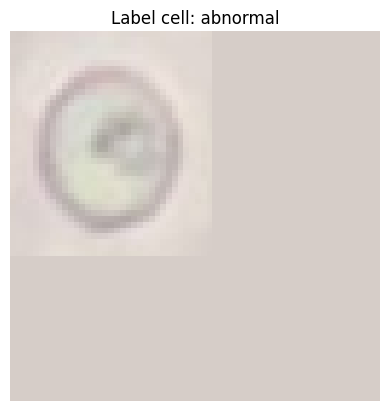

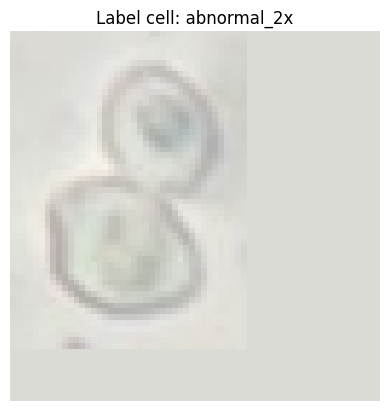

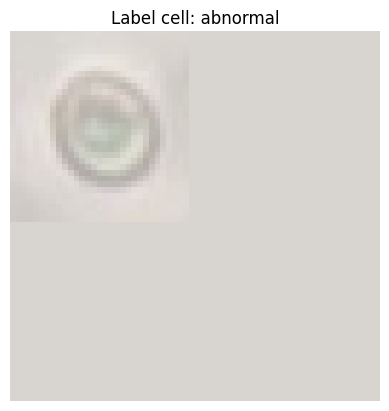

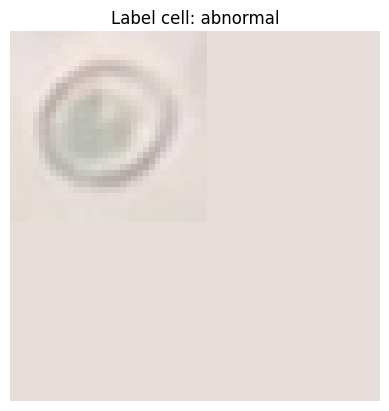

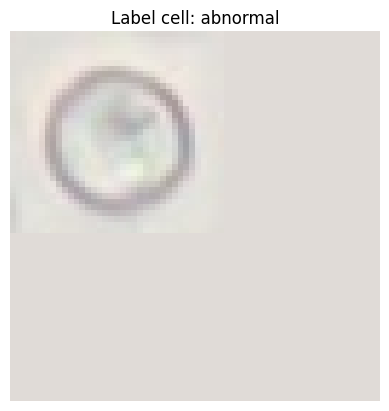

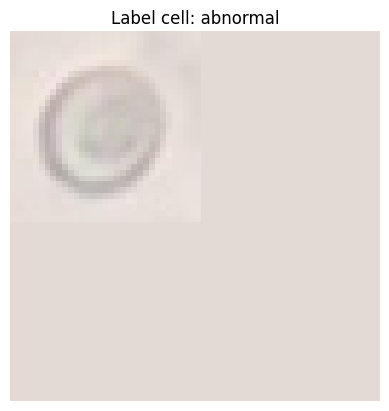

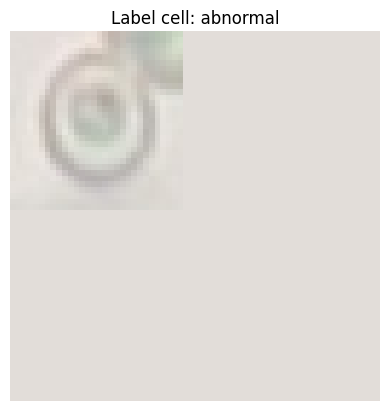

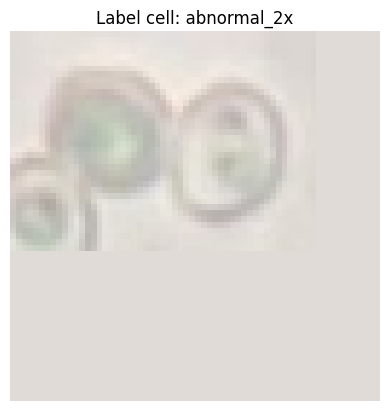

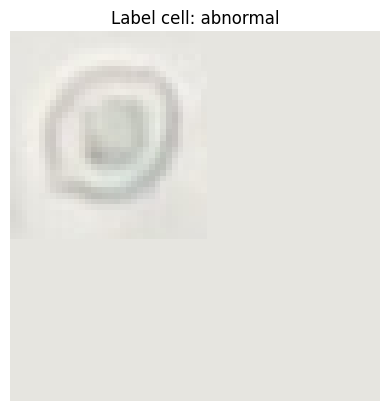

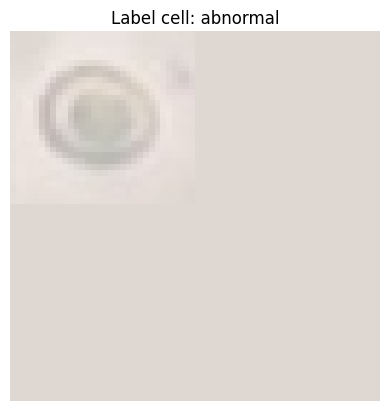

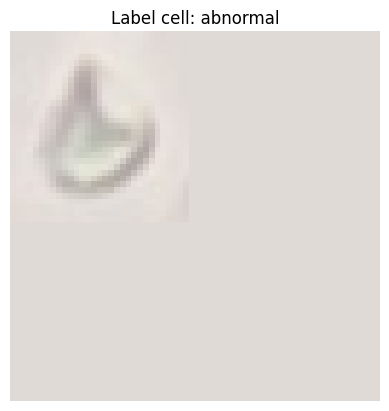

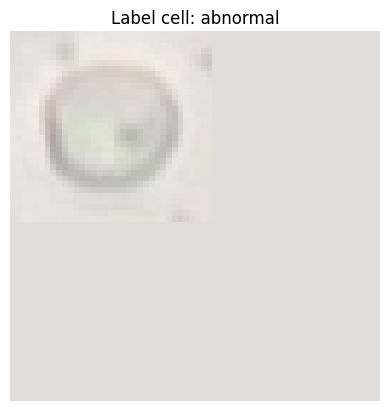

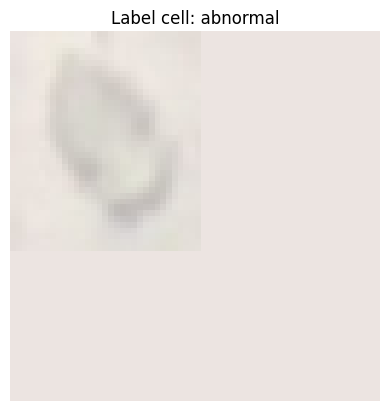

In [66]:
image_predict = predict_cell(image, mask, model)

In [67]:
image_predict = cv2.cvtColor(image_predict, cv2.COLOR_BGR2RGB)

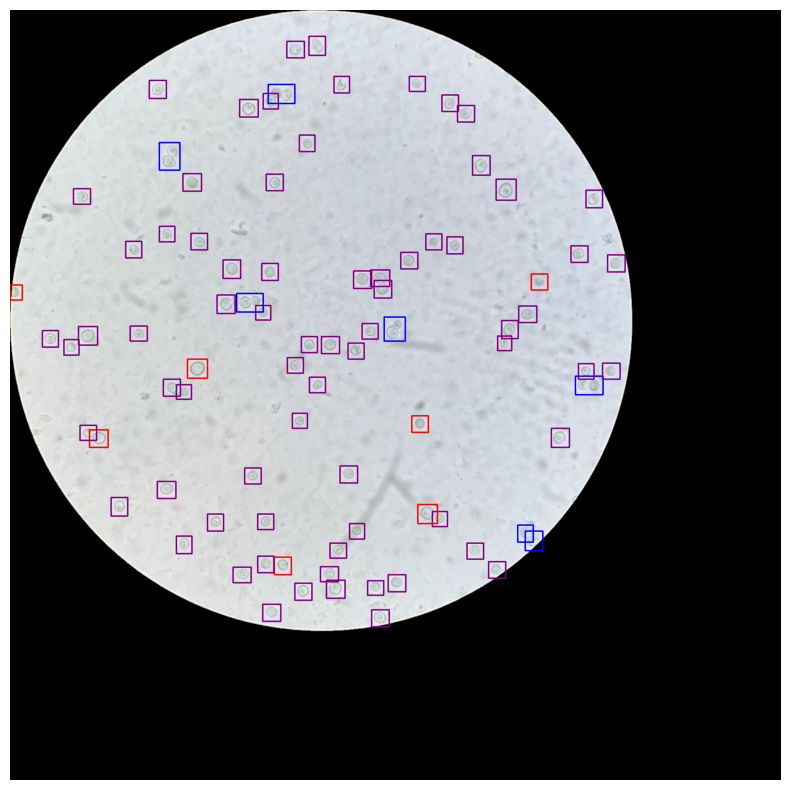

In [68]:
plt.figure(figsize = (20,10))
plt.imshow(image_predict)
plt.axis('off')
plt.show()